# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости автомобиля. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.


### **Описание данных**
<br>

**Признаки:**
- `DateCrawled` — дата скачивания анкеты из базы;
- `VehicleType` — тип автомобильного кузова;  
- `RegistrationYear` — год регистрации автомобиля;
- `Gearbox` — тип коробки передач;
- `Power` — мощность (л. с.);
- `Model` — модель автомобиля;
- `Kilometer` —  пробег (км);
- `RegistrationMonth` — месяц регистрации автомобиля;
- `FuelType` — тип топлива;  
- `Brand` —  марка автомобиля;
- `Repaired` —  была машина в ремонте или нет;
- `DateCreated` — дата создания анкеты;
- `NumberOfPictures` — количество фотографий автомобиля;
- `PostalCode` —  почтовый индекс владельца анкеты (пользователя);
- `LastSeen` — дата последней активности пользователя.

<br>

**Целевой признак:**
- `Price` —  цена (евро).

<br>


In [1]:
!pip install lightgbm -U
!pip install catboost -U
!pip install phik -U

   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
    --------------------------------------- 0.0/1.3 MB 1.3 MB/s eta 0:00:02
   ------- -------------------------------- 0.2/1.3 MB 3.7 MB/s eta 0:00:01
   ---------------------- ----------------- 0.7/1.3 MB 7.6 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 9.3 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 3.3.5
    Uninstalling lightgbm-3.3.5:
      Successfully uninstalled lightgbm-3.3.5
   ---------------------------------------- 0.0/101.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/101.0 MB 812.7 kB/s eta 0:02:05
   ---------------------------------------- 0.3/101.0 MB 2.8 MB/s eta 0:00:36
   ---------------------------------------- 0.8/101.0 MB 5.4 MB/s eta 0:00:19
   ---------------------------------------- 1.0/101.0 MB 6.6 MB/s eta 0:00:16
   --------

In [2]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from scipy.sparse import csc_matrix
from phik import phik_matrix

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import time
import warnings
warnings.filterwarnings(action='ignore') #отключаем лишние предупреждающие сообщения

RANDOM_STATE = 42

In [3]:
# сделаем настройку для удобства и наглядности

# снимем ограничение на количество столбцов
pd.set_option('display.max_columns', 50)

# снимем ограничение на ширину столбцов
pd.set_option('display.max_colwidth', 120)

# игнорируем предупреждения
pd.set_option('chained_assignment', 'warn')
warnings.simplefilter(action='ignore', category=FutureWarning)

# выставим ограничение на показ знаков после запятой
pd.options.display.float_format = '{:,.2f}'.format

# устанавим стиль графиков
sns.set(rc={'figure.dpi':200, 'savefig.dpi':300})   
sns.set_context('notebook') 
sns.set_style('ticks') 
sns.set_style('whitegrid')

In [4]:
# загрузим данные и сохраним их в переменную
data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [5]:
# посмотрим на первые строки таблицы
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
# изучим общую информацию о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
# определим процент пропущенных значений в каждом столбце
data.isna().sum().sort_values(ascending=False) \
    / data.shape[0] * 100

Repaired            20.08
VehicleType         10.58
FuelType             9.28
Gearbox              5.60
Model                5.56
DateCrawled          0.00
Price                0.00
RegistrationYear     0.00
Power                0.00
Kilometer            0.00
RegistrationMonth    0.00
Brand                0.00
DateCreated          0.00
NumberOfPictures     0.00
PostalCode           0.00
LastSeen             0.00
dtype: float64

In [8]:
# проверим наличие дубликатов
data.duplicated().sum() 

4

In [9]:
# изучим детальнее числовые признаки
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,"354,369.00","354,369.00","354,369.00","354,369.00","354,369.00","354,369.00","354,369.00"
mean,"4,416.66","2,004.23",110.09,"128,211.17",5.71,0.00,"50,508.69"
std,"4,514.16",90.23,189.85,"37,905.34",3.73,0.00,"25,783.10"
min,0.00,"1,000.00",0.00,"5,000.00",0.00,0.00,"1,067.00"
25%,"1,050.00","1,999.00",69.00,"125,000.00",3.00,0.00,"30,165.00"
50%,"2,700.00","2,003.00",105.00,"150,000.00",6.00,0.00,"49,413.00"
75%,"6,400.00","2,008.00",143.00,"150,000.00",9.00,0.00,"71,083.00"
max,"20,000.00","9,999.00","20,000.00","150,000.00",12.00,0.00,"99,998.00"


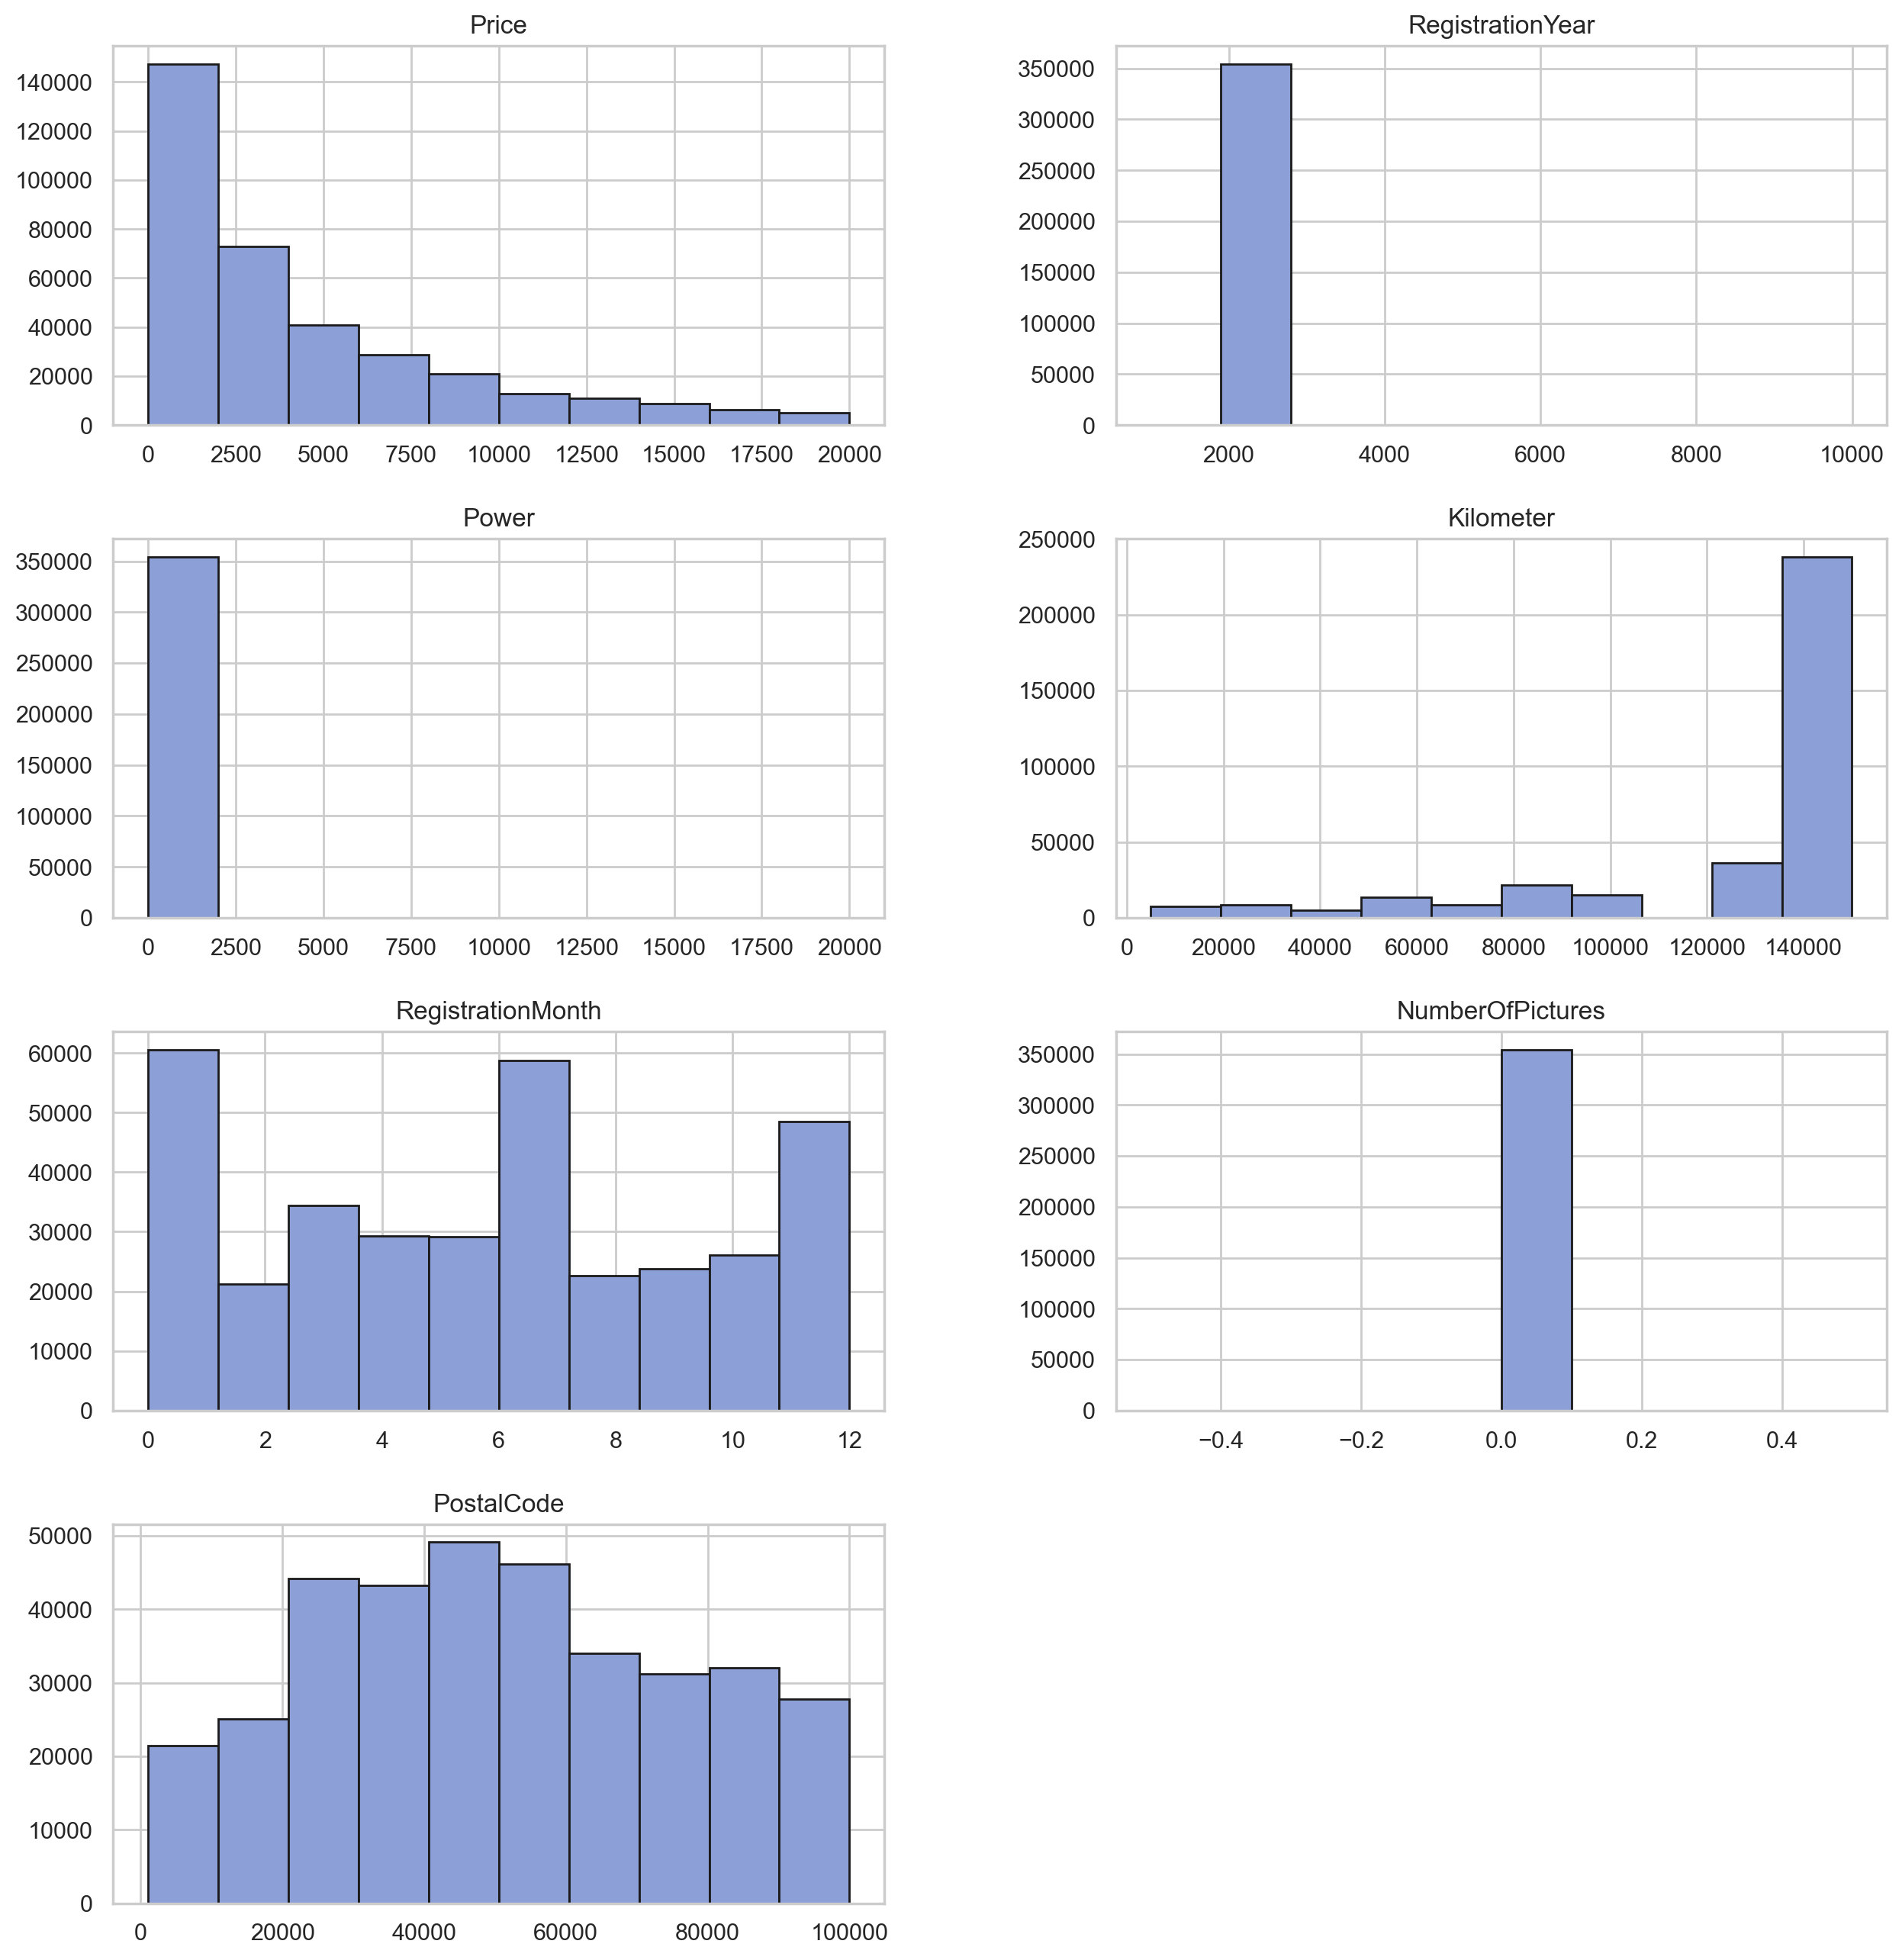

In [10]:
# проверим распределения числовых признаков
data.hist(figsize=(15, 20), layout=(5, 2), color = '#8CA0D7', ec='k')
plt.show()

### Вывод по шагу "Загрузка данных"

1. Файл содержит данные по 354369 автомобилям, каждый из которых описывается 16-ю признаками (7 количественных, 6 категориальных и 3 временных).


2. Данные требуют дополнительной предобработки. Необходима обработка пропущенных значений, изменение типов некоторых данных, удаление дубликатов и обработка аномалий. Среди признаков имеются неинформативные. Их необходимо удалить.


3. Перед обучением моделей категориальные признаки требуется закодировать, а также применить масштабирование.

## Шаг 2. Предобработка данных

На этом этапе:

1. Обработаем данные от аномалий
2. Обработаем пропущенные значения
3. Удалим столбцы, не несущие ценности для дальнейшего анализа
4. Удалим дубликаты.

In [11]:
# приведем названия заголовков к нижнему регистру, изменим названия на более удобные:
data.columns = [
    'date_crawled',
    'car_price',
    'vehicle_type',
    'registration_year',
    'gear_box',
    'power',
    'car_model',
    'kilometers',
    'registration_month',
    'fuel_type',
    'car_brand',
    'repaired',
    'ad_created',
    'number_of_pictures',
    'postal_code',
    'last_seen'
]

data.columns.tolist()

['date_crawled',
 'car_price',
 'vehicle_type',
 'registration_year',
 'gear_box',
 'power',
 'car_model',
 'kilometers',
 'registration_month',
 'fuel_type',
 'car_brand',
 'repaired',
 'ad_created',
 'number_of_pictures',
 'postal_code',
 'last_seen']

In [12]:
#сохраним первоначальное количество строк в отдельную переменную
row_before = data.shape[0]
print('Изначальное количество строк =', row_before)

Изначальное количество строк = 354369


### Обработка аномальных значений

Обработаем аномальные значения в признаках: стоимость, год регистрации и мощность автомобиля.

**1. Стоимость автомобиля:**

В целевом признаке наблюдаются слишком низкие значения. Есть автомобили стоиомстью 0 евро, 10 евро, 100 евро. Владельцы автомобилей могут указывать такую цену только за разбитый автомобиль под восставновление, либо с расчётом на равноценный обмен. Такие данные могут сильно исказить предсказания модели. Поэтому оставим только автомобили стоимостью выше 200 евро.

In [13]:
# посмотрим численное описание признака
data.car_price.describe()

count   354,369.00
mean      4,416.66
std       4,514.16
min           0.00
25%       1,050.00
50%       2,700.00
75%       6,400.00
max      20,000.00
Name: car_price, dtype: float64

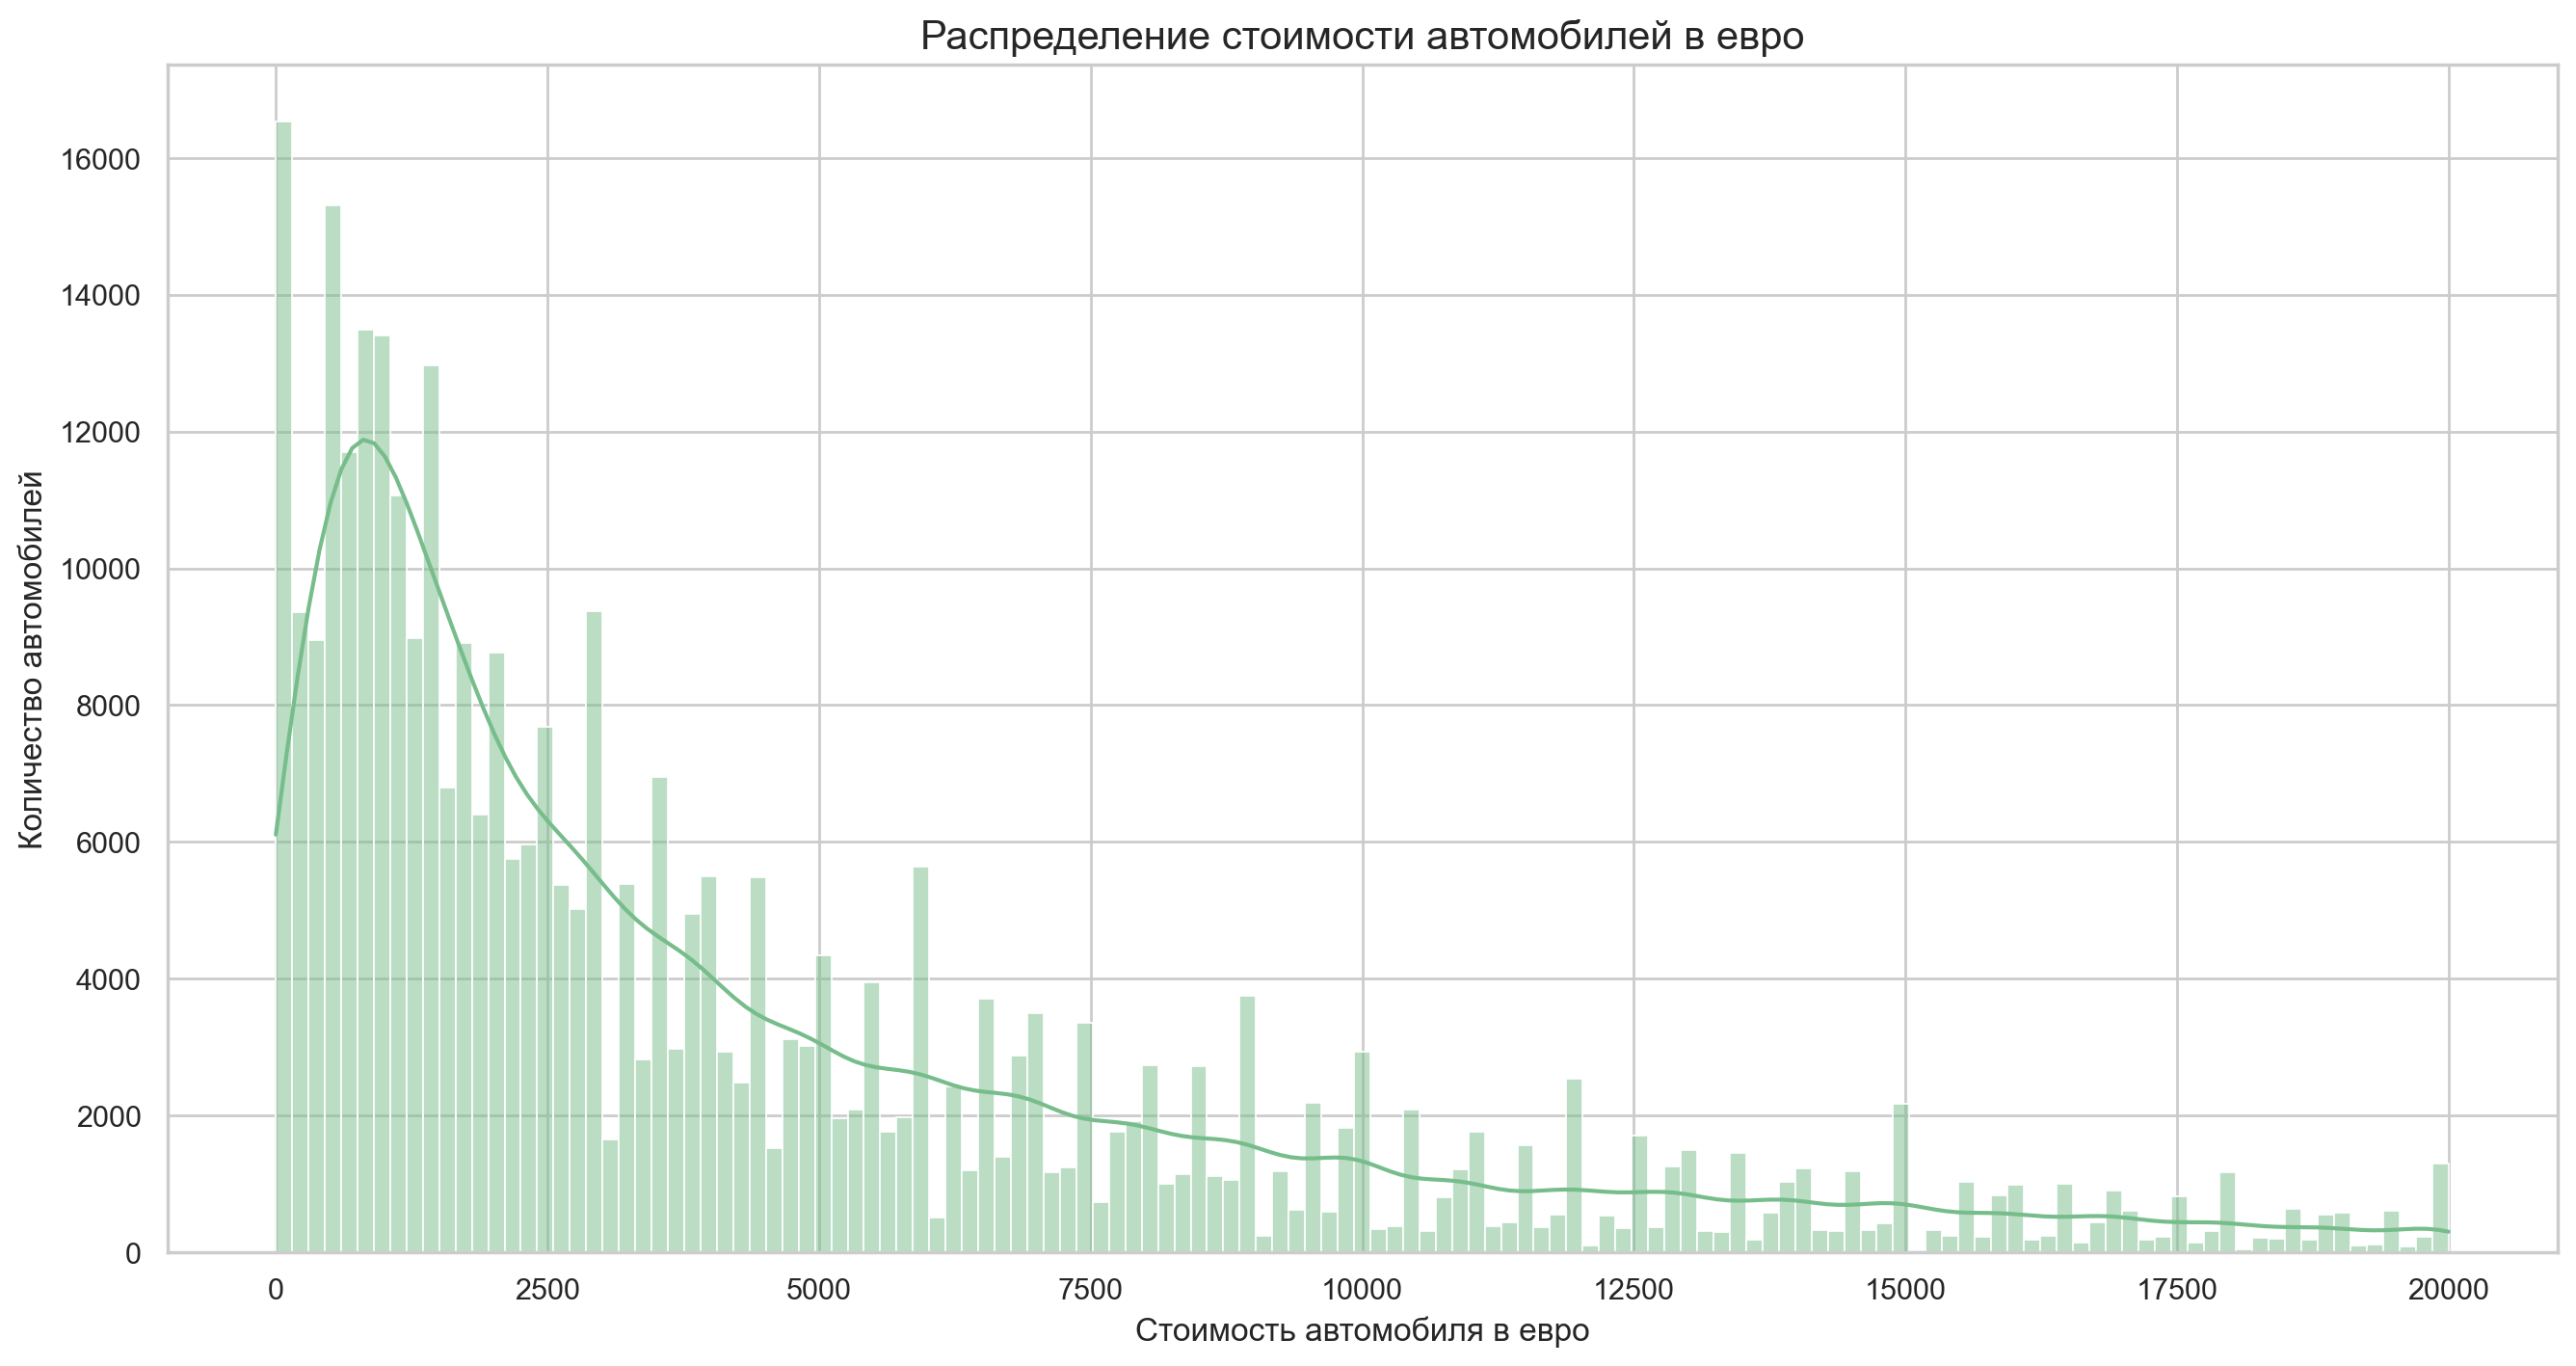

In [14]:
# построим распредление
plt.figure(figsize=(16, 8))
plt.title('Распределение стоимости автомобилей в евро', fontsize=15)
sns.histplot(data['car_price'], color='#77BD8B', kde=True)
plt.xlabel('Стоимость автомобиля в евро', fontsize=12)
plt.ylabel('Количество автомобилей', fontsize=12)
plt.show()

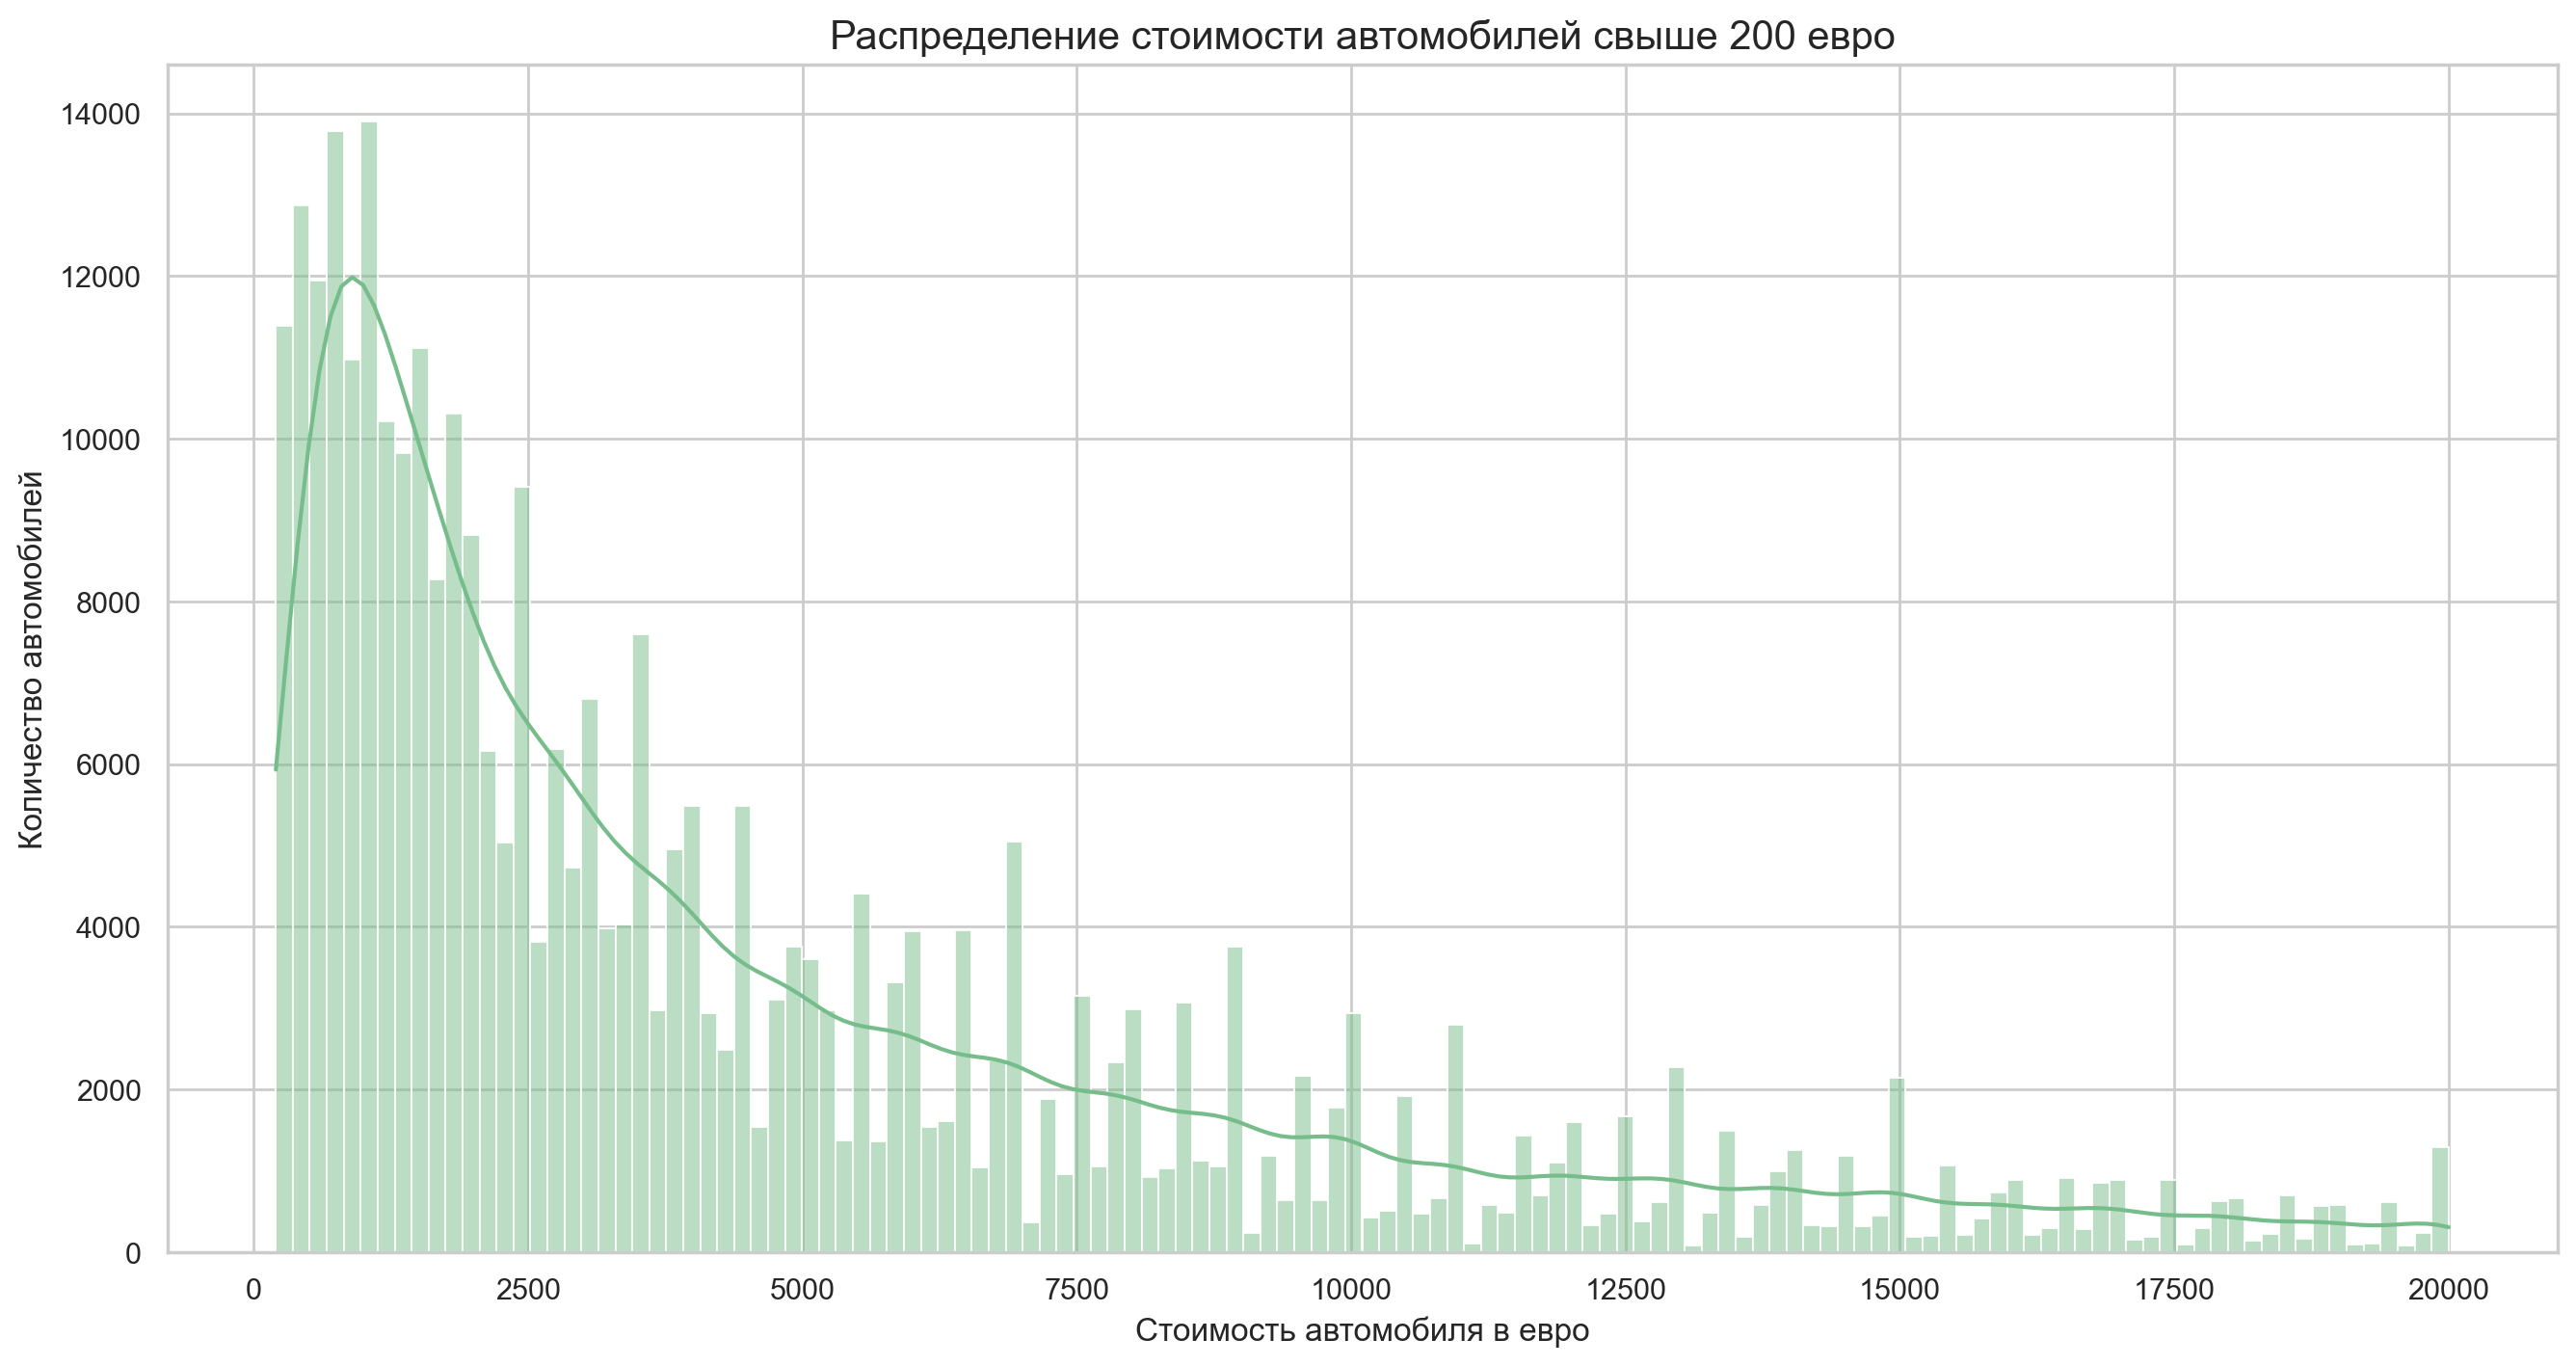

In [15]:
# посмотрим на распределение стоимости более 200 евро
plt.figure(figsize=(16, 8))
plt.title('Распределение стоимости автомобилей свыше 200 евро', fontsize=15)
sns.histplot(data.query('car_price >= 200')['car_price'], color='#77BD8B', kde=True)
plt.xlabel('Стоимость автомобиля в евро', fontsize=12)
plt.ylabel('Количество автомобилей', fontsize=12)
plt.show()

In [16]:
# посмотрим сколько автомобилей стоимостью меньше 200 евро
print('Количество автомобилей с ценой менее 200 евро =', data.query('car_price < 200')['car_price'].count(),
      'Что составляет ', 100*data.query('car_price < 200')['car_price'].count()/row_before, ' %')

Количество автомобилей с ценой менее 200 евро = 17462 Что составляет  4.927631931687027  %


In [17]:
# оставим автомобили стоимостью более 200 евро
data = data.query('car_price >= 200')
data.head()

,date_crawled,car_price,vehicle_type,registration_year,gear_box,power,car_model,kilometers,registration_month,fuel_type,car_brand,repaired,ad_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**2. Год регистрации автомобиля:**

В годе регистрации автомобиля наблюдаем аномалии (5600 или 1111). Удалим строки, где год регистрации выше самого позднего года создания анкеты и меньше 1980. 

In [18]:
# посмотрим на уникальные значения в столбце с годом регистрации автомобиля
data['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1989, 2015,
       1985, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1988, 1980, 1970,
       1986, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 1958, 1967, 1956, 3200, 1941,
       9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957, 1940, 2066, 1949,
       2019, 1937, 1951, 1800, 1959, 1953, 1954, 1234, 5300, 9000, 2900,
       6000, 5900, 1000, 5911, 1400, 5000, 4000, 1948, 1952, 8500, 1932,
       1950, 3700, 3800, 4800, 1942, 7000, 1935, 1933, 1936, 3000, 1923,
       2290, 1930, 1001, 9450, 1944, 2500, 1943, 1938, 1934, 1928, 5555,
       1600, 1111, 1039, 2800, 1931, 4500, 1602, 7800, 1947, 1927, 7100,
       1300, 8200, 1946], dtype=int64)

In [19]:
# определим самую позднюю дату создания анкеты
data['ad_created'] = pd.to_datetime(data['ad_created'], format='%Y-%m-%d %H:%M:%S')
year_last = data['ad_created'].dt.year.max()
print('Последний год создания анкеты:', year_last)

Последний год создания анкеты: 2016


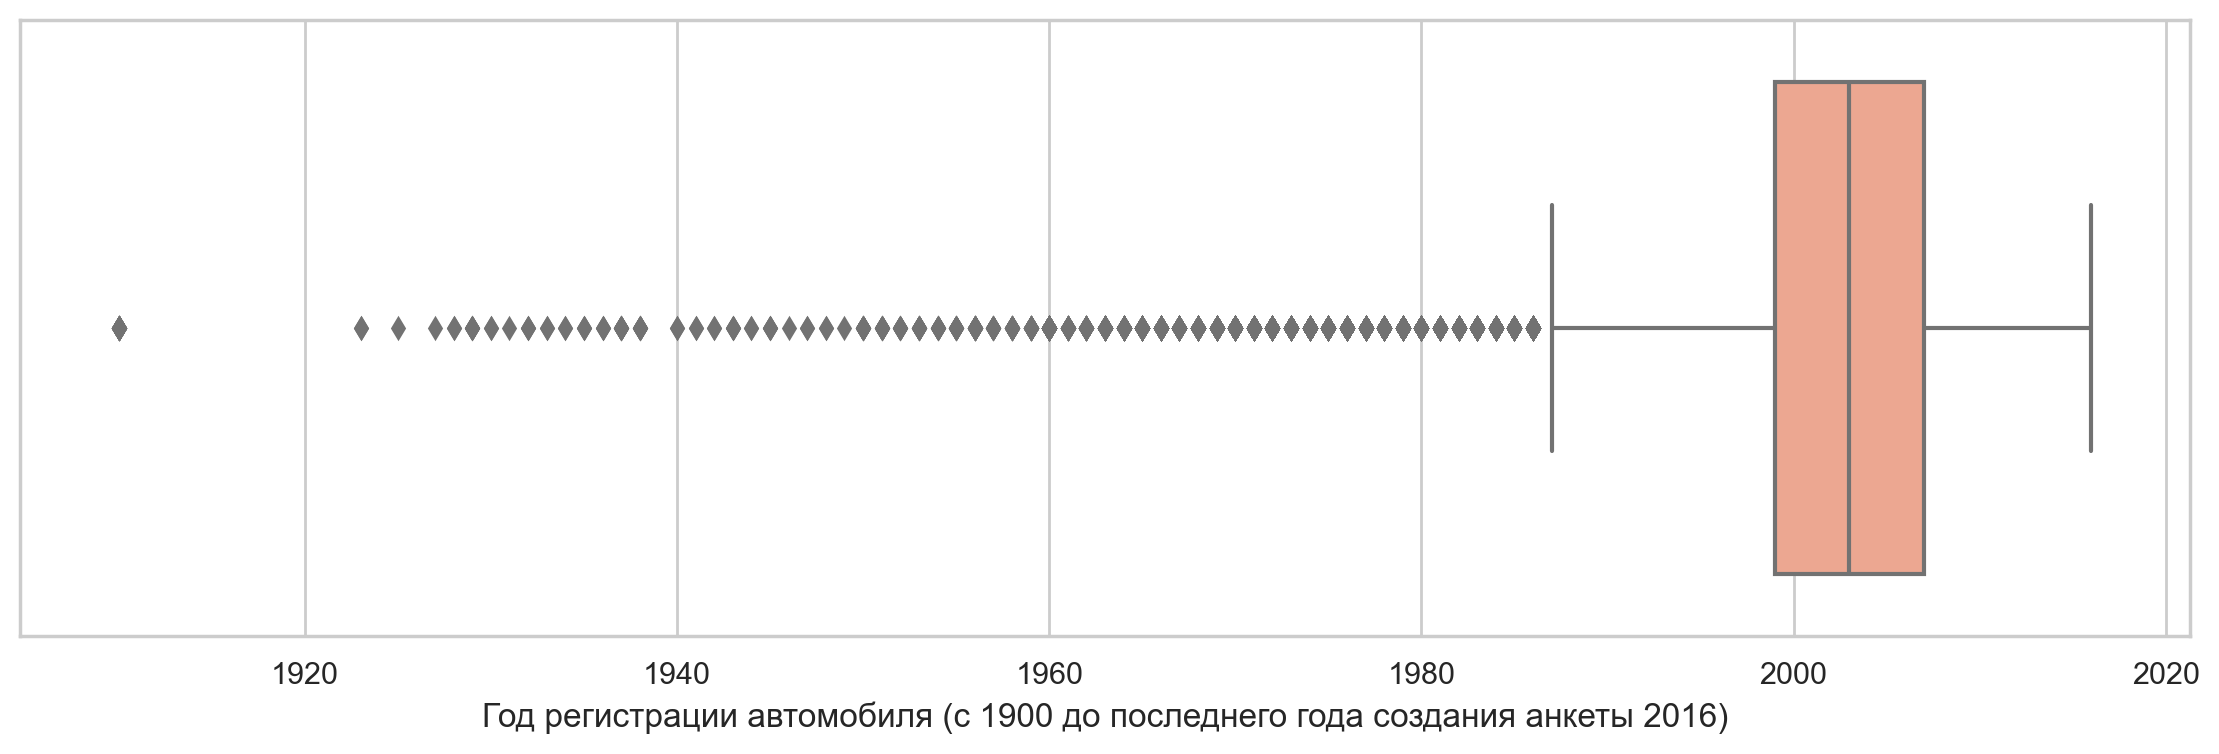

In [20]:
# построим boxplot 
plt.figure(figsize=(14, 4))
sns.boxplot(x=data.query('registration_year <= @year_last & registration_year >= 1900')['registration_year'], color='#FB9F82')
plt.xlabel(f'Год регистрации автомобиля (с 1900 до последнего года создания анкеты {year_last})', fontsize=12)
plt.show()

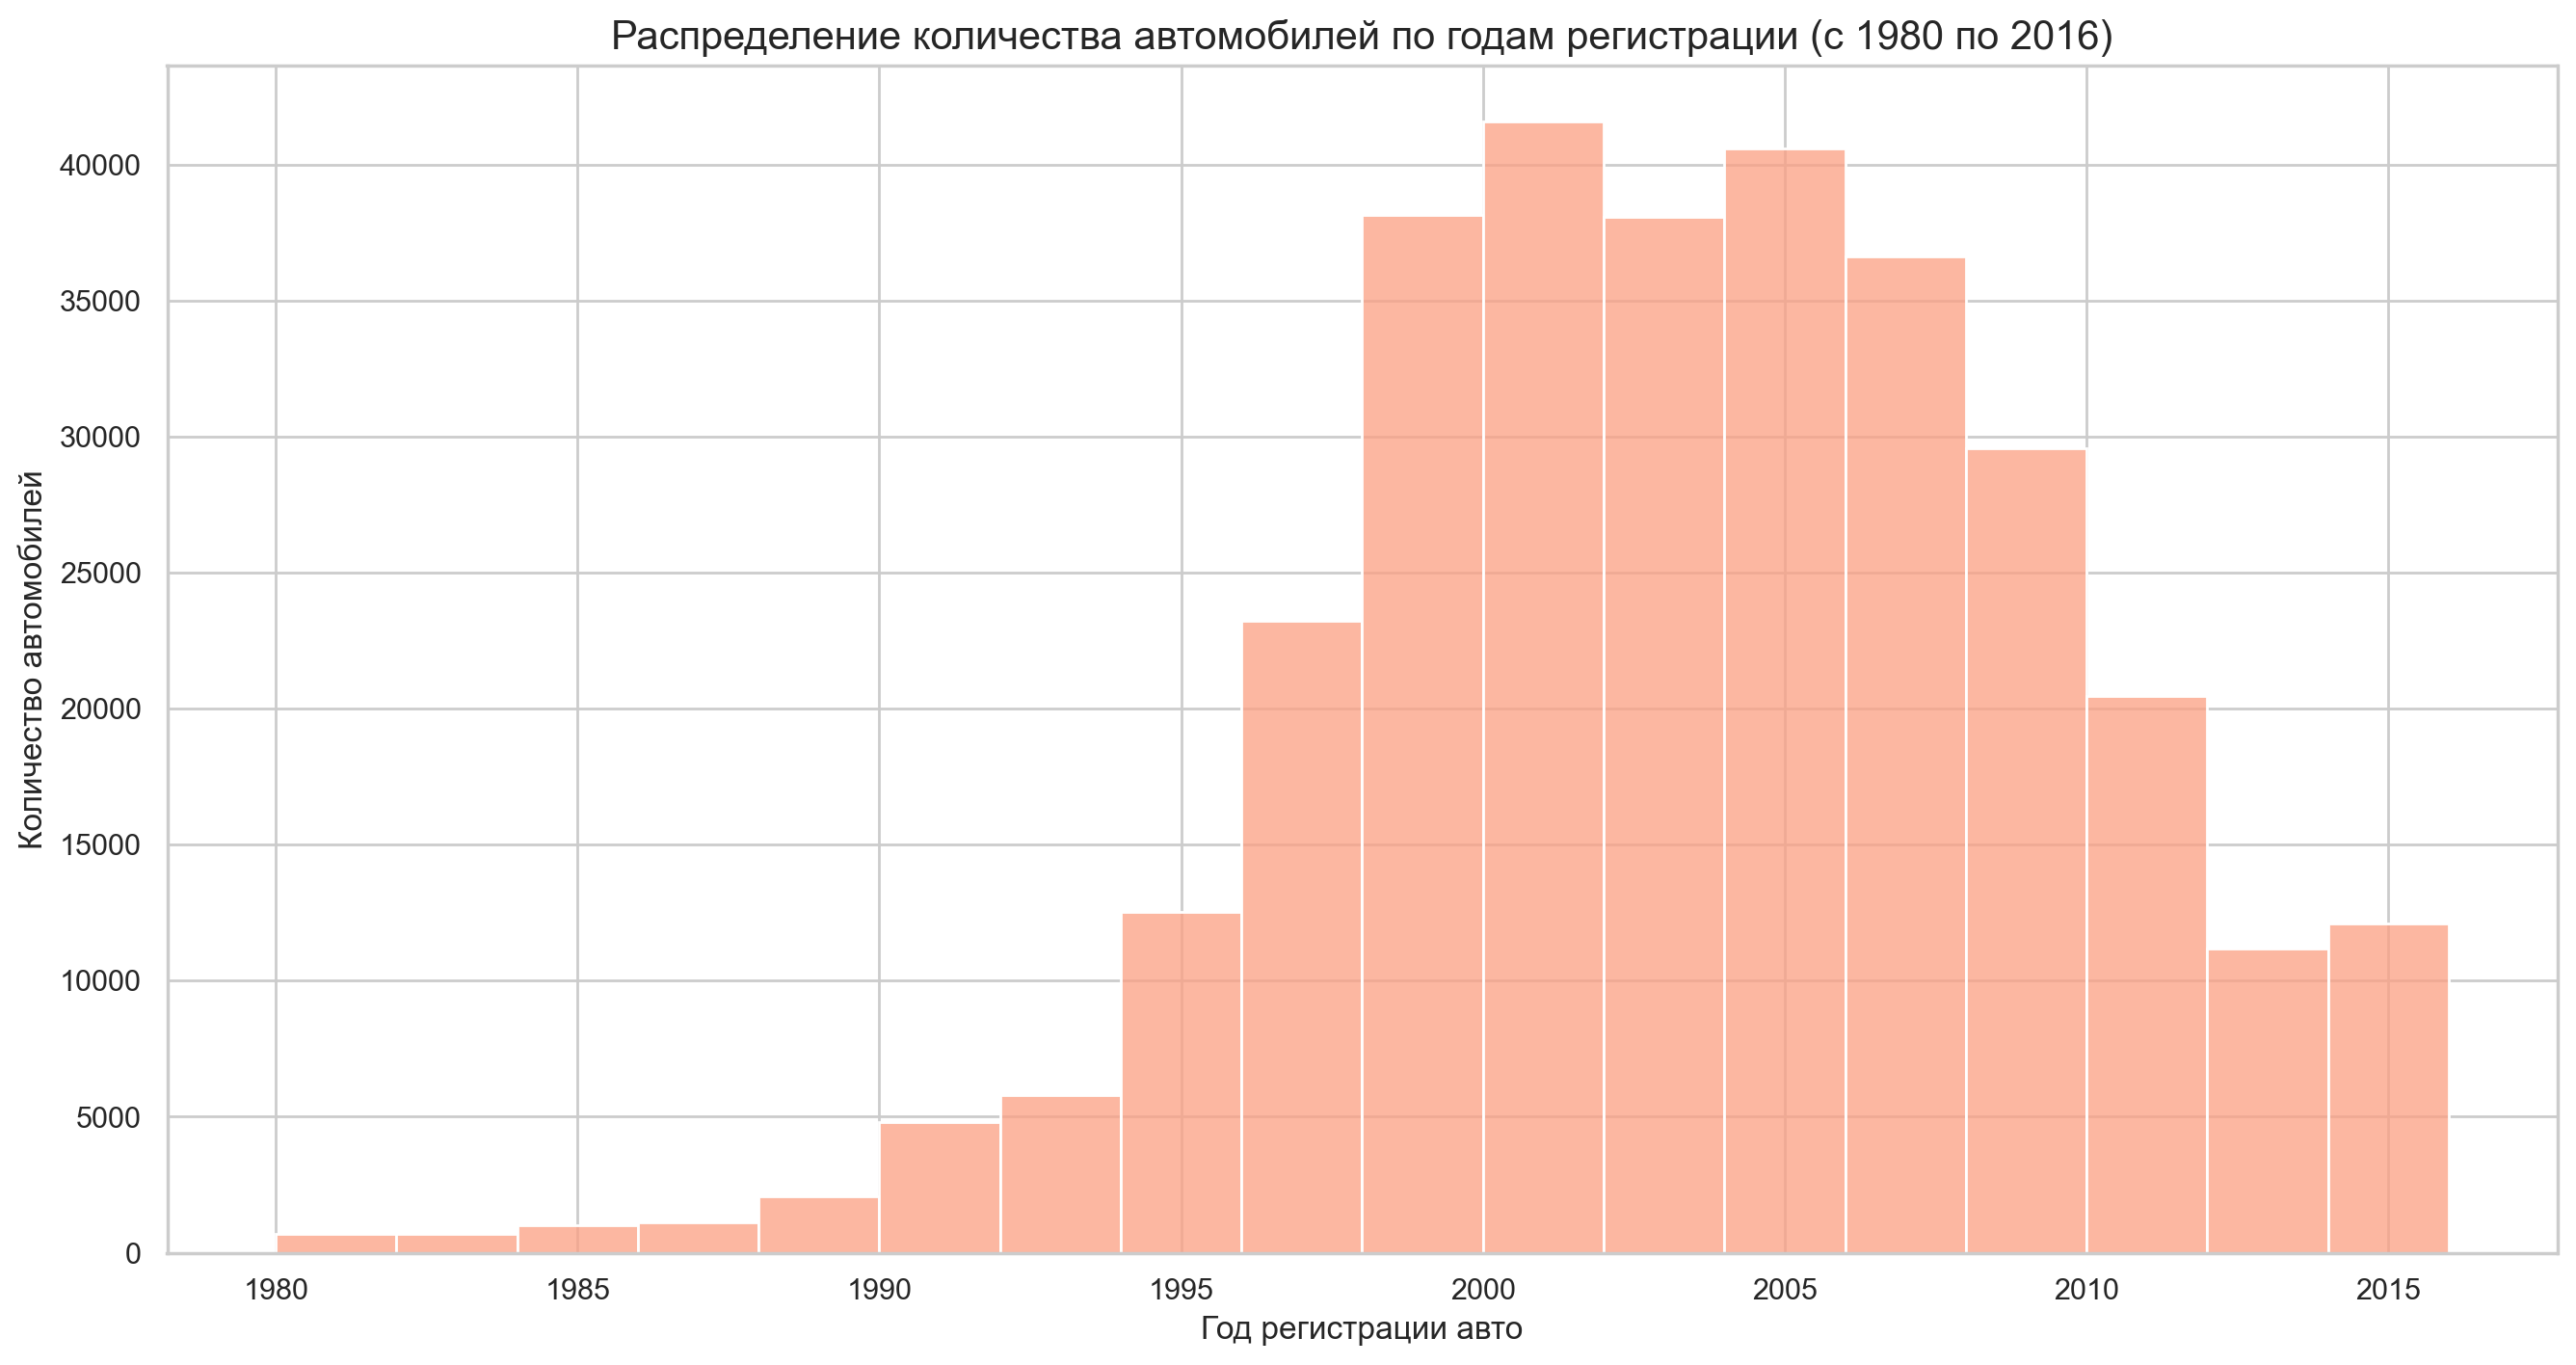

In [21]:
# построим распредление с нижним порогом 1980 год
plt.figure(figsize=(16, 8))
plt.title(f'Распределение количества автомобилей по годам регистрации (с 1980 по {year_last})', fontsize=15)
sns.histplot(
    data.query('registration_year <= @year_last & registration_year >= 1980')['registration_year'], 
    color='#FB9F82', 
    binwidth=2)
plt.xlabel('Год регистрации авто', fontsize=12)
plt.ylabel('Количество автомобилей', fontsize=12)
plt.show()

In [22]:
#очистим данные от строк с годом выше 2016 и ниже 1980
print('Количество строк к удалению:', \
      data.query('registration_year > @year_last | registration_year < 1980')['registration_year']\
     .count())
data = data.query('registration_year <= @year_last & registration_year >= 1980')

Количество строк к удалению: 16651


**3. Мощность:**

В признаке с мощностями автомобиля наблюдаем аномалии (0 или 20000). Нужно определить границы выбросов и очистить данные от ненужных строк.

In [23]:
#посмотрим на значения мощности автомобилей
data['power'].describe()

count   320,256.00
mean        113.39
std         183.33
min           0.00
25%          75.00
50%         105.00
75%         143.00
max      20,000.00
Name: power, dtype: float64

In [24]:
print(data.query('power == 0')['power'].count())

29407


In [25]:
# имеем много строк с нулевой мощностью, можно заменить медианным значением 
data.loc[data['power'] == 0, 'power'] = np.nan
data['power'] = data['power'].fillna(data.groupby('car_brand')['power'].transform('median')).astype('int')

In [26]:
print(data['power'].isna().sum())

0


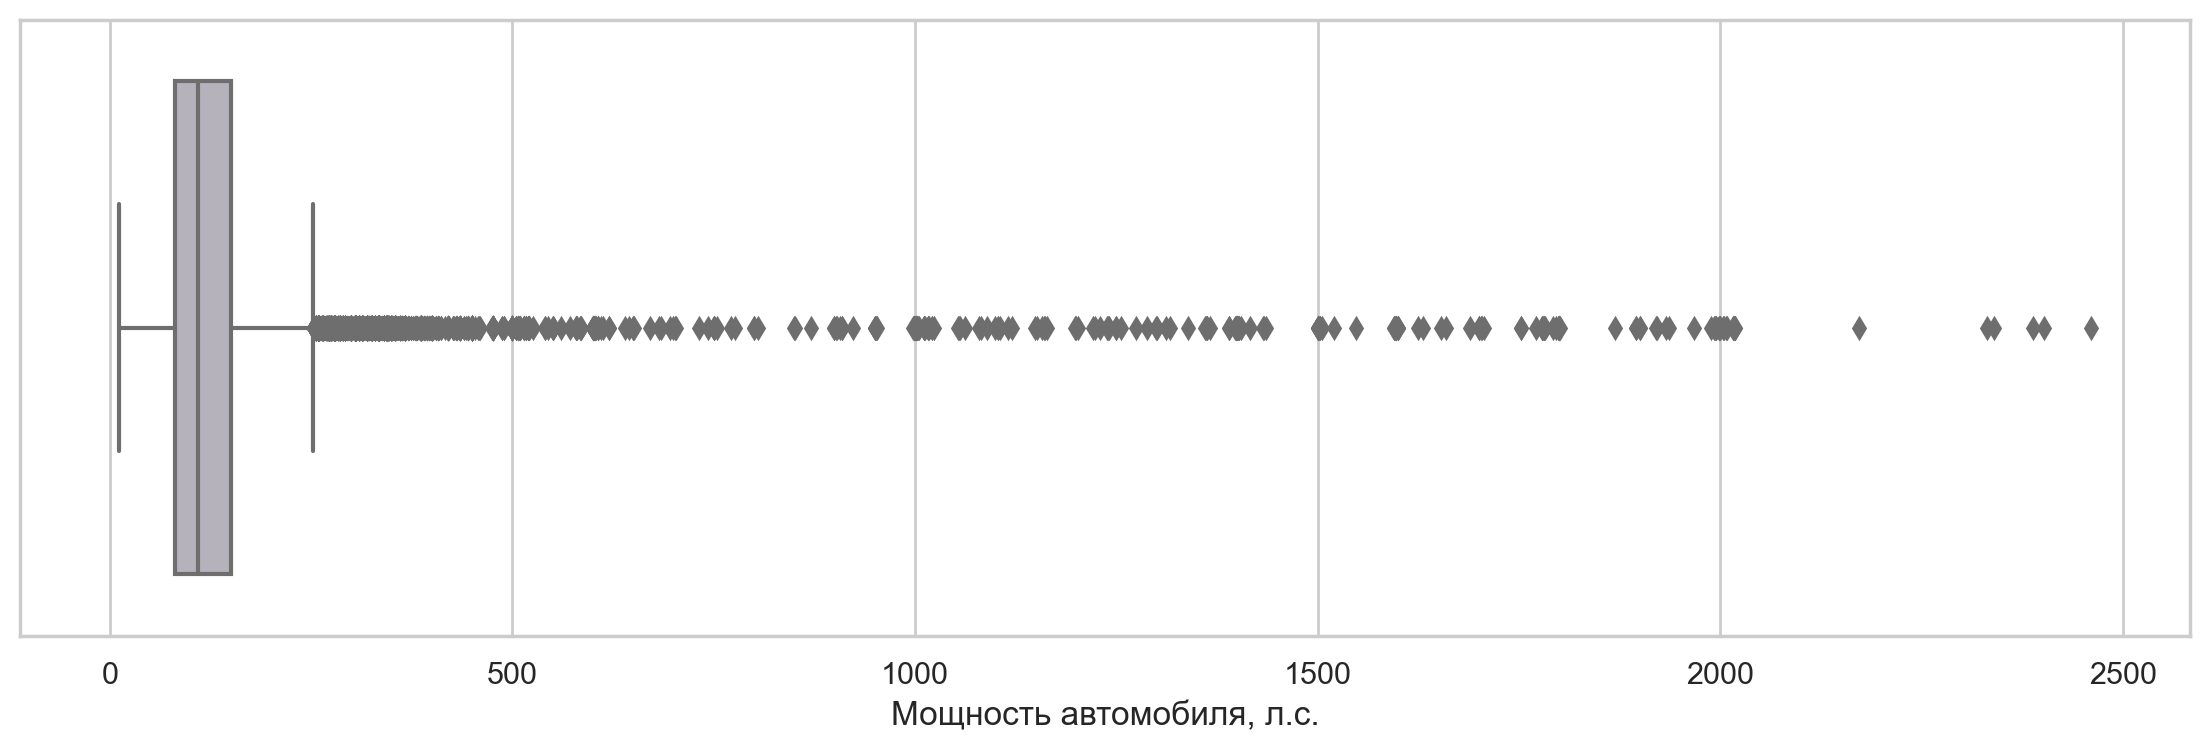

In [27]:
# построим boxplot, чтобы увидеть выбросы
plt.figure(figsize=(14, 4))
sns.boxplot(x=data.query('power > 10 & power < 2500')['power'], color='#B4B0BE')
plt.xlabel('Мощность автомобиля, л.с.', fontsize=12)
plt.show()

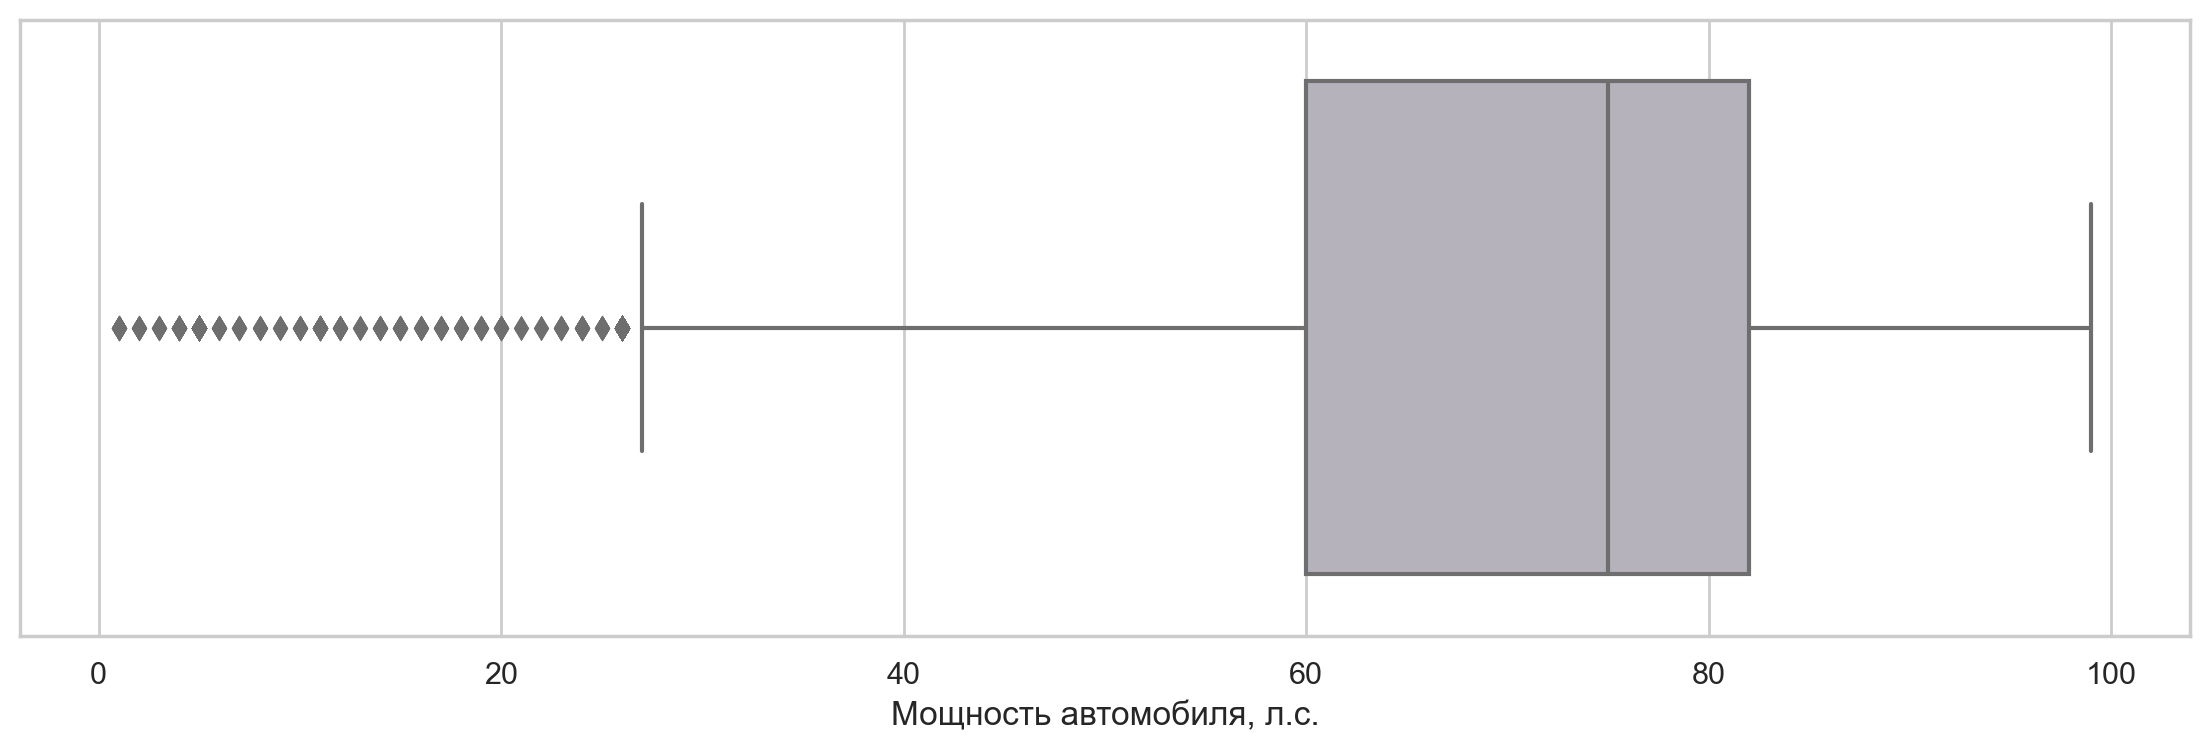

In [28]:
# опрделим нижнюю границу выбросов
plt.figure(figsize=(14, 4))
sns.boxplot(x=data.query('power > 0 & power < 100')['power'], color='#B4B0BE')
plt.xlabel('Мощность автомобиля, л.с.', fontsize=12)
plt.show()

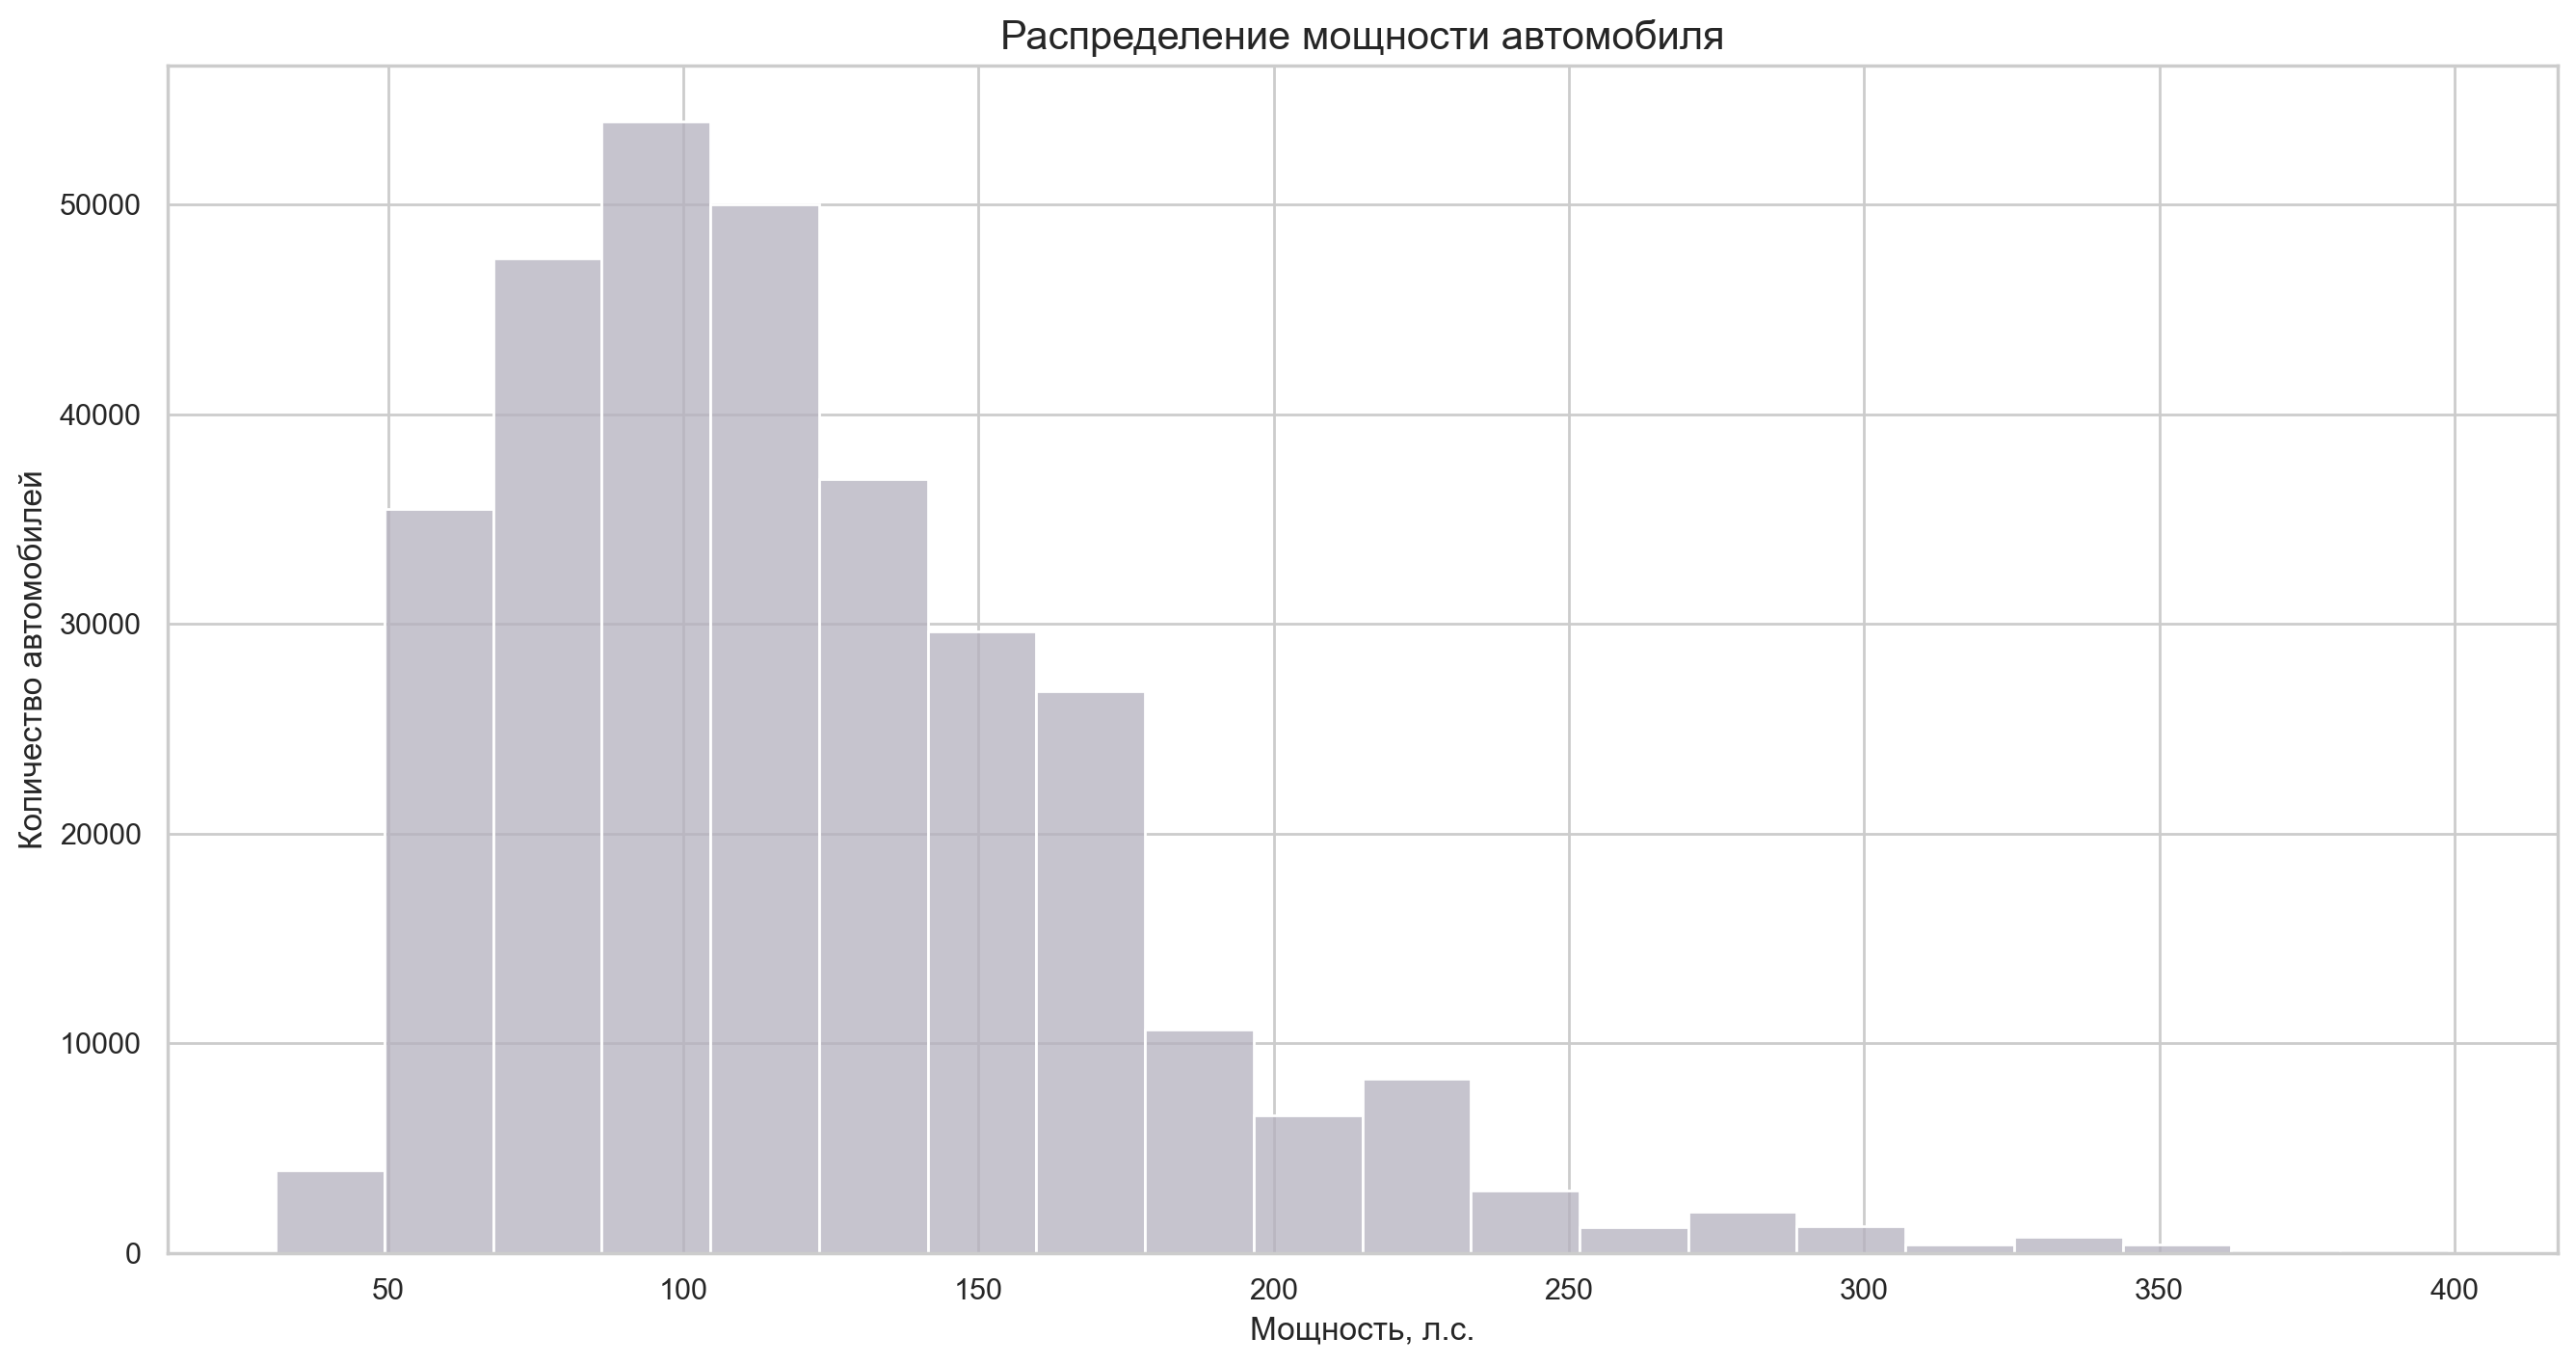

In [29]:
# построим распредление по мощности от 30 до 400 л.с.
plt.figure(figsize=(16, 8))
plt.title('Распределение мощности автомобиля', fontsize=15)
sns.histplot(
    data.query('power > 30 & power < 400')['power'], 
    color='#B4B0BE', 
    bins=20)
plt.xlabel('Мощность, л.с.', fontsize=12)
plt.ylabel('Количество автомобилей', fontsize=12)
plt.show()

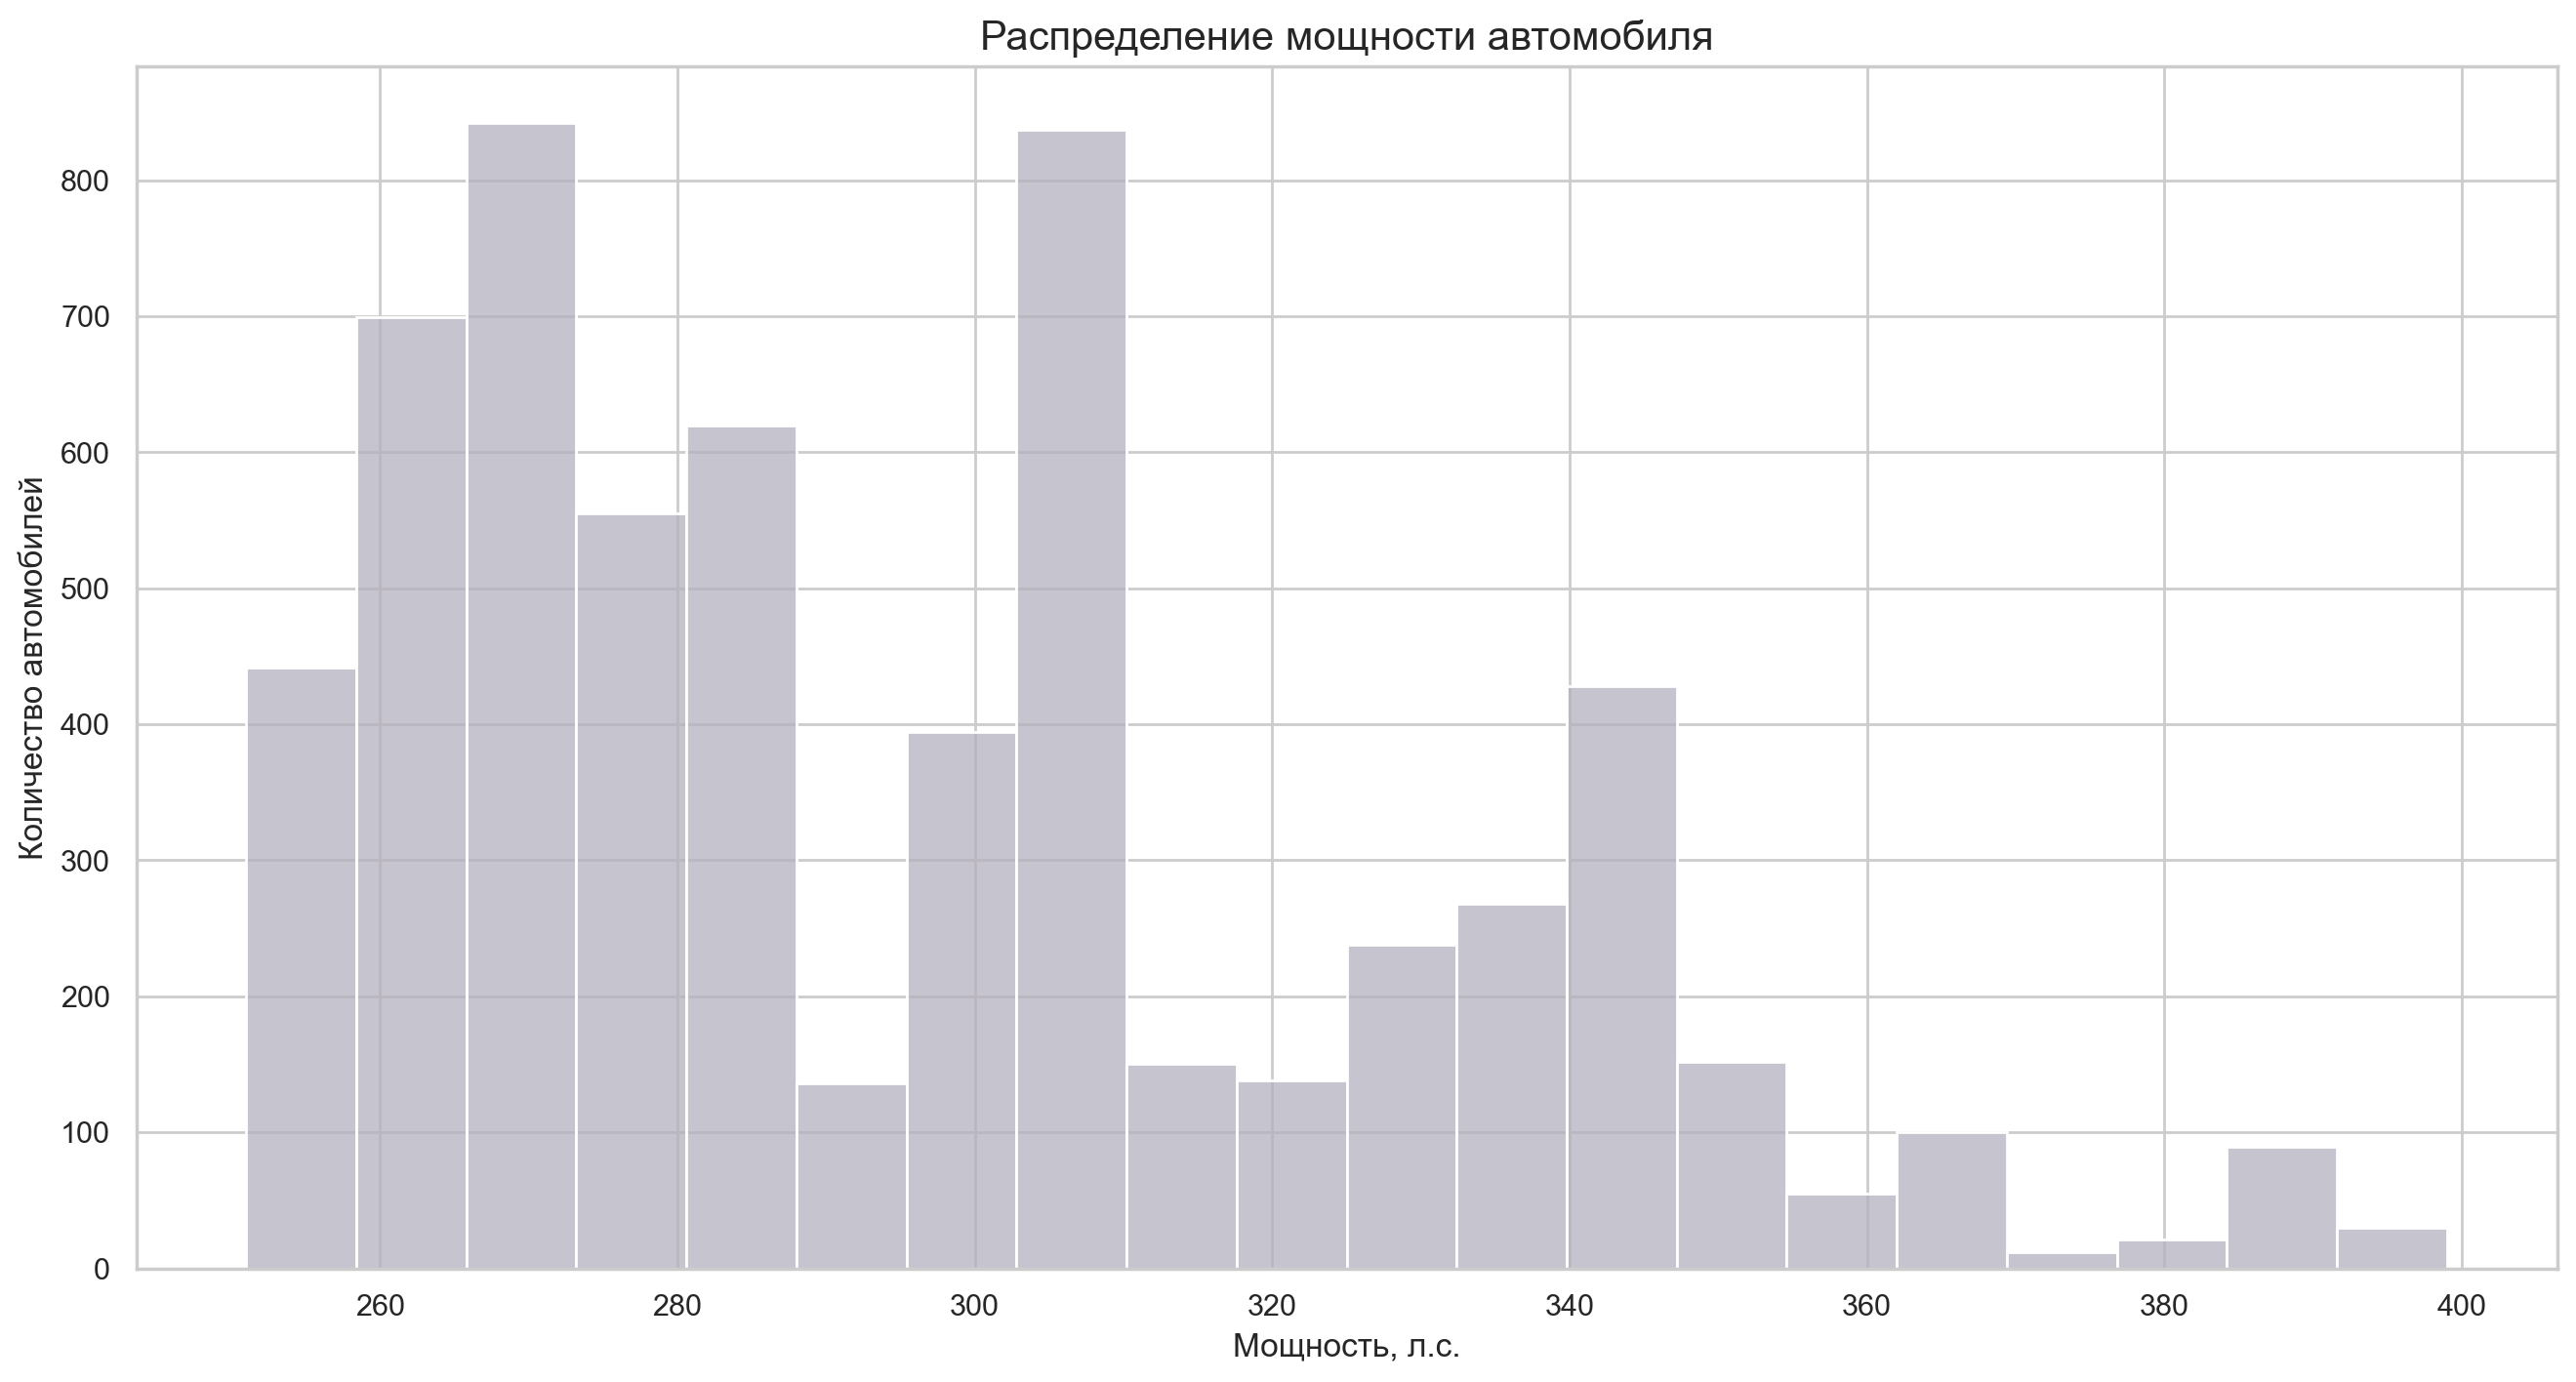

In [30]:
# построим распредление по мощности от 250 до 400 л.с.
plt.figure(figsize=(16, 8))
plt.title('Распределение мощности автомобиля', fontsize=15)
sns.histplot(
    data.query('power > 250 & power < 400')['power'], 
    color='#B4B0BE', 
    bins=20)
plt.xlabel('Мощность, л.с.', fontsize=12)
plt.ylabel('Количество автомобилей', fontsize=12)
plt.show()

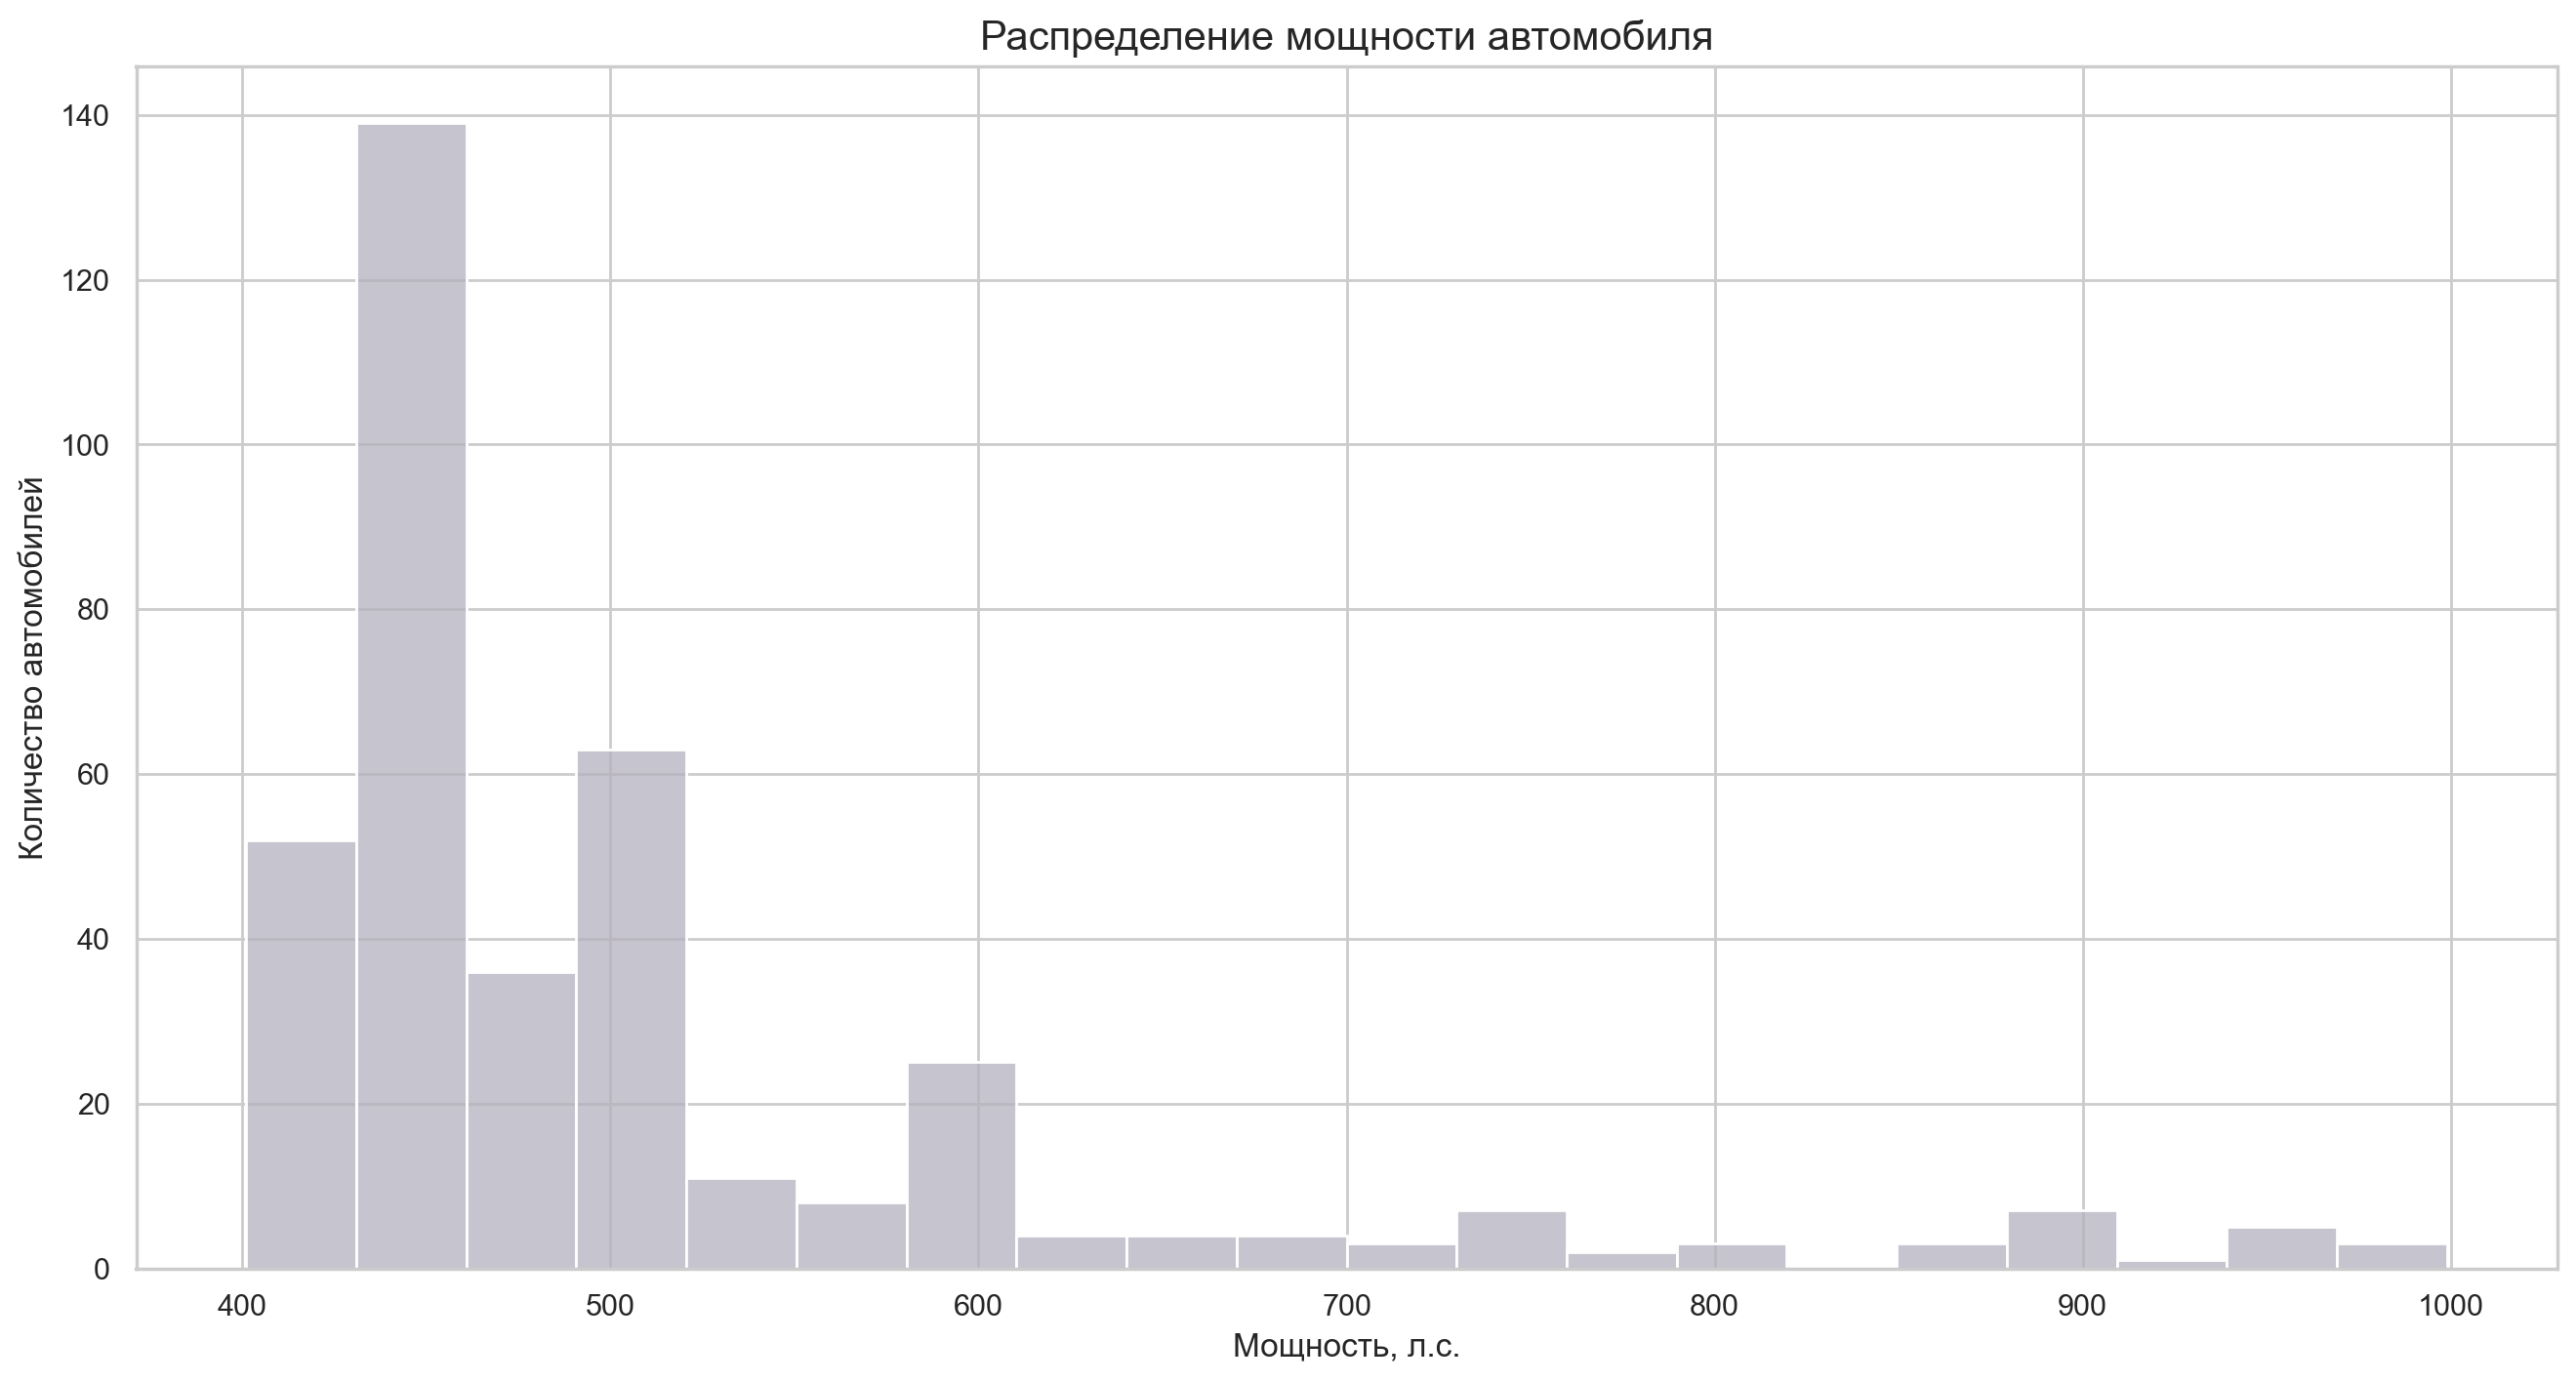

In [31]:
# построим распредление по мощности от 400 до 1000 л.с.
plt.figure(figsize=(16, 8))
plt.title('Распределение мощности автомобиля', fontsize=15)
sns.histplot(
    data.query('power > 400 & power < 1000')['power'], 
    color='#B4B0BE', 
    bins=20)
plt.xlabel('Мощность, л.с.', fontsize=12)
plt.ylabel('Количество автомобилей', fontsize=12)
plt.show()

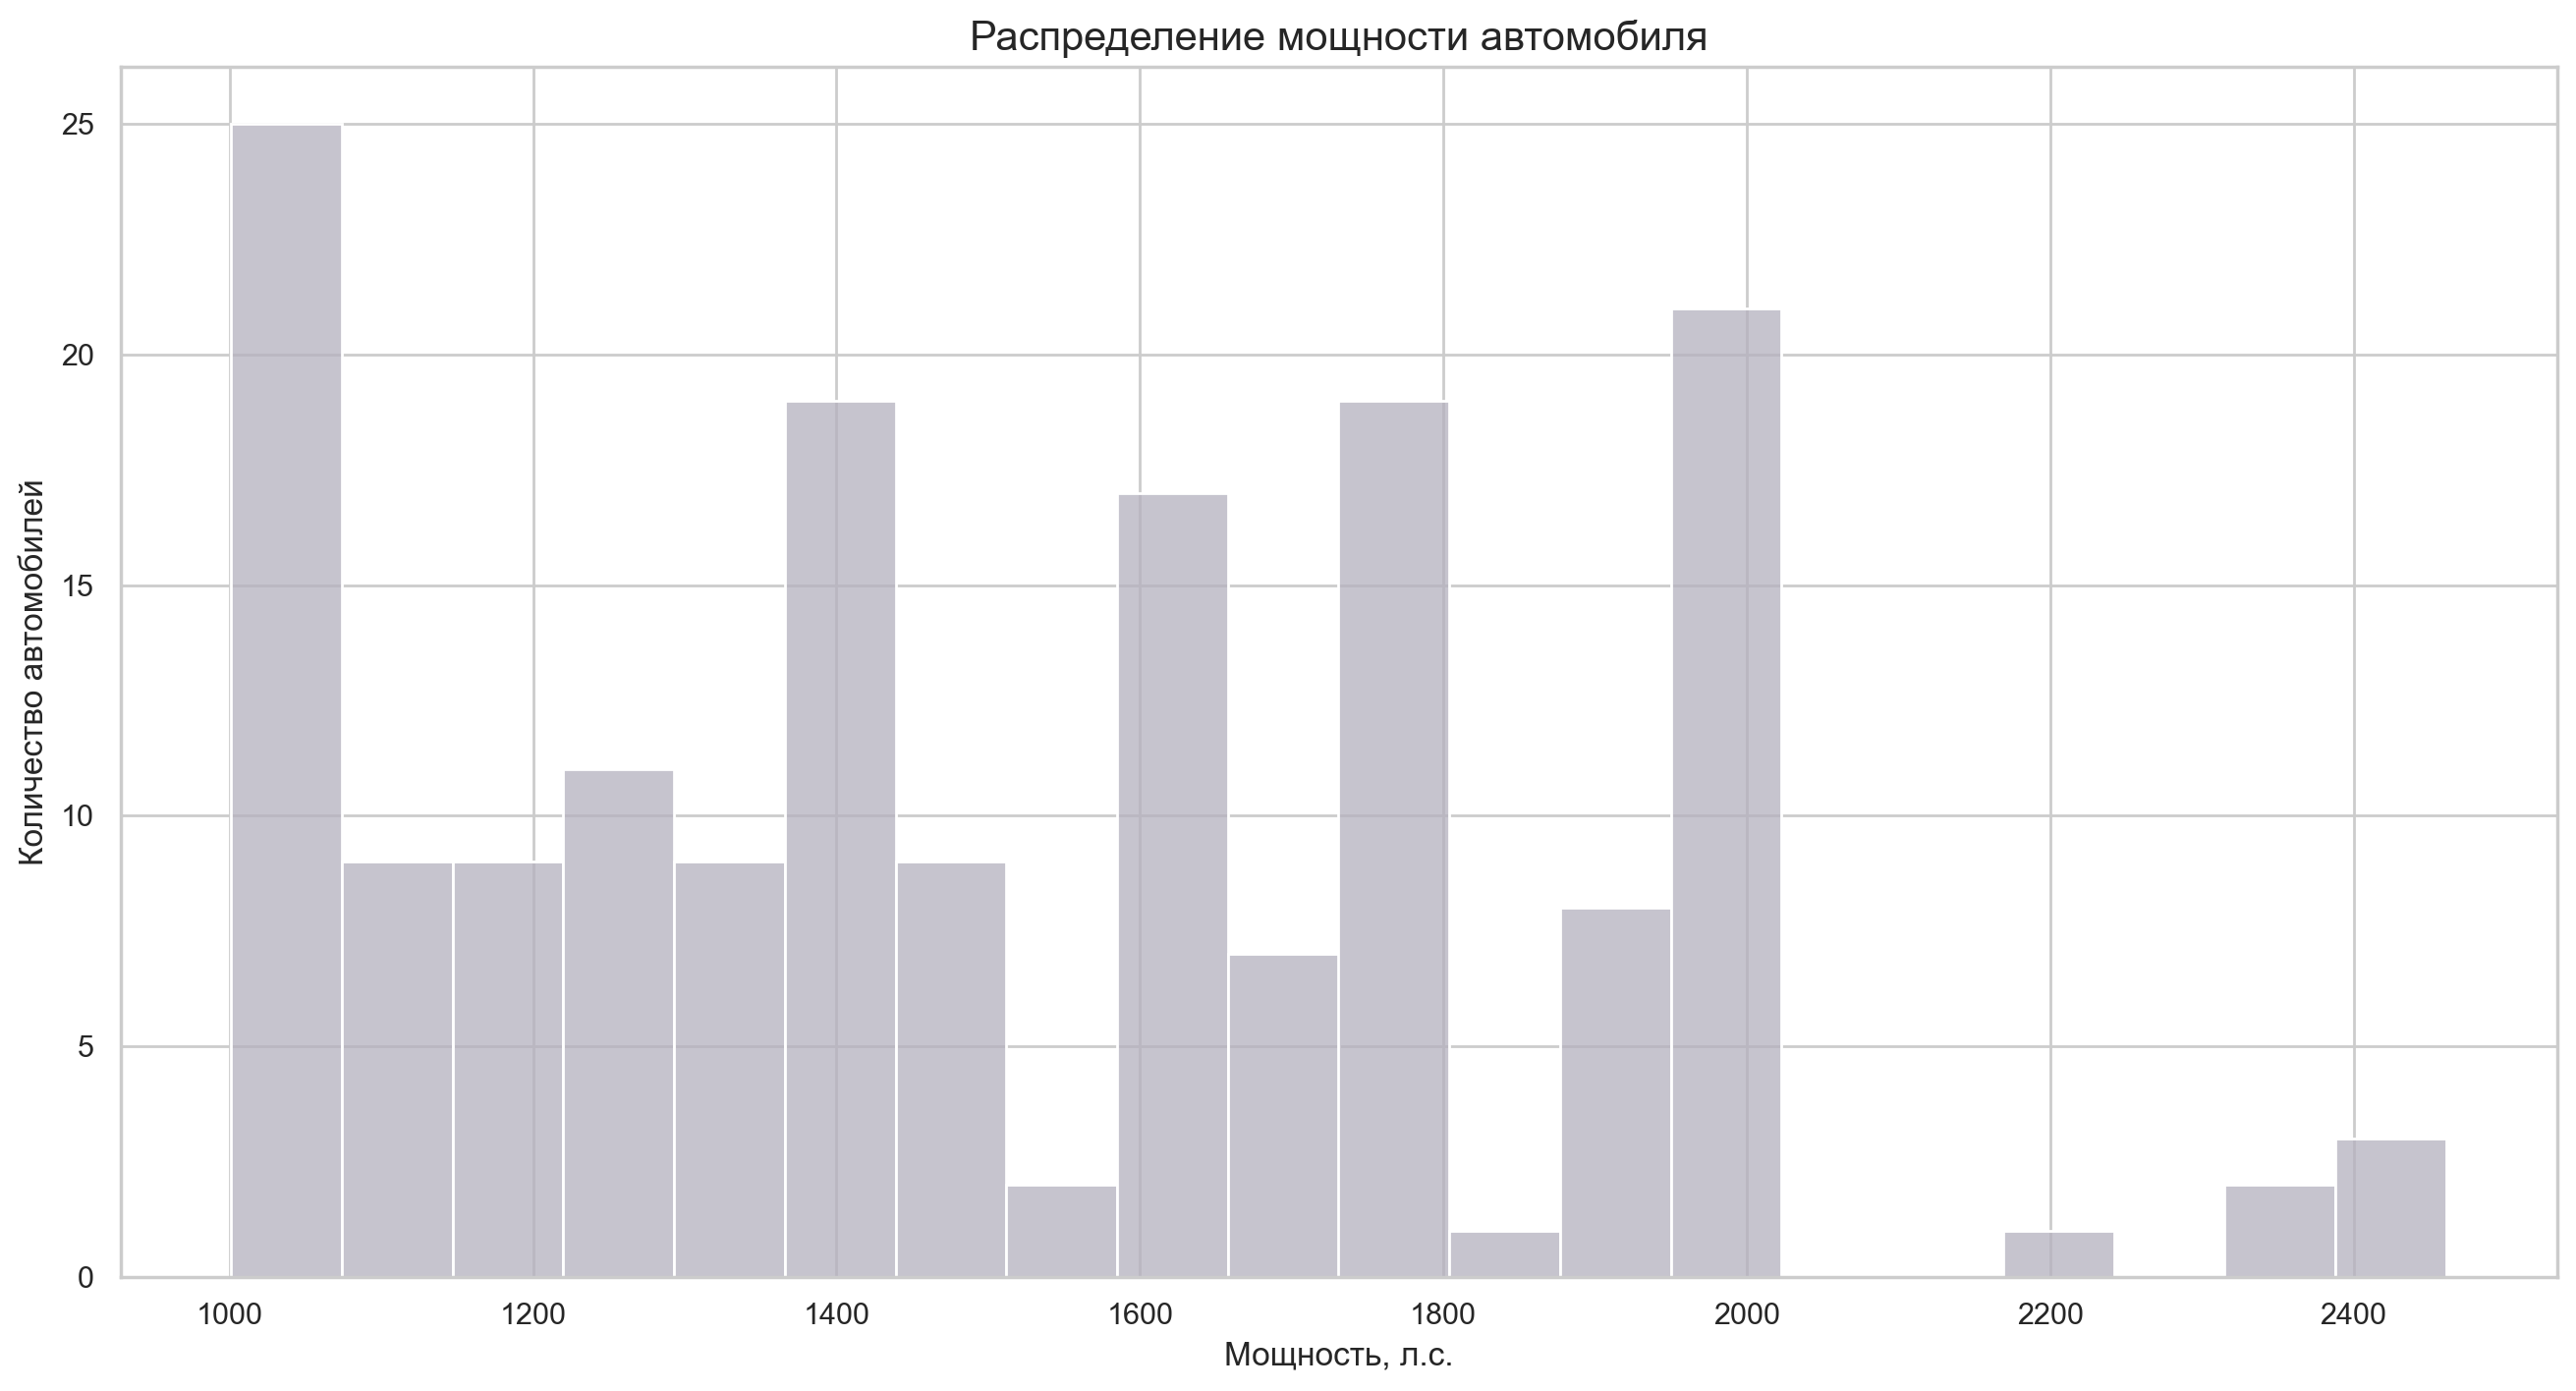

In [32]:
# построим распредление по мощности от 1000 до 2500 л.с.
plt.figure(figsize=(16, 8))
plt.title('Распределение мощности автомобиля', fontsize=15)
sns.histplot(
    data.query('power > 1000 & power < 2500')['power'], 
    color='#B4B0BE', 
    bins=20)
plt.xlabel('Мощность, л.с.', fontsize=12)
plt.ylabel('Количество автомобилей', fontsize=12)
plt.show()

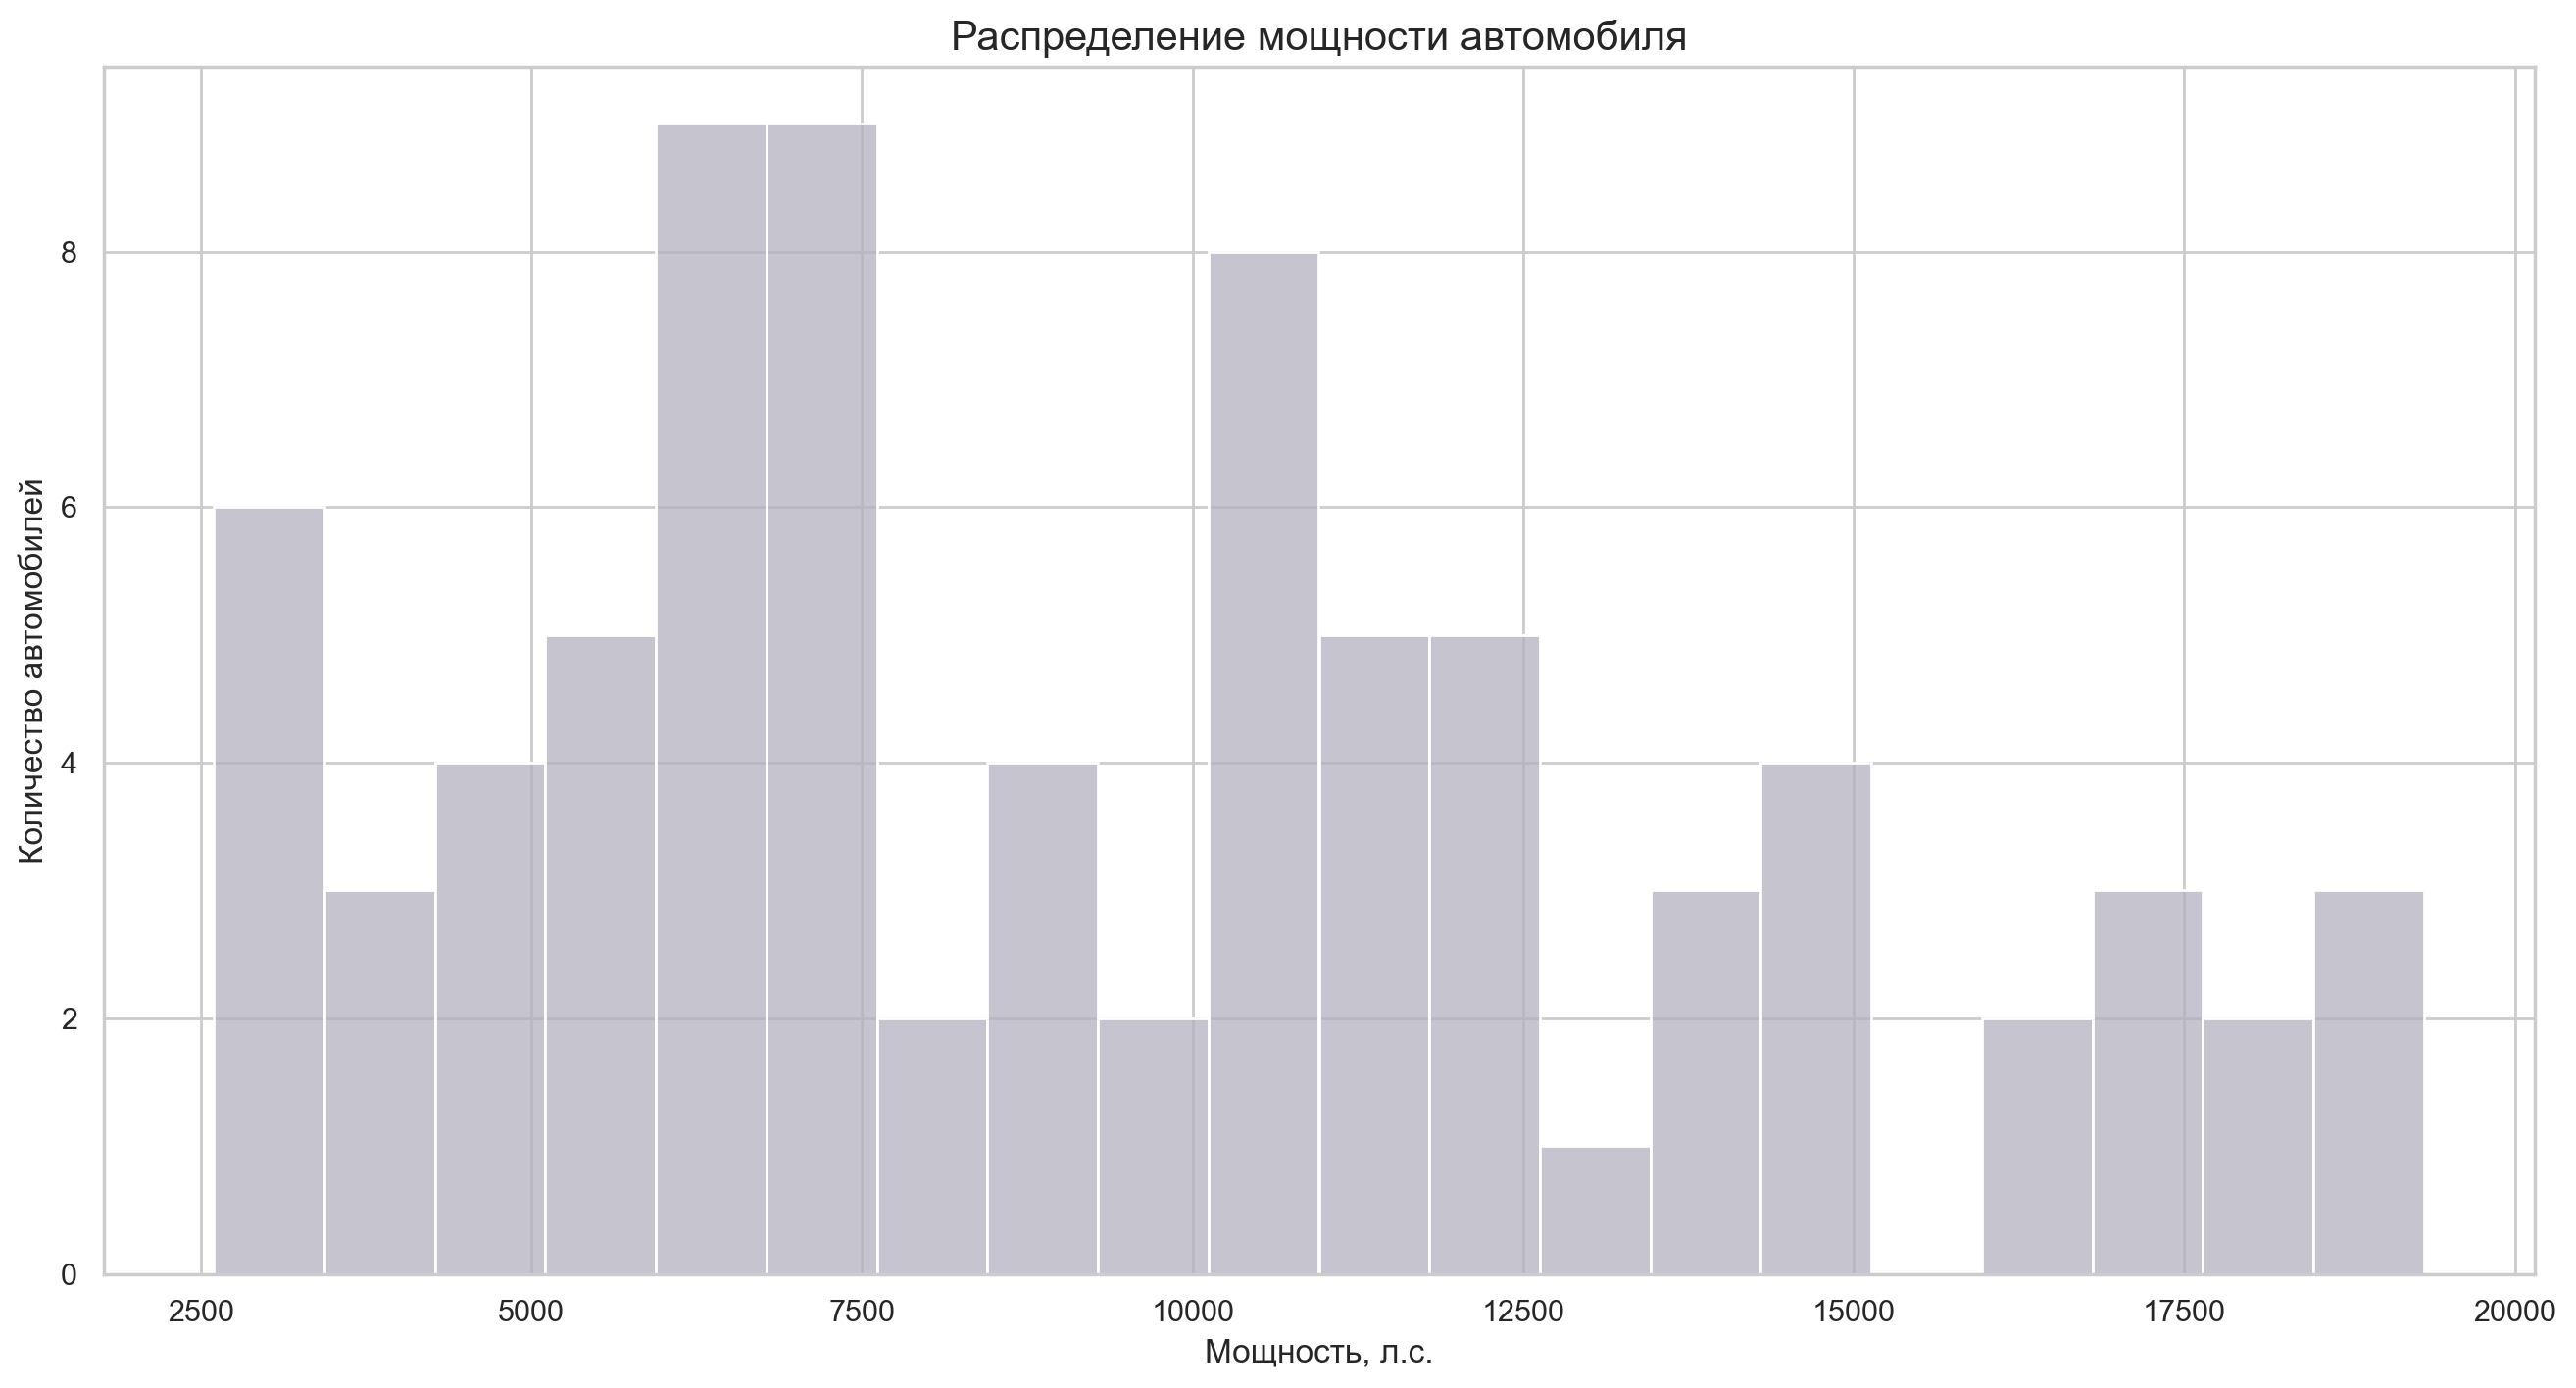

In [33]:
# построим распредление по мощности от 1000 до 2500 л.с.
plt.figure(figsize=(16, 8))
plt.title('Распределение мощности автомобиля', fontsize=15)
sns.histplot(
    data.query('power > 2500 & power < 20000')['power'], 
    color='#B4B0BE', 
    bins=20)
plt.xlabel('Мощность, л.с.', fontsize=12)
plt.ylabel('Количество автомобилей', fontsize=12)
plt.show()

In [34]:
# очистим данные от строк с мощностью выше 1000 и ниже 30
print('Количество строк к удалению:', \
      data\
      .query('power <= 30 | power >= 1000')['power']\
      .count())
data = data.query('power > 30 & power < 1000')

Количество строк к удалению: 989


**Вывод:**

- Стоимость автомобиля. Оставили автомобили стоимостью выше 200 евро. Нас не интересуют автомобили с обменом или продажи автомобиля на запчасти. Такие данные могут сильно исказить предсказания модели.
- Год регистрации автомобиля. Удалили строки, где год регистрации выше самого позднего года создания анкеты и меньше 1980.
- Мощность автомобиля. Удалили строки с мощностью выше 1000 л.с. и меньше 30 л.с. 

### Обработка пропущенных значений

Обработаем пропущенные значения в признаках: ремонт автомобиля, тип топлива, тип кузова, тип коробки передач и модель автомобиля.

In [35]:
# еще раз выведем процент пропущенных значений в каждом столбце
data.isna().sum().sort_values(ascending=False) \
    / data.shape[0] * 100

repaired             17.36
fuel_type             6.68
vehicle_type          5.46
car_model             4.32
gear_box              4.15
date_crawled          0.00
car_price             0.00
registration_year     0.00
power                 0.00
kilometers            0.00
registration_month    0.00
car_brand             0.00
ad_created            0.00
number_of_pictures    0.00
postal_code           0.00
last_seen             0.00
dtype: float64

**1. Был ли автомобиль в ремонте:**

В столбце `repaired` наблюдаем значительное количество пропусков (17%). ЧТобы не терять такой объем данных заменим пропуски на значение "unknown".

In [36]:
# количество пропусков
print('Наличие пропусков в столбце repaired =', data.repaired.isna().sum() / data.shape[0] * 100, '%')

Наличие пропусков в столбце repaired = 17.362583668215002 %


In [37]:
# посмотрим какие значения хранятся в столбце
data.repaired.unique().tolist()

[nan, 'yes', 'no']

In [38]:
# заменим пропуски на "unknown"
data['repaired']=data['repaired'].fillna('unknown')
data.repaired.unique().tolist()

['unknown', 'yes', 'no']

**2. Тип топлива:**

В столбце `fuel_type` наблюдаем умеренное количество пропусков (7%). Чтобы не терять такой объем данных заменим пропуски на моду признака.

In [39]:
# количество пропусков
print('Наличие пропусков в столбце fuel_type =', data.fuel_type.isna().sum() / data.shape[0] * 100, '%')

Наличие пропусков в столбце fuel_type = 6.68312102409582 %


In [40]:
# посмотрим какие значения хранятся в столбце
data.fuel_type.value_counts()

fuel_type
petrol      197855
gasoline     94219
lpg           4981
cng            523
hybrid         218
other           87
electric        47
Name: count, dtype: int64

In [41]:
# заменим пропуски на моду признака
data['fuel_type'] = data['fuel_type'].fillna(data['fuel_type'].mode()[0])
data.fuel_type.value_counts()

fuel_type
petrol      219192
gasoline     94219
lpg           4981
cng            523
hybrid         218
other           87
electric        47
Name: count, dtype: int64

**3. Тип кузова:**

В столбце `vehicle_type` наблюдаем умеренное количество пропусков (5%). Чnобы не терять данные заменим пропуски на значение "other".

In [42]:
# количество пропусков
print('Наличие пропусков в столбце vehicle_type =', data.vehicle_type.isna().sum() / data.shape[0] * 100, '%')

Наличие пропусков в столбце vehicle_type = 5.460633263068216 %


In [43]:
# посмотрим какие значения хранятся в столбце
data.vehicle_type.value_counts()

vehicle_type
sedan          87304
small          75061
wagon          62898
bus            28052
convertible    19304
coupe          14870
suv            11567
other           2777
Name: count, dtype: int64

In [44]:
# заменим пропуски на значение "other"
data['vehicle_type'] = data['vehicle_type'].fillna('other')
data.vehicle_type.value_counts()

vehicle_type
sedan          87304
small          75061
wagon          62898
bus            28052
other          20211
convertible    19304
coupe          14870
suv            11567
Name: count, dtype: int64

**4. Тип коробки передач:**

В столбце `gear_box` наблюдаем умеренное количество пропусков (4%). Чnобы не терять данные заменим пропуски на значение "unknown".

In [45]:
# количество пропусков
print('Наличие пропусков в столбце gear_box =', data.gear_box.isna().sum() / data.shape[0] * 100, '%')

Наличие пропусков в столбце gear_box = 4.153890004291079 %


In [46]:
# посмотрим какие значения хранятся в столбце
data.gear_box.value_counts()

gear_box
manual    244217
auto       61788
Name: count, dtype: int64

In [47]:
# заменим пропуски на значение "unknown"
data['gear_box'] = data['gear_box'].fillna('unknown')
data.gear_box.value_counts()

gear_box
manual     244217
auto        61788
unknown     13262
Name: count, dtype: int64

**5. Модель автомобиля:**

Модель - это важный признак, который напрямую воздействует на образование цены и заменить его на что-то другое будет неправильно, удалим отсутствующие значения из наших данных.

In [48]:
# количество пропусков
print('Наличие пропусков в столбце car_model =', data.car_model.isna().sum() / data.shape[0] * 100, '%')

Наличие пропусков в столбце car_model = 4.3161366505150855 %


In [49]:
# посмотрим количество уникальных моделей
print('Количество уникальных моделей автомобилей в данных =', data.car_model.nunique())

Количество уникальных моделей автомобилей в данных = 248


In [50]:
# удалим пропущенные значения
data.dropna(subset=['car_model'], inplace=True)
data.car_model.isna().sum()

0

**Вывод:**

- В признаках, содержащих информацию о ремонте автомобиля и типе коробки передач пропущенные значения были заменены на значение "unknown"
- Пропуски в типе кузова заменены на значение "other"
- Отсутствующие значение в типе топлива заменены на моду признака, а в модели автомобиля пропуски были удалены.

### Анализ зависимости целевого признака от других признаков в данных

Проанализируем оставшиеся признаки. Если среди них имеются неинформативные, удалим их.

**1. Обработка дат:**

- `date_crawled` - дата скачивания анкеты из базы. Не несет ценности для обучения модели. Удалим данный признак.
- `last_seen` - дата последней активности пользователя. Не несет ценности для обучения модели. Удалим данный признак.
- `ad_created` - дата создания анкеты. Данные уже приведены к формату datetime.

In [51]:
# обработаем даты
data = data.drop(['date_crawled', 'last_seen'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 305487 entries, 0 to 354368
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   car_price           305487 non-null  int64         
 1   vehicle_type        305487 non-null  object        
 2   registration_year   305487 non-null  int64         
 3   gear_box            305487 non-null  object        
 4   power               305487 non-null  int32         
 5   car_model           305487 non-null  object        
 6   kilometers          305487 non-null  int64         
 7   registration_month  305487 non-null  int64         
 8   fuel_type           305487 non-null  object        
 9   car_brand           305487 non-null  object        
 10  repaired            305487 non-null  object        
 11  ad_created          305487 non-null  datetime64[ns]
 12  number_of_pictures  305487 non-null  int64         
 13  postal_code         305487 non-nul

In [52]:
# создадим новый столбец с годом создания анкеты
data['year_created'] = data['ad_created'].dt.year

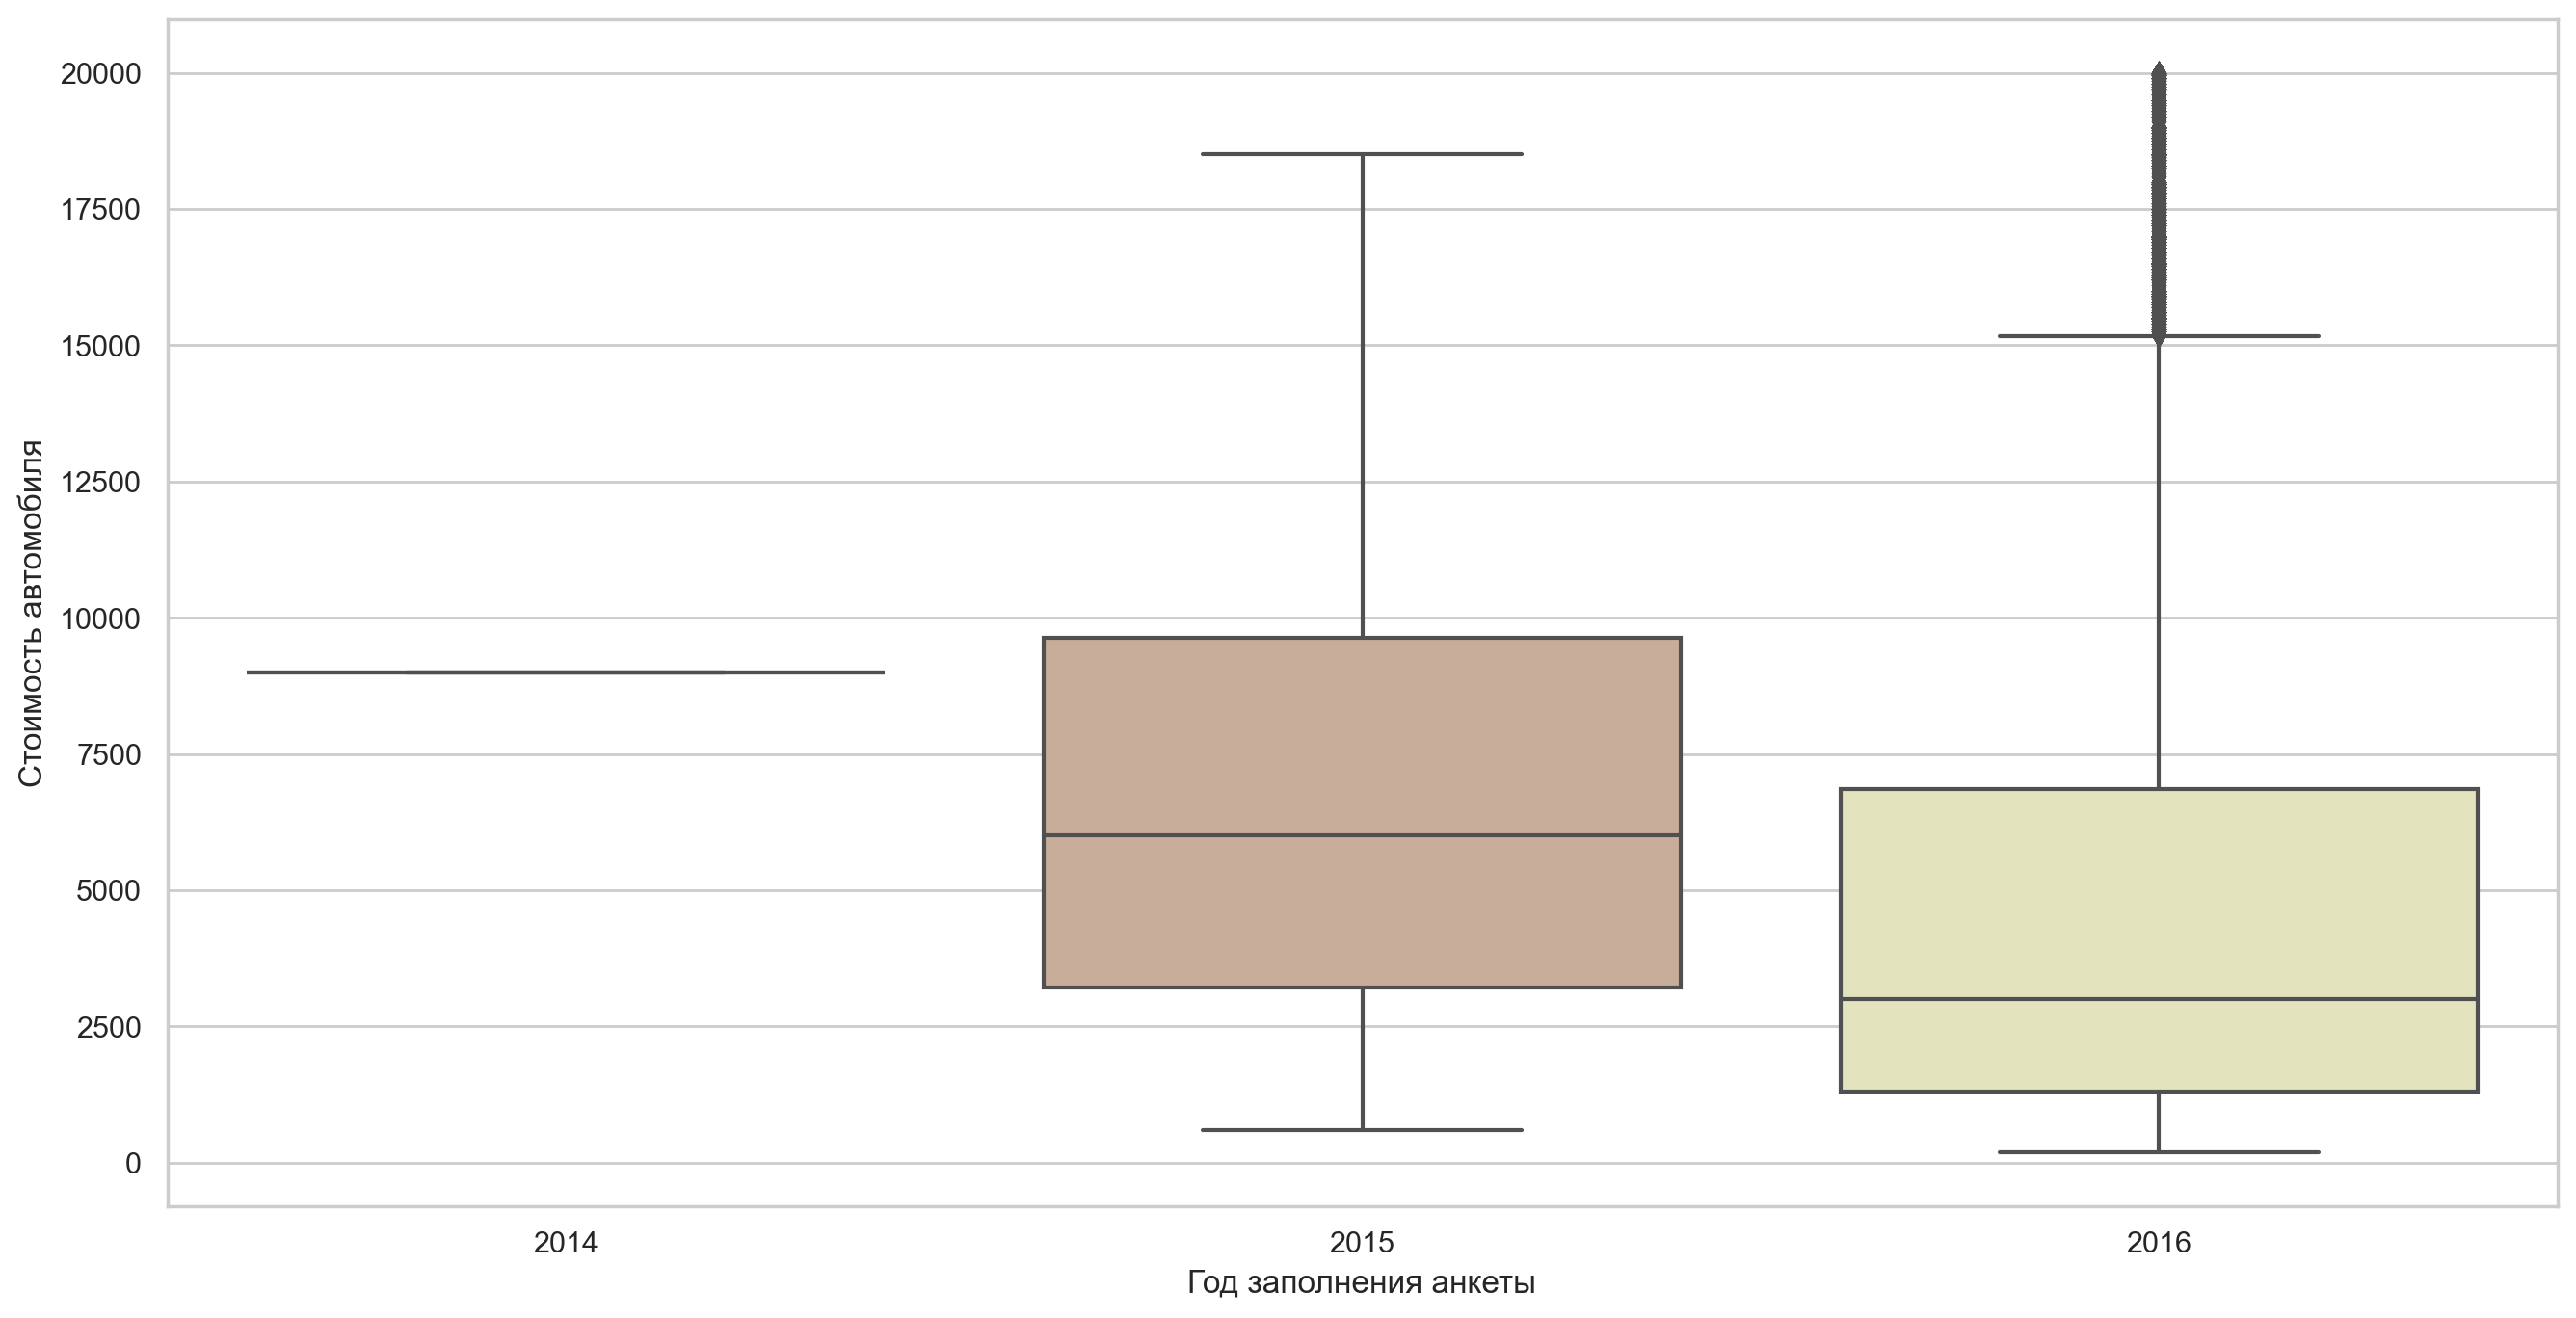

In [53]:
# посмотрим, влияет ли год создания анкеты на целевой признак
plt.figure(figsize=(16, 8))
sns.boxplot(x='year_created', y='car_price', data=data, palette='pink')
plt.xlabel('Год заполнения анкеты', fontsize=12)
plt.ylabel('Стоимость автомобиля', fontsize=12)
plt.show()

In [54]:
# видим, что год создания анкеты оказывает влияние на целевой признак. Удалим дату создания анкеты и оставим год
data = data.drop(['ad_created'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 305487 entries, 0 to 354368
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   car_price           305487 non-null  int64 
 1   vehicle_type        305487 non-null  object
 2   registration_year   305487 non-null  int64 
 3   gear_box            305487 non-null  object
 4   power               305487 non-null  int32 
 5   car_model           305487 non-null  object
 6   kilometers          305487 non-null  int64 
 7   registration_month  305487 non-null  int64 
 8   fuel_type           305487 non-null  object
 9   car_brand           305487 non-null  object
 10  repaired            305487 non-null  object
 11  number_of_pictures  305487 non-null  int64 
 12  postal_code         305487 non-null  int64 
 13  year_created        305487 non-null  int32 
dtypes: int32(2), int64(6), object(6)
memory usage: 32.6+ MB


**2. Количество фотографий автомобиля:**

Признак не несет полезной информации (все значения 0). Удалим данный признак.

In [55]:
#удалим 'number_of_pictures' из таблицы
display(data['number_of_pictures'].unique())
data = data.drop(['number_of_pictures'], axis=1)

array([0], dtype=int64)

**3. Месяц регистрации автомобиля:**

Признак не несет полезной информации для обучения модели. Удалим данный признак.

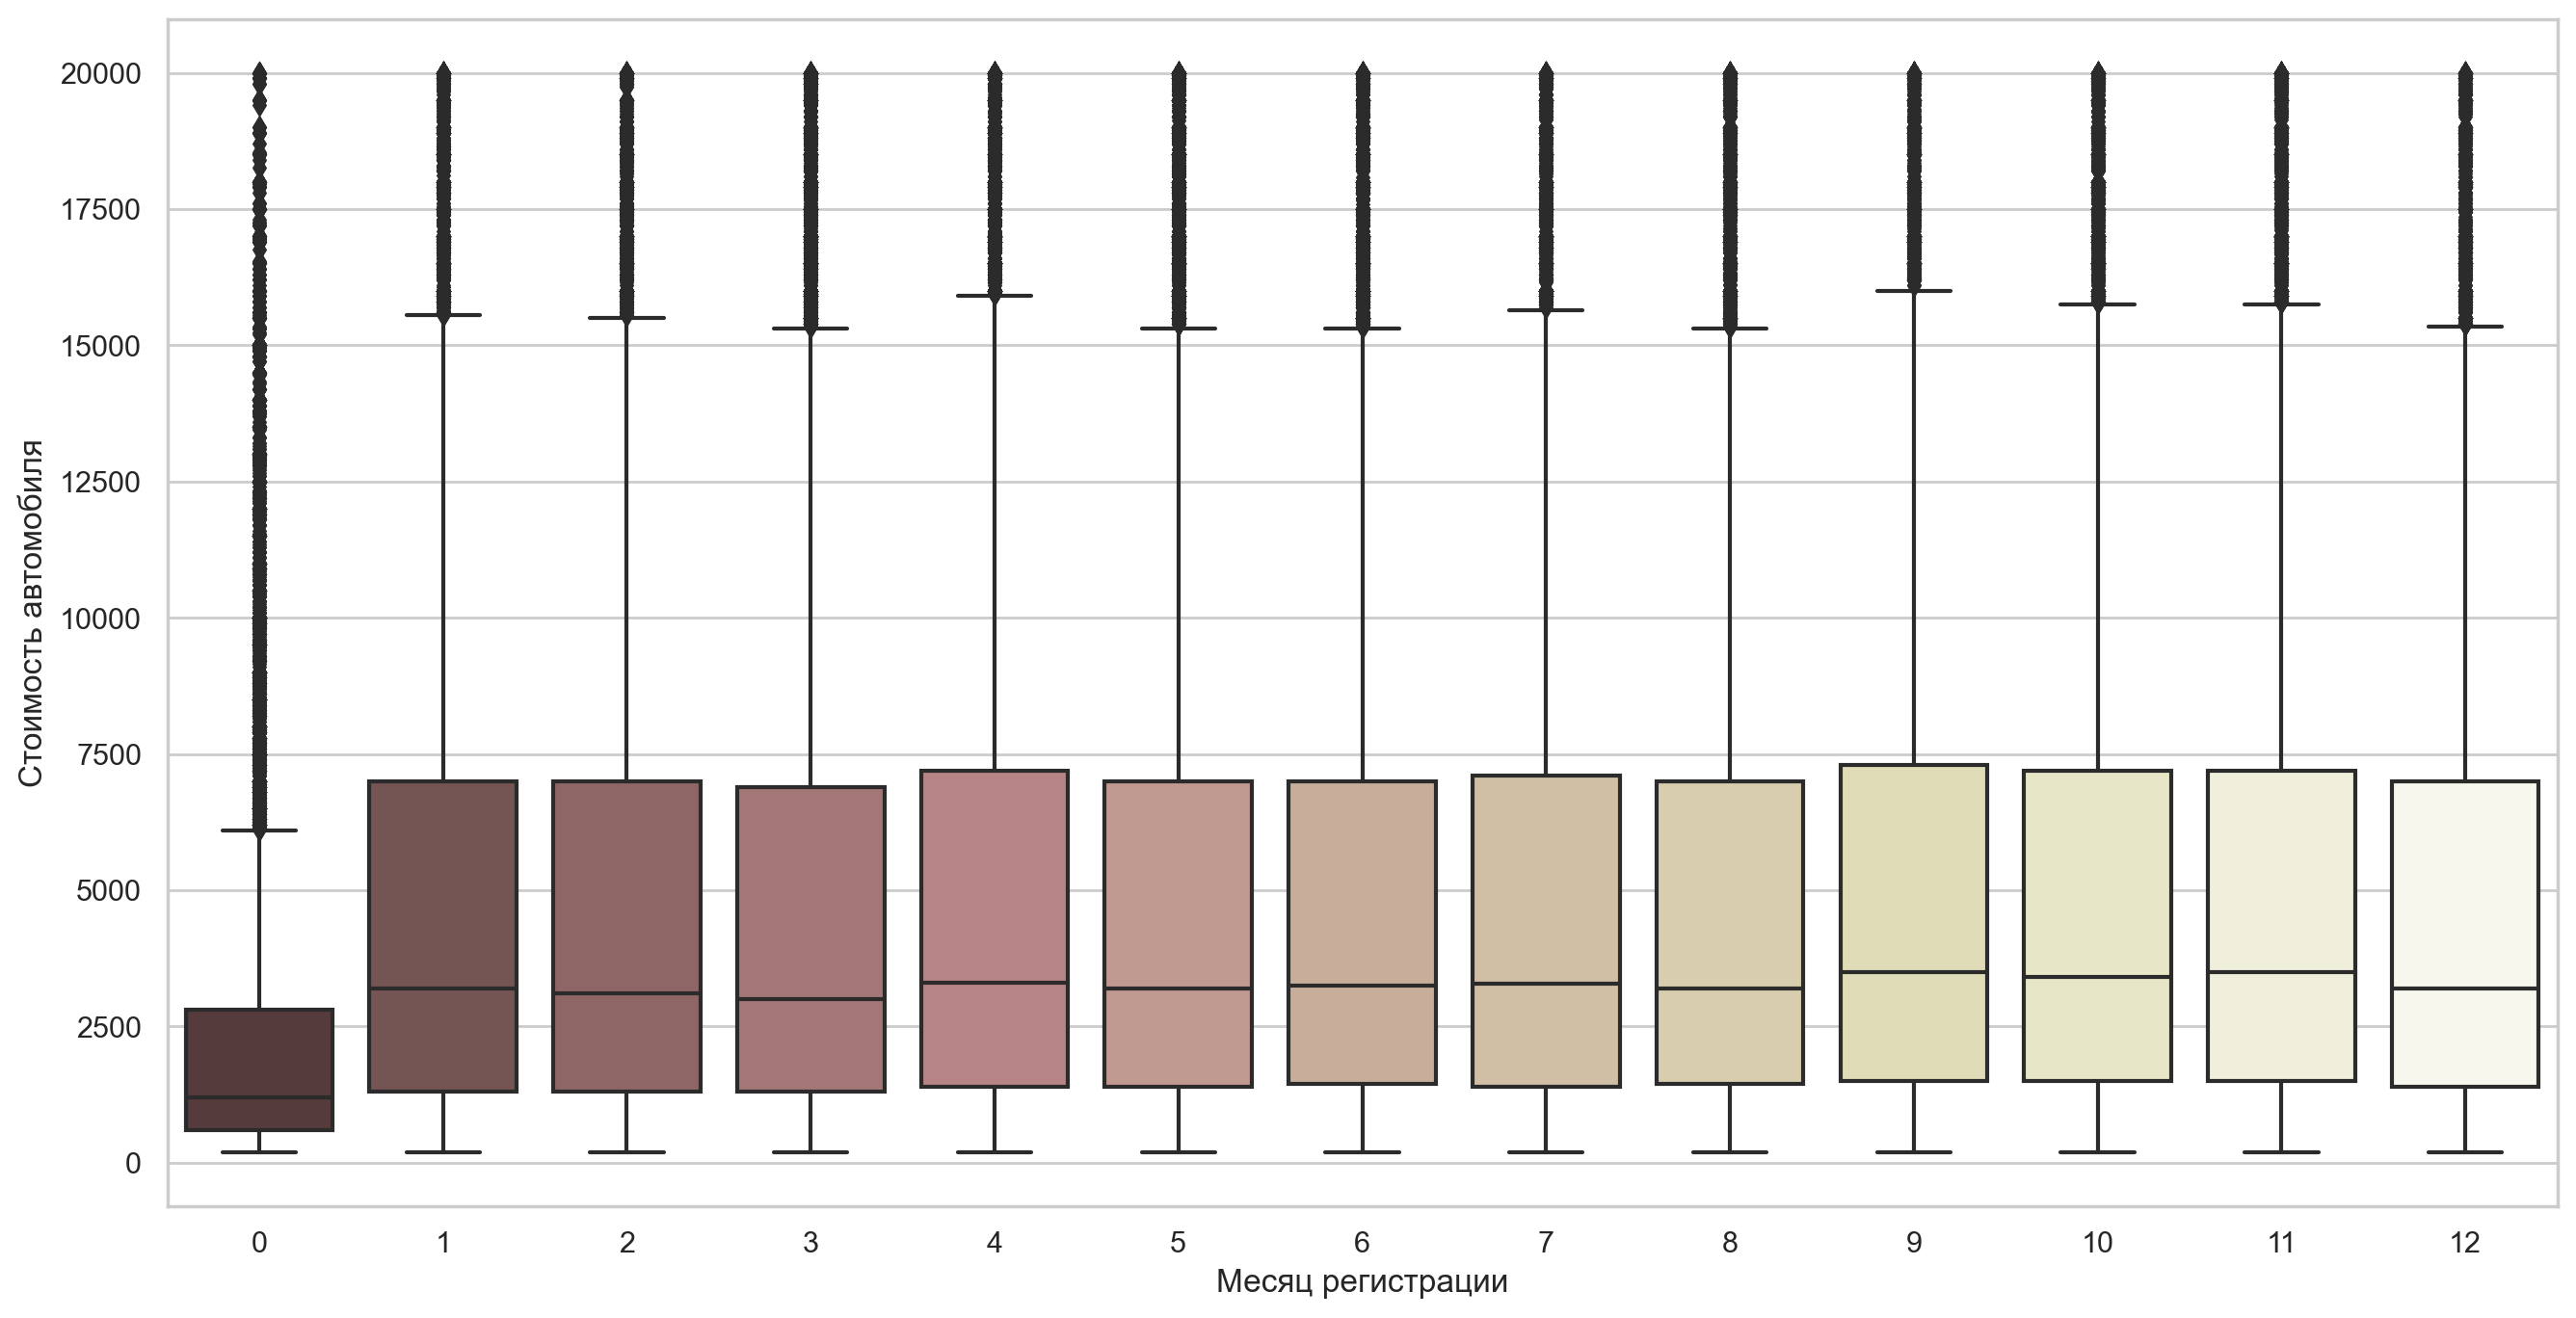

In [56]:
#убедимся что признак не влияет на целевой признак
plt.figure(figsize=(16, 8))
sns.boxplot(x='registration_month', y='car_price', data=data, palette='pink')
plt.xlabel('Месяц регистрации', fontsize=12)
plt.ylabel('Стоимость автомобиля', fontsize=12)
plt.show()

In [57]:
#удалим признак registration_month
data = data.drop(['registration_month'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 305487 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   car_price          305487 non-null  int64 
 1   vehicle_type       305487 non-null  object
 2   registration_year  305487 non-null  int64 
 3   gear_box           305487 non-null  object
 4   power              305487 non-null  int32 
 5   car_model          305487 non-null  object
 6   kilometers         305487 non-null  int64 
 7   fuel_type          305487 non-null  object
 8   car_brand          305487 non-null  object
 9   repaired           305487 non-null  object
 10  postal_code        305487 non-null  int64 
 11  year_created       305487 non-null  int32 
dtypes: int32(2), int64(4), object(6)
memory usage: 28.0+ MB


**4. Почтовый индекс:**

Признак не несет полезной информации для обучения модели. Удалим данный признак.

In [58]:
#проверим, влияет ли признак на целевой. Для этого от индекса оставим только первую цифру
data['postal_code'] = data['postal_code'].astype('str')
first_index = []

for code in np.array(data['postal_code']):
    case_word = code[0]
    first_index.append(case_word)
    
data['postal_code'] = first_index
data['postal_code'] = data['postal_code'].astype('int')
data['postal_code'].head()

0    7
2    9
3    9
4    6
5    3
Name: postal_code, dtype: int32

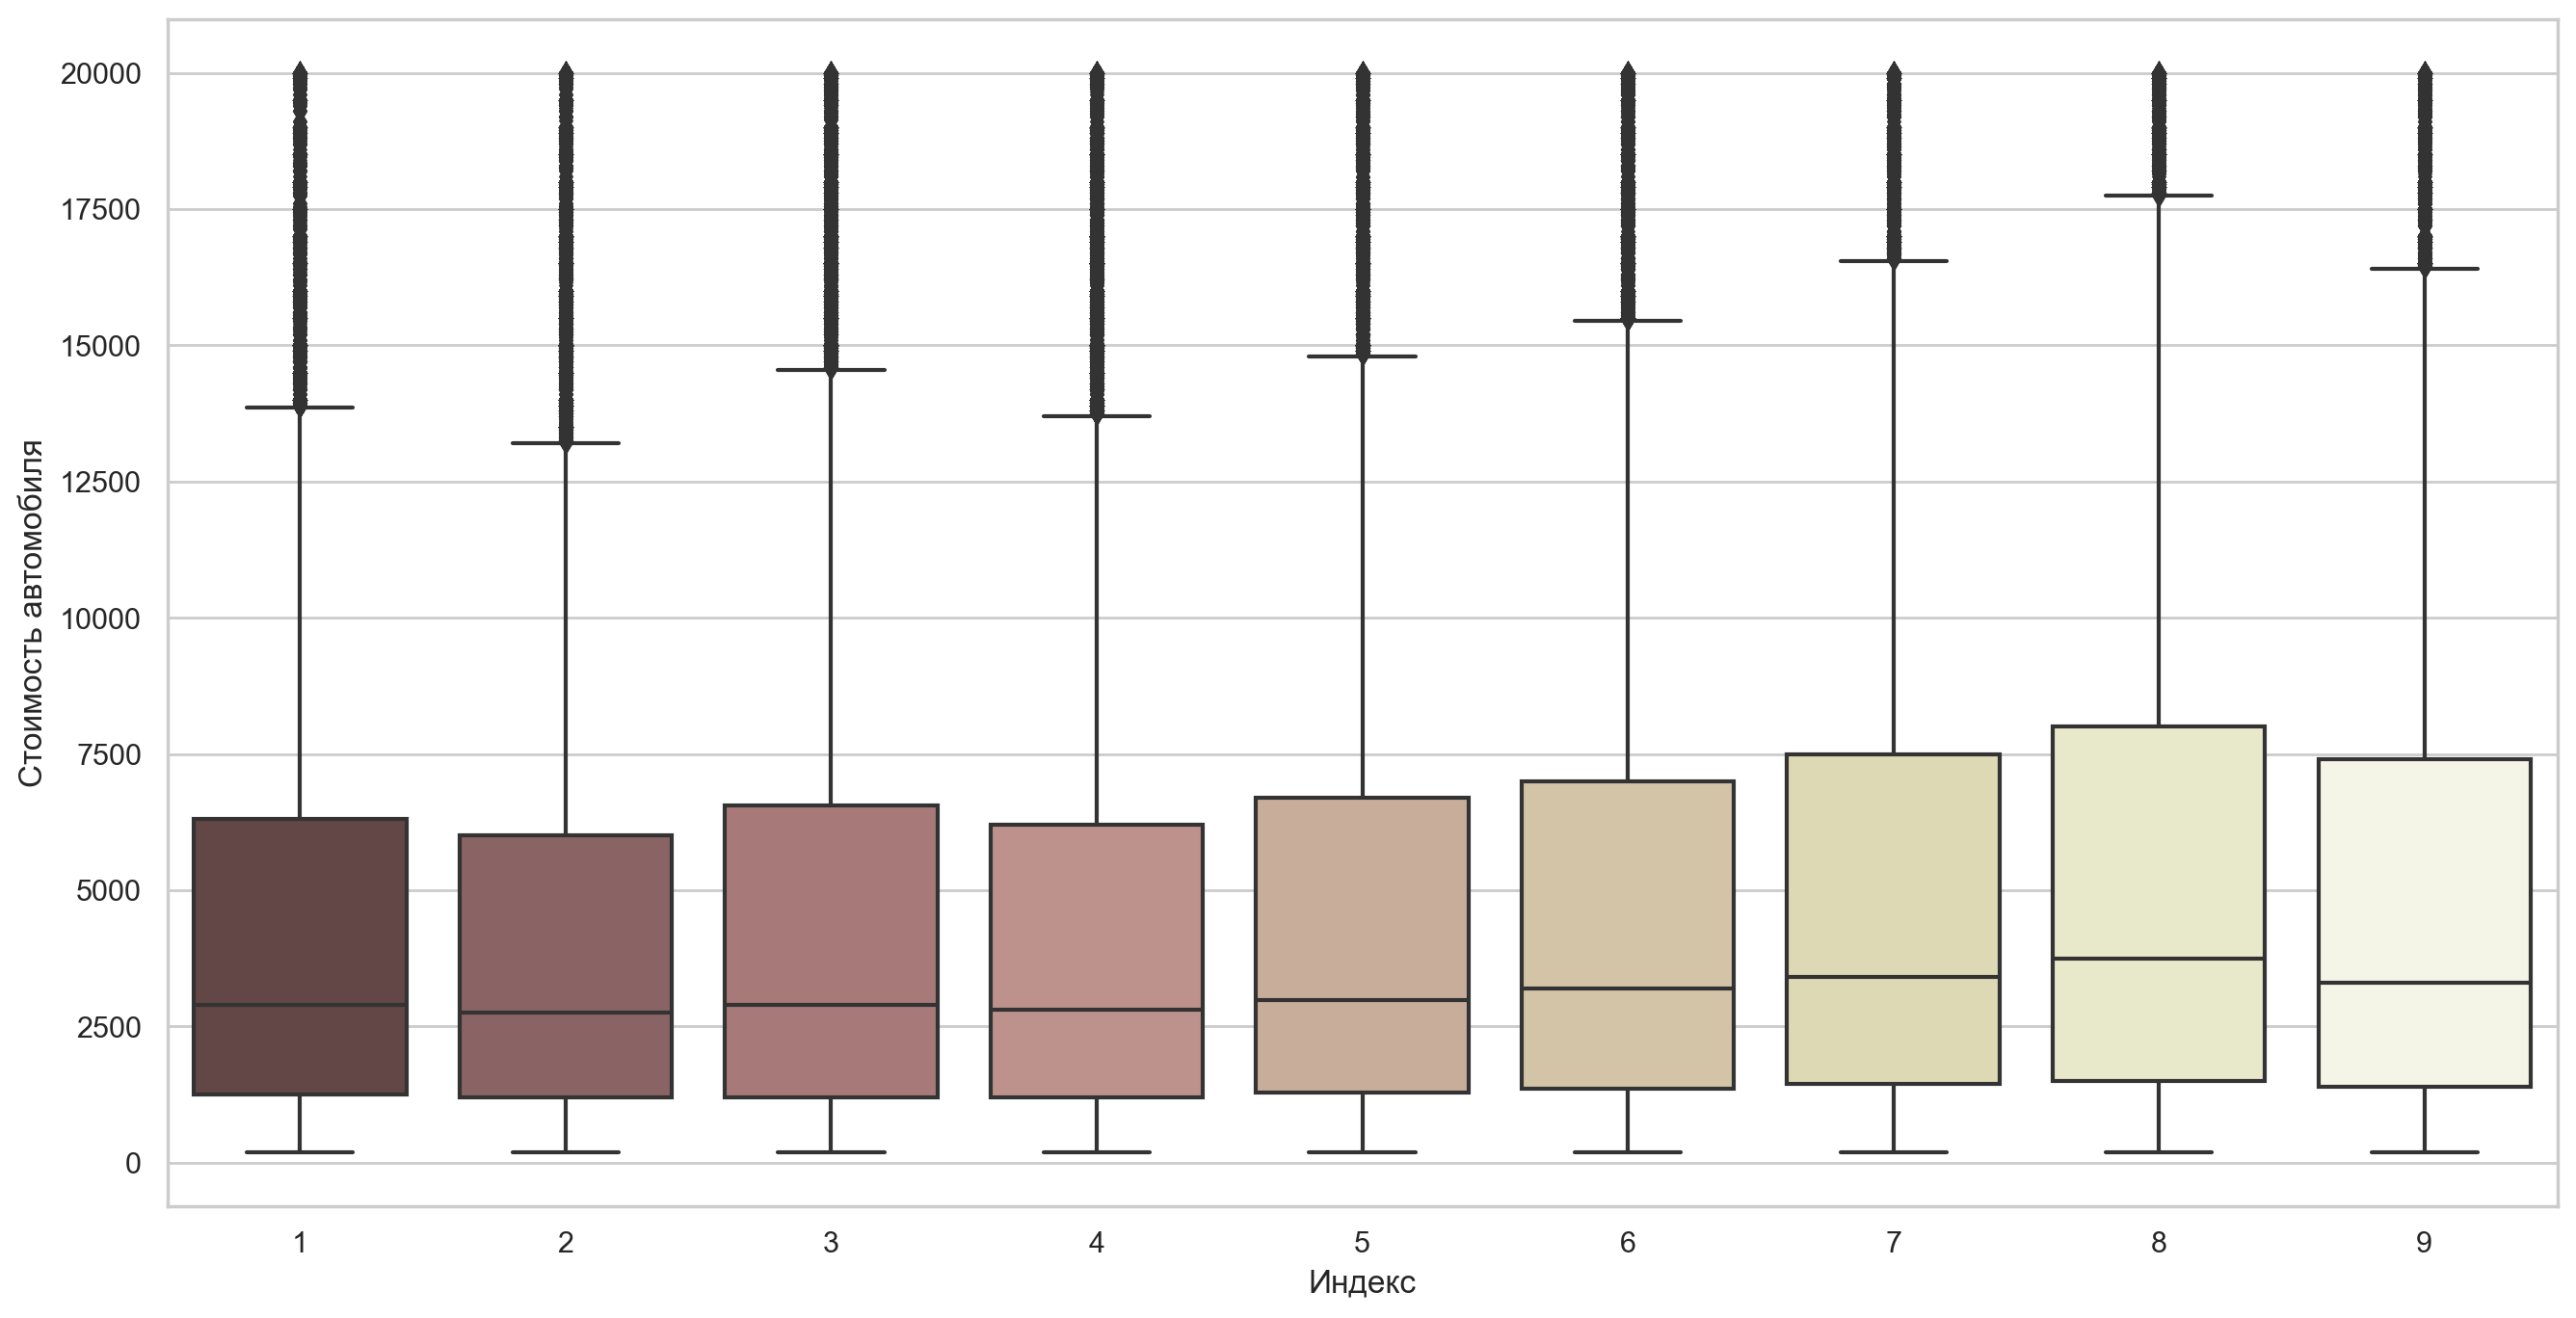

In [59]:
#убедимся что признак не влияет на целевой признак
plt.figure(figsize=(16, 8))
sns.boxplot(x='postal_code', y='car_price', data=data, palette='pink')
plt.xlabel('Индекс', fontsize=12)
plt.ylabel('Стоимость автомобиля', fontsize=12)
plt.show()

In [60]:
#удалим признак postal_code
data = data.drop(['postal_code'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 305487 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   car_price          305487 non-null  int64 
 1   vehicle_type       305487 non-null  object
 2   registration_year  305487 non-null  int64 
 3   gear_box           305487 non-null  object
 4   power              305487 non-null  int32 
 5   car_model          305487 non-null  object
 6   kilometers         305487 non-null  int64 
 7   fuel_type          305487 non-null  object
 8   car_brand          305487 non-null  object
 9   repaired           305487 non-null  object
 10  year_created       305487 non-null  int32 
dtypes: int32(2), int64(3), object(6)
memory usage: 25.6+ MB


**5. Марка автомобиля:**

Данный признак не требует обработки.

In [61]:
#посмотрим уникальные значения
data.car_brand.unique()

array(['volkswagen', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
       'nissan', 'renault', 'mercedes_benz', 'seat', 'honda', 'fiat',
       'opel', 'mini', 'smart', 'hyundai', 'audi', 'alfa_romeo', 'subaru',
       'volvo', 'mitsubishi', 'kia', 'suzuki', 'lancia', 'citroen',
       'toyota', 'chevrolet', 'dacia', 'daihatsu', 'chrysler', 'jaguar',
       'daewoo', 'rover', 'porsche', 'saab', 'land_rover', 'trabant',
       'lada'], dtype=object)

**6. Пробег:**

Данный признак не требует обработки.

In [62]:
#посмотрим на значения пробега автомобилей
data['kilometers'].describe()

count   305,487.00
mean    128,867.92
std      36,428.40
min       5,000.00
25%     125,000.00
50%     150,000.00
75%     150,000.00
max     150,000.00
Name: kilometers, dtype: float64

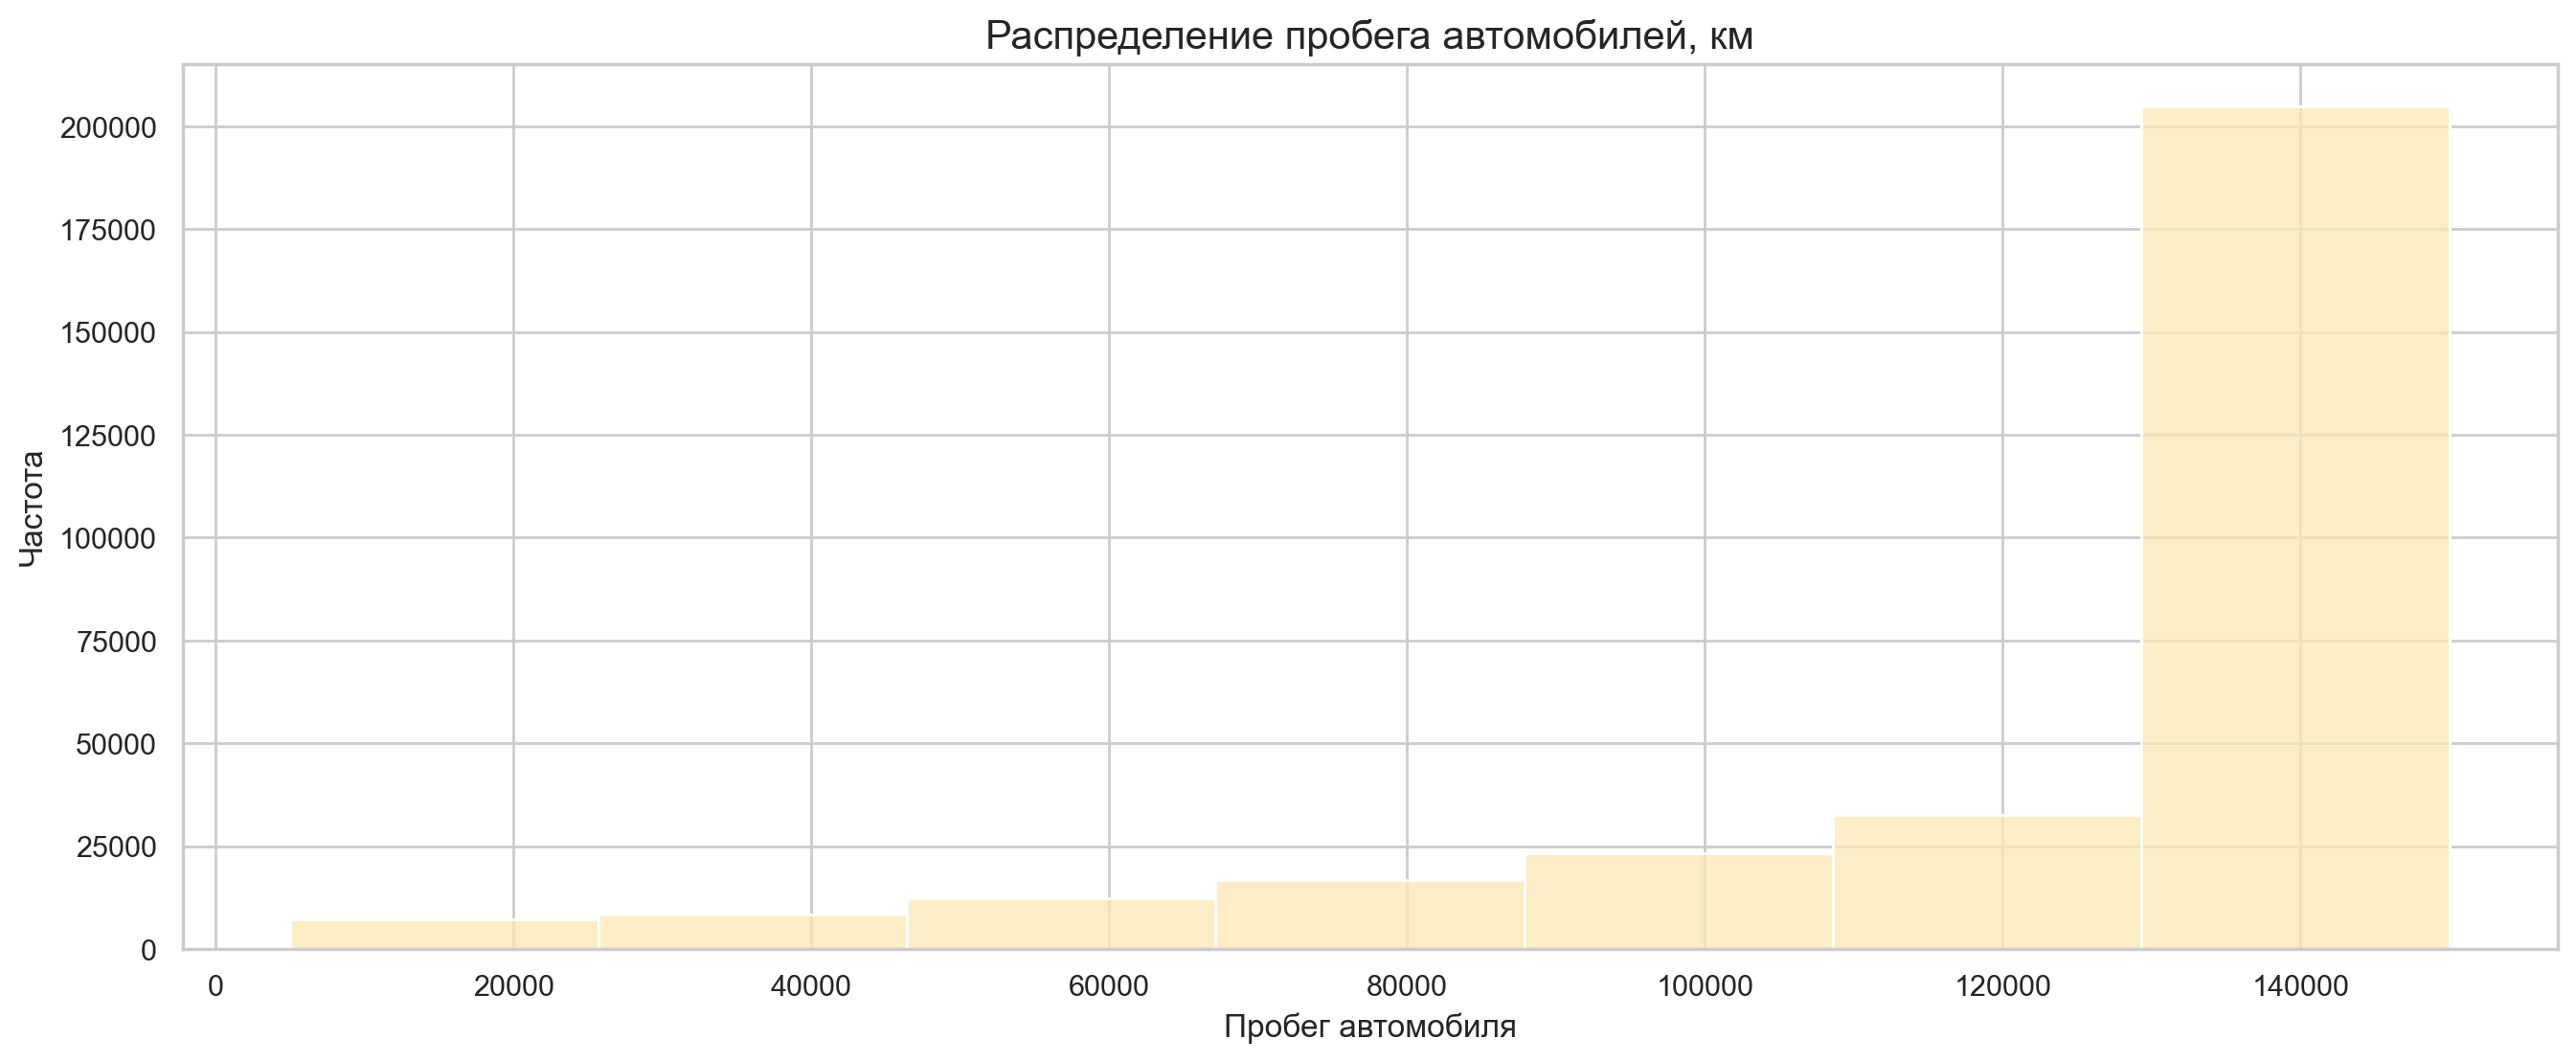

In [63]:
#построим распредление
plt.figure(figsize=(16, 6))
plt.title('Распределение пробега автомобилей, км', fontsize=15)
sns.histplot(data['kilometers'], color='#FBE7B5',bins=7)
plt.xlabel('Пробег автомобиля', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.show()

In [64]:
#проверим наличие дубликатов
data.duplicated().sum() 

43067

In [65]:
#удалим явные дубликаты
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum() 

0

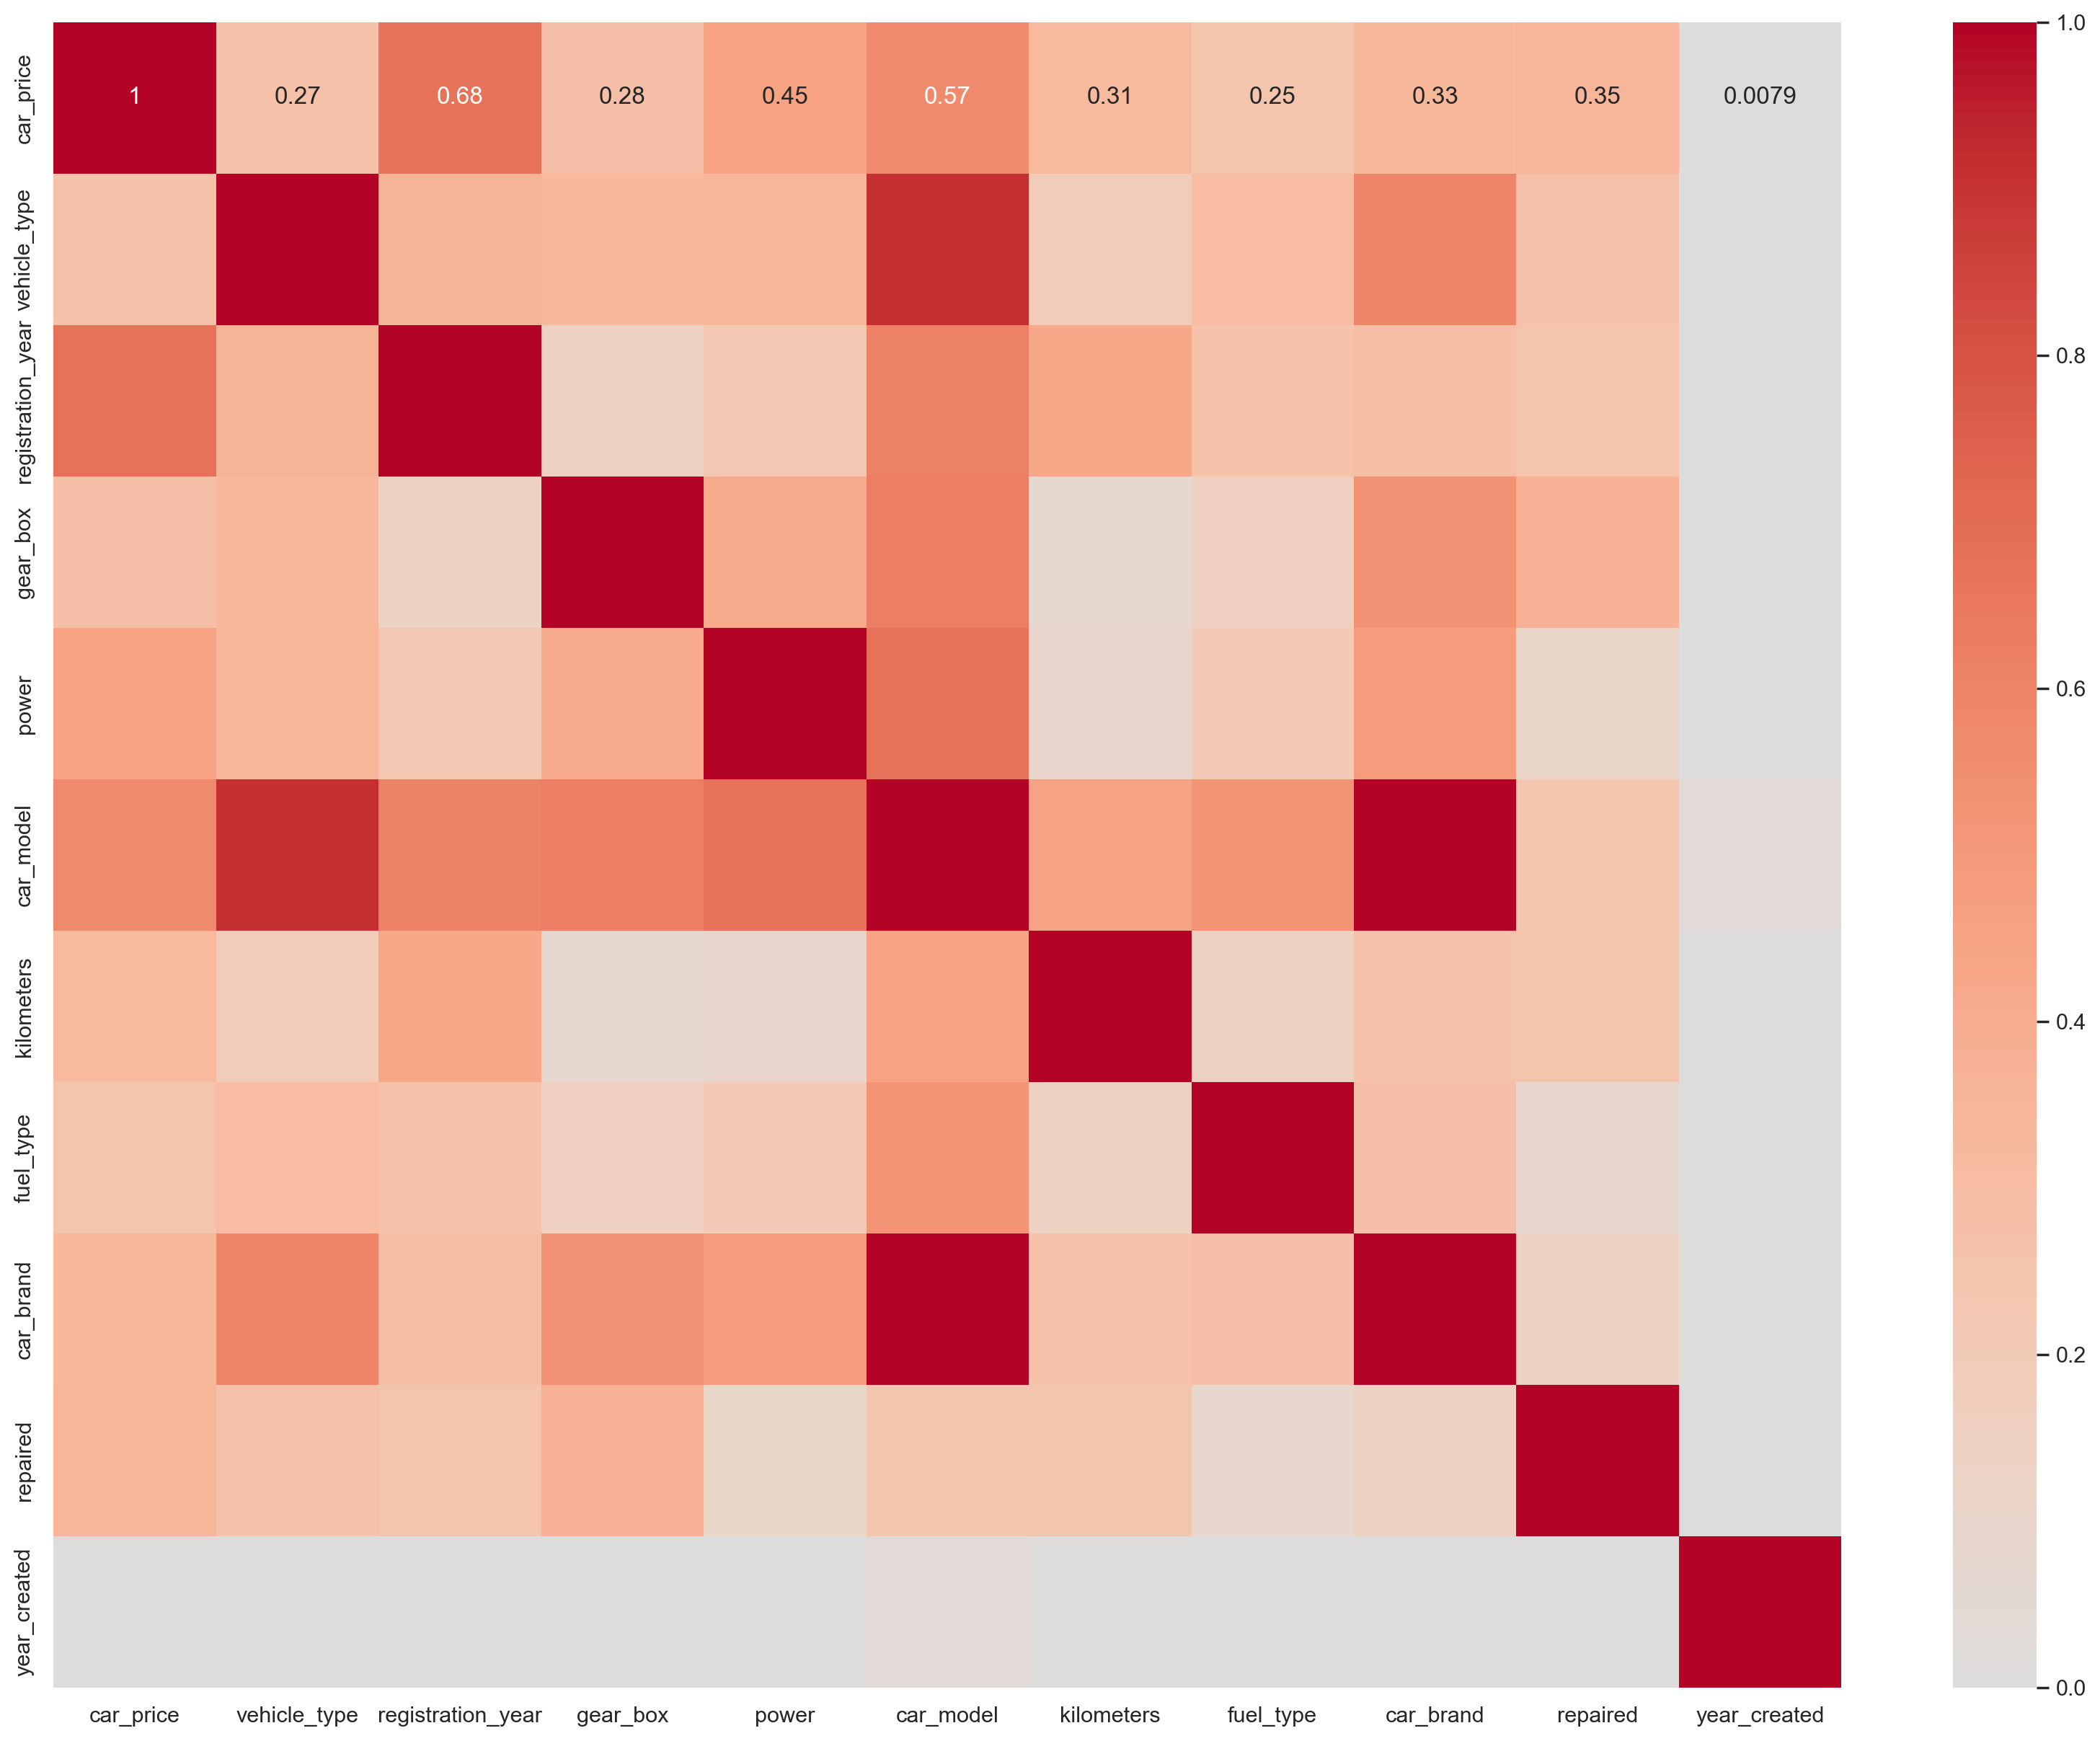

In [66]:
# посмотрим взаимосвязь оставшихся признаков с целевым признаком
correlation = phik_matrix(data, interval_cols = ['car_price', 'registration_year', 'power', 'kilometers', 'year_created'], )
plt.figure(figsize = (20, 15))
sns.heatmap(correlation, annot = True, cmap='coolwarm', center=0)
plt.show()

In [67]:
# видим, что год создания анкеты не вносит существенный вклад на целевой признак. Удалим его
data = data.drop(['year_created'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262420 entries, 0 to 262419
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   car_price          262420 non-null  int64 
 1   vehicle_type       262420 non-null  object
 2   registration_year  262420 non-null  int64 
 3   gear_box           262420 non-null  object
 4   power              262420 non-null  int32 
 5   car_model          262420 non-null  object
 6   kilometers         262420 non-null  int64 
 7   fuel_type          262420 non-null  object
 8   car_brand          262420 non-null  object
 9   repaired           262420 non-null  object
dtypes: int32(1), int64(3), object(6)
memory usage: 19.0+ MB


In [68]:
# удалим признаки vehicle_type и car_brand, так как они сильно коррелирует с моделью автомобиля
data = data.drop(['vehicle_type'], axis=1)
data = data.drop(['car_brand'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262420 entries, 0 to 262419
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   car_price          262420 non-null  int64 
 1   registration_year  262420 non-null  int64 
 2   gear_box           262420 non-null  object
 3   power              262420 non-null  int32 
 4   car_model          262420 non-null  object
 5   kilometers         262420 non-null  int64 
 6   fuel_type          262420 non-null  object
 7   repaired           262420 non-null  object
dtypes: int32(1), int64(3), object(4)
memory usage: 15.0+ MB


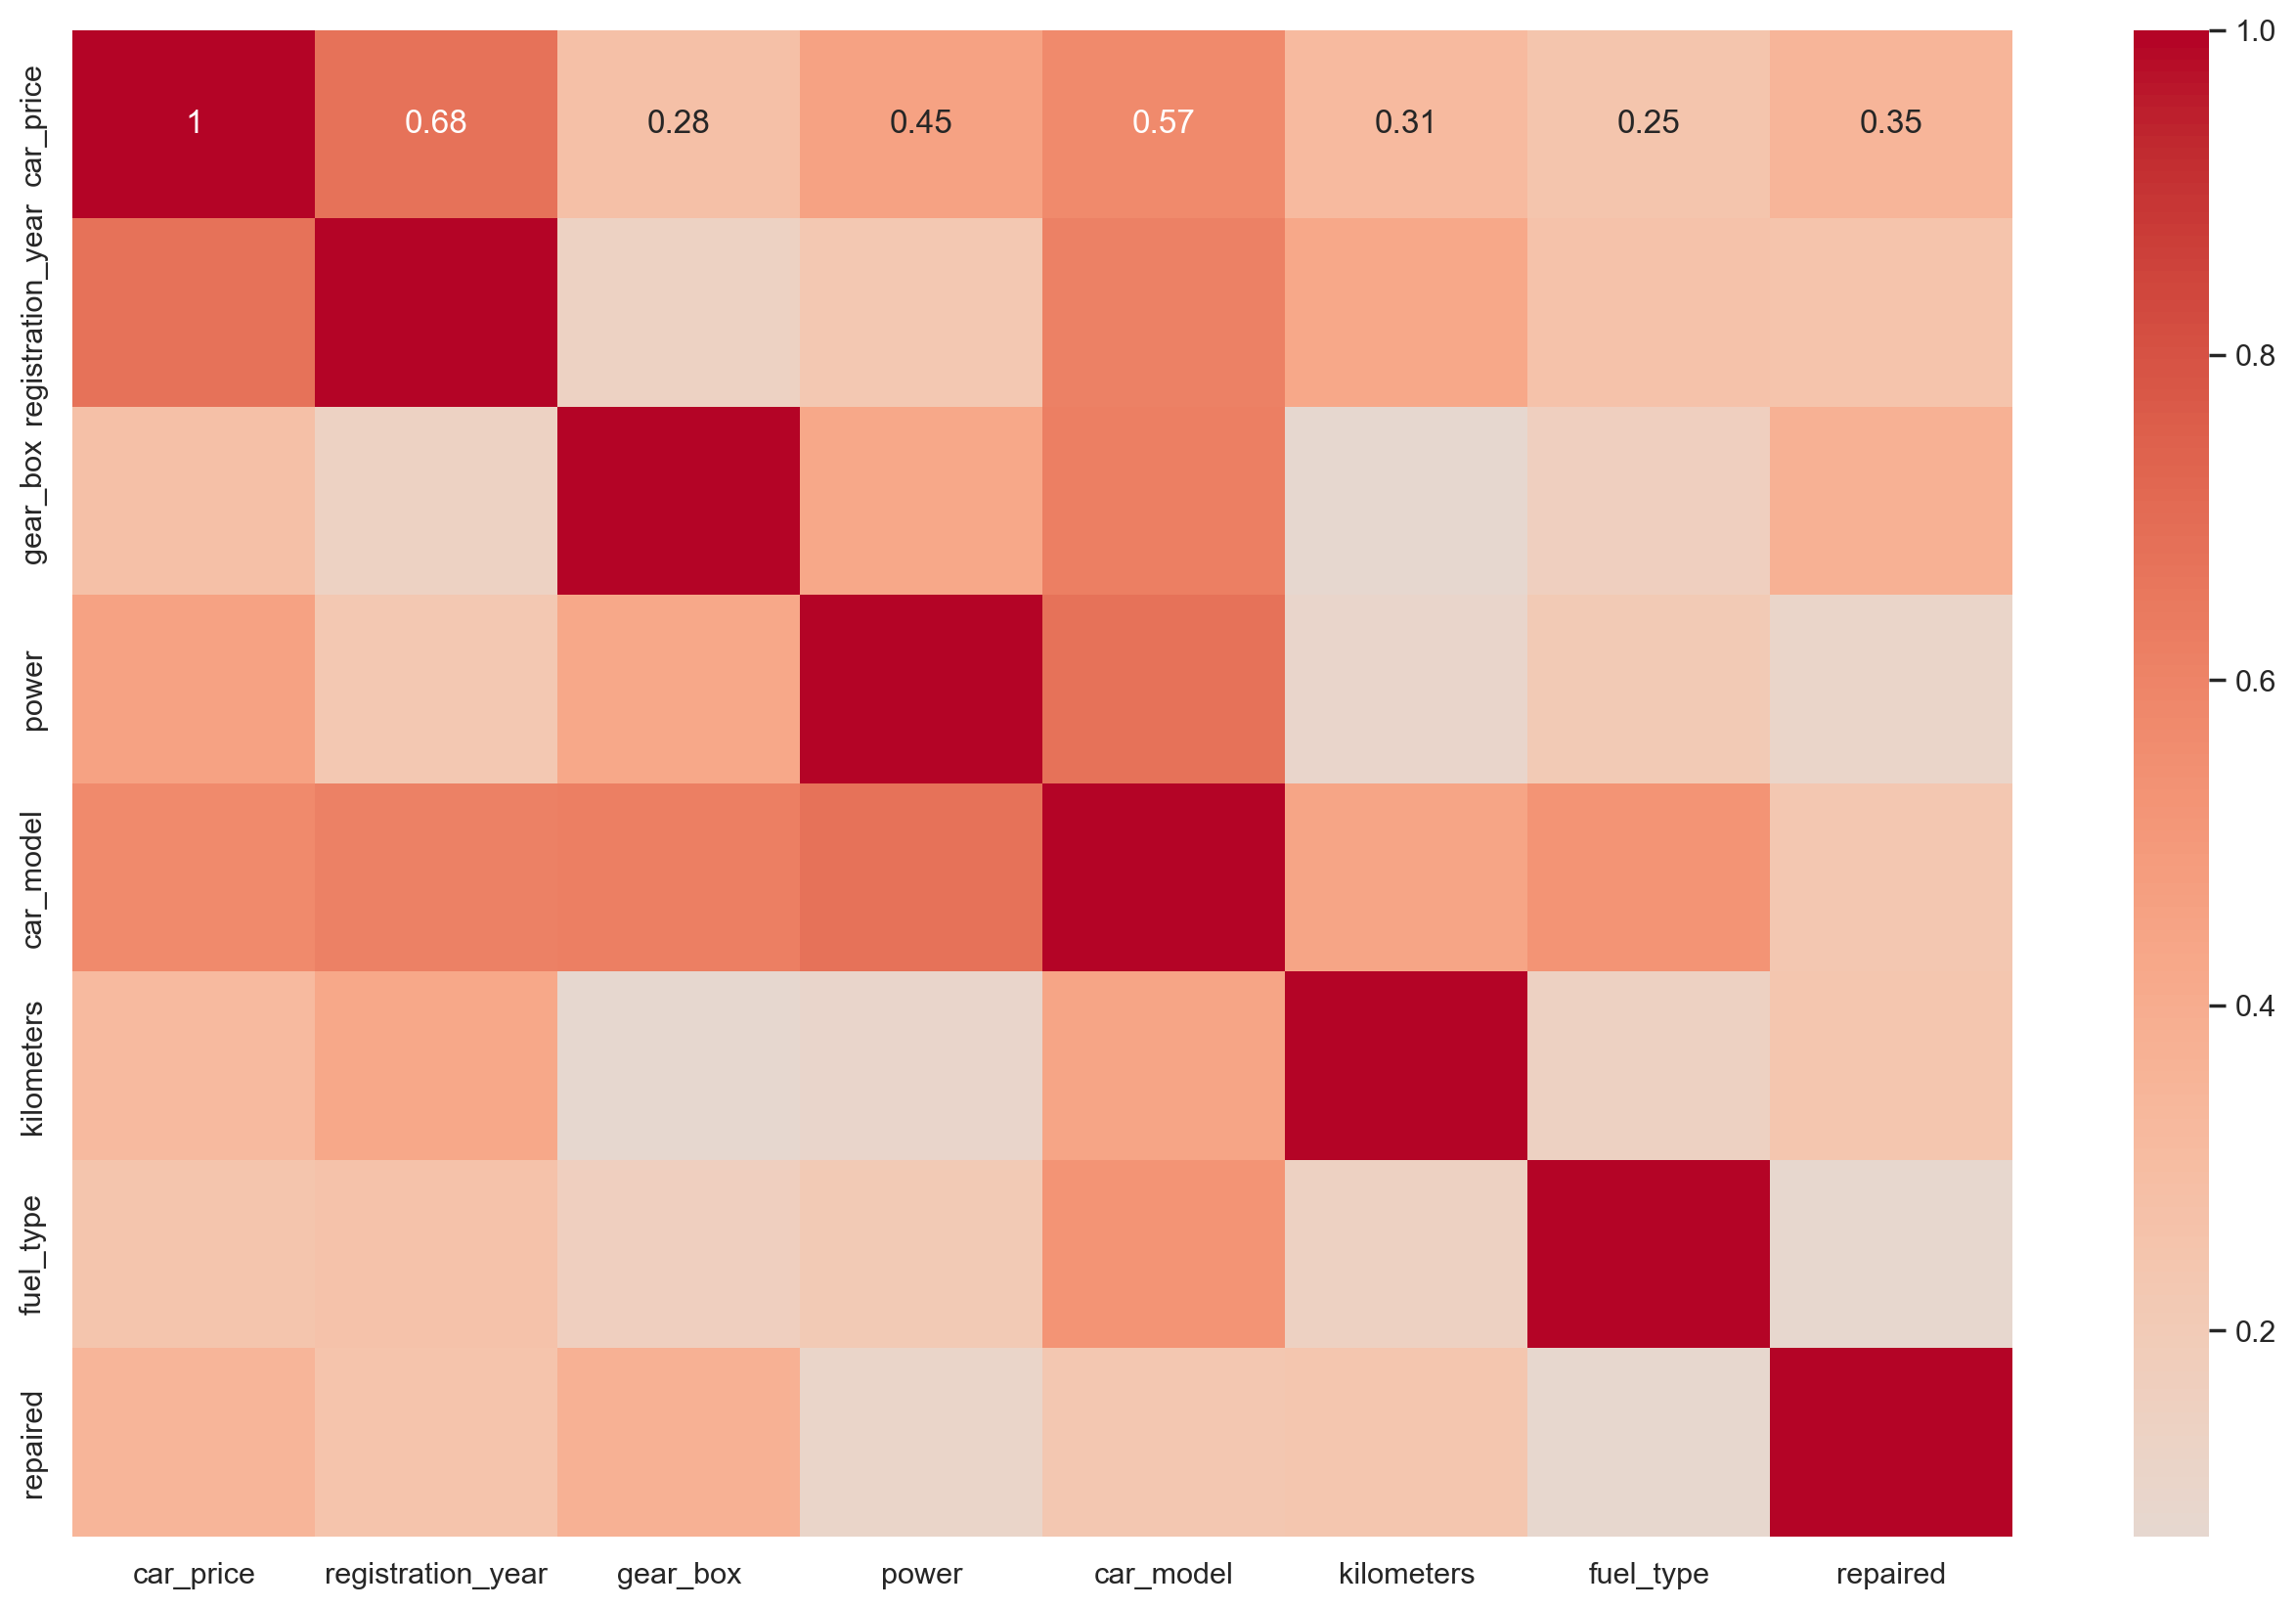

In [69]:
# посмотрим взаимосвязь оставшихся признаков с целевым признаком
correlation = phik_matrix(data, interval_cols = ['car_price', 'registration_year', 'power', 'kilometers'], )
plt.figure(figsize = (16, 10))
sns.heatmap(correlation, annot = True, cmap='coolwarm', center=0)
plt.show()

**Вывод:**

- Из данных удалены 6 неинформативных признаков. Среди них: дата скачивания анкеты из базы, месяц регистрации автомобиля, дата создания анкеты, количество фотографий автомобиля, почтовый индекс владельца анкеты и дата последней активности пользователя.

- Из данных также были удалены признаки с типом кузова и брэндом автомобиля, так как они сильно коррелируют с моделью автомобиля.

- Наибольшее влияние на целевой признак оказывают признаки: год регистрации автомобиля, мощность и модель автомобиля.

In [70]:
# проверим, не осталось ли пропусков
data.isna().sum()

car_price            0
registration_year    0
gear_box             0
power                0
car_model            0
kilometers           0
fuel_type            0
repaired             0
dtype: int64

In [71]:
# определим, сколько строк было удалено
print('После предобработки данных было удалено', 
      row_before - data.shape[0],
      'строк, что составляет', 
      round((row_before - data.shape[0]) / row_before *100, 1) ,
      '% от всех данных')

После предобработки данных было удалено 91949 строк, что составляет 25.9 % от всех данных


### Вывод по шагу "Предобработка данных"

1. Данные требовали дополнительной предобработки. Обработаны пропущенные значения, удалены дубликаты, обработаны аномалии и удалены неинформативные признаки. После предобработки было удалено 26% всех данных.


2. Данные в признаках стоимость автомобиля, год регистрации и мощность автомобиля очищены от аномалий. В данных остались автомобили стоимостью выше 200 евро, с годом регистрации выше самого позднего года создания анкеты и меньше 1980 и мощностью выше 1000 л.с. и меньше 30 л.с.


3. Среди признаков имелось 6 неинформативных признаков. Среди них: дата скачивания анкеты из базы, месяц регистрации автомобиля, дата создания анкеты, количество фотографий автомобиля, почтовый индекс владельца анкеты и дата последней активности пользователя. Все признаки были удалены.


4. Из данных также были удалены признаки с типом кузова и брэндом автомобиля, так как они сильно коррелируют с моделью автомобиля.


5. Наибольшее влияние на целевой признак оказывают признаки: год регистрации автомобиля, мощность и модель автомобиля.

## Подготовка выборок для обучения моделей

Подготовим выборки к обучению моделей. Для этого:

1. Разделим данные на выборки
2. Закодируем категориальные признаки и применим масштабирование к данным при помощи make_column_transformer

### Деление данных на выборки

Разделим данные на обучающую и тестовую выборку в отношении 3:1.

In [72]:
# разделим данные и целевой признак
features = data.drop(['car_price'], axis=1)
target = data['car_price']
print('Размер получившихся данных:', features.shape)
print('Целевой признак:', target.shape)
features.head()

Размер получившихся данных: (262420, 7)
Целевой признак: (262420,)


,registration_year,gear_box,power,car_model,kilometers,fuel_type,repaired
0,1993,manual,101,golf,150000,petrol,unknown
1,2004,auto,163,grand,125000,gasoline,unknown
2,2001,manual,75,golf,150000,petrol,no
3,2008,manual,69,fabia,90000,gasoline,no
4,1995,manual,102,3er,150000,petrol,yes


In [73]:
# разделим данные на выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, 
    target, 
    test_size=0.25, 
    random_state=RANDOM_STATE)
    
print('Размер обучающей выборки:', features_train.shape)
print('Размер тестовой выборки:', features_test.shape)
print('Размер целевого признака для обучающей выборки:', target_train.shape)
print('Размер целевого признака для тестовой выборки:', target_test.shape)

Размер обучающей выборки: (196815, 7)
Размер тестовой выборки: (65605, 7)
Размер целевого признака для обучающей выборки: (196815,)
Размер целевого признака для тестовой выборки: (65605,)


**Вывод:**

Данные были разделены на обучающую и тестовую выборку в отношении 3:1.

### Кодировка и масштабирование признаков

- для Logistic Regression количественные признаки будем масштабировать, а категориальные кодировать методом прямого кодирования (One-Hot Encoding) с использованием pipeline,
- для Random Forest количественные признаки  будем масштабировать, а категориальные кодировать методом OrdinalEncoder с использованием pipeline,
- для Cat Boost Classifier и LGBM Classifier категориальные признаки будем кодировать с использованием внутренних кодировщиков.

In [74]:
# выделим в отдельные переменные признаки, которые будут кодироваться и масштабироваться
cat_columns = ['gear_box', 'repaired', 'car_model', 'fuel_type']
numeric_columns = ['registration_year', 'power', 'kilometers']

In [75]:
# Линейная регрессия
col_transformer_linreg = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore', sparse=True), cat_columns),
    (StandardScaler(), numeric_columns),
    remainder='passthrough',
    verbose_feature_names_out=False
)

# применим make_column_transformer к обучающим данным
features_train_linreg = col_transformer_linreg.fit_transform(features_train)
features_train_linreg = csc_matrix(features_train_linreg)
features_train_linreg = pd.DataFrame.sparse.from_spmatrix(
    features_train_linreg, 
    columns=col_transformer_linreg.get_feature_names_out()
)

# выведем первые несколько строк
features_train_linreg.head()

,gear_box_manual,gear_box_unknown,repaired_unknown,repaired_yes,car_model_145,car_model_147,car_model_156,car_model_159,car_model_1_reihe,car_model_1er,car_model_200,car_model_2_reihe,car_model_300c,car_model_3_reihe,car_model_3er,car_model_4_reihe,car_model_500,car_model_5_reihe,car_model_5er,car_model_601,car_model_6_reihe,car_model_6er,car_model_7er,car_model_80,car_model_850,...,car_model_vectra,car_model_verso,car_model_viano,car_model_vito,car_model_vivaro,car_model_voyager,car_model_wrangler,car_model_x_reihe,car_model_x_trail,car_model_x_type,car_model_xc_reihe,car_model_yaris,car_model_yeti,car_model_ypsilon,car_model_z_reihe,car_model_zafira,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,registration_year,power,kilometers
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,-0.53,4.41,0.60
1,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.81,-0.51,-0.74
2,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,-0.86,-0.39,0.60
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.47,1.09,0.60
4,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.31,-0.58,0.60


In [76]:
# Случайный лес
col_transformer_forest = make_column_transformer(
    (OrdinalEncoder(), cat_columns),
    (StandardScaler(), numeric_columns),
    remainder='passthrough',
    verbose_feature_names_out=False
)

# применим make_column_transformer к обучающим данным
features_train_forest = col_transformer_forest.fit_transform(features_train)
features_train_forest = csc_matrix(features_train_forest)
features_train_forest = pd.DataFrame.sparse.from_spmatrix(
    features_train_forest, 
    columns=col_transformer_forest.get_feature_names_out()
)

features_train_forest.head()

,gear_box,repaired,car_model,fuel_type,registration_year,power,kilometers
0,0.00,0.00,95.00,4.00,-0.53,4.41,0.60
1,1.00,0.00,128.00,6.00,0.81,-0.51,-0.74
2,1.00,1.00,170.00,4.00,-0.86,-0.39,0.60
3,0.00,0.00,31.00,2.00,0.47,1.09,0.60
4,1.00,0.00,166.00,2.00,0.31,-0.58,0.60


**Вывод:**

Все категориальные и количественные признаки были закодированы и масштабированы.

### Вывод по шагу "Подготовка выборок для обучения моделей"

1. Для кодировки и масштабирования будут использоваться следующие подходы:
    - для Logistic Regression количественные признаки будем масштабировать, а категориальные кодировать методом прямого кодирования (One-Hot Encoding) с использованием pipeline,
    - для Random Forest количественные признаки будем масштабировать, а категориальные кодировать методом OrdinalEncoder с использованием pipeline,
    - для Cat Boost Classifier и LGBM Classifier категориальные признаки будем кодировать с использованием внутренних кодировщиков.



2. Данные были разделены на обучающую и тестовую выборку в отношении 3:1.

## Обучение моделей

Для обучения будем использовать следующие модели:

1. Линейная регрессия / Linear Regression
2. Случайный лес /  Random Forest Regressor
3. Градиентный бустинг / Cat Boost Regressor
4. Стохастический градиентный бустинг / Light GBM

In [77]:
# создадим функцию для построения графика распределения предсказанных и истинных значений
def plot_true_predict (target_test, predictions, color1, color2):
    plt.figure(figsize=(15, 6))
    sns.histplot(pd.Series(predictions), bins=50, alpha=0.5, label='Предсказанные значения', color=color1, kde=True)
    sns.histplot(target_test, bins=50, alpha=0.5, label='Истинные значения', color=color2, kde=True)
    plt.title('График распределения предсказанных и истинных значений', y=1.05, fontsize=15)
    plt.xlabel(f'Стоимость автомобиля, евро', fontsize=12)
    plt.ylabel('Частота', fontsize=12)
    plt.legend()
    plt.show()

### Линейная регрессия / Linear Regression

- Обучим модель и оценим ее качество с помощью кроссвалидации, используя метрику RMSE
- Измерим время обучения и предсказания модели
- Построим график распределения предсказанных и истинных значений

In [78]:
# переберем различные гиперпараметры Linear Regression с помощью GridSearch CV. Найдем лучшие
model_lr = LinearRegression()
pipeline_lr = make_pipeline(col_transformer_linreg, model_lr)

linreg_params = {
    'linearregression__fit_intercept': [True, False],
    'linearregression__copy_X': [True, False],
}

gs_linreg_pl = GridSearchCV (
    pipeline_lr, 
    linreg_params, 
    scoring='neg_root_mean_squared_error', 
    cv=5,
    n_jobs=-1
)

gs_linreg_pl.fit(features_train, target_train)
rmse_lr = gs_linreg_pl.best_score_ * (-1)
best_model_lr = gs_linreg_pl.best_estimator_

print(f'Лучшее значение RMSE: {round(rmse_lr, 1)}')
print(f'Лучшие параметры: {gs_linreg_pl.best_params_}')

Лучшее значение RMSE: 2594.9
Лучшие параметры: {'linearregression__copy_X': True, 'linearregression__fit_intercept': True}


In [79]:
# оценим время обучения модели
start_time = time.time()
model_lr = LinearRegression(copy_X=True, fit_intercept=True)
model_lr.fit(features_train_linreg, target_train)
training_time_lr = time.time() - start_time
print(f'Время обучения модели: {round(training_time_lr, 1)} секунд')

Время обучения модели: 1.4 секунд


In [80]:
# оценим время предсказания модели
start_time = time.time()
predictions_lr = model_lr.predict(features_train_linreg)
prediction_time_lr = time.time() - start_time
print(f'Время предсказания модели: {round(prediction_time_lr, 1)} секунд')
del model_lr

Время предсказания модели: 0.0 секунд


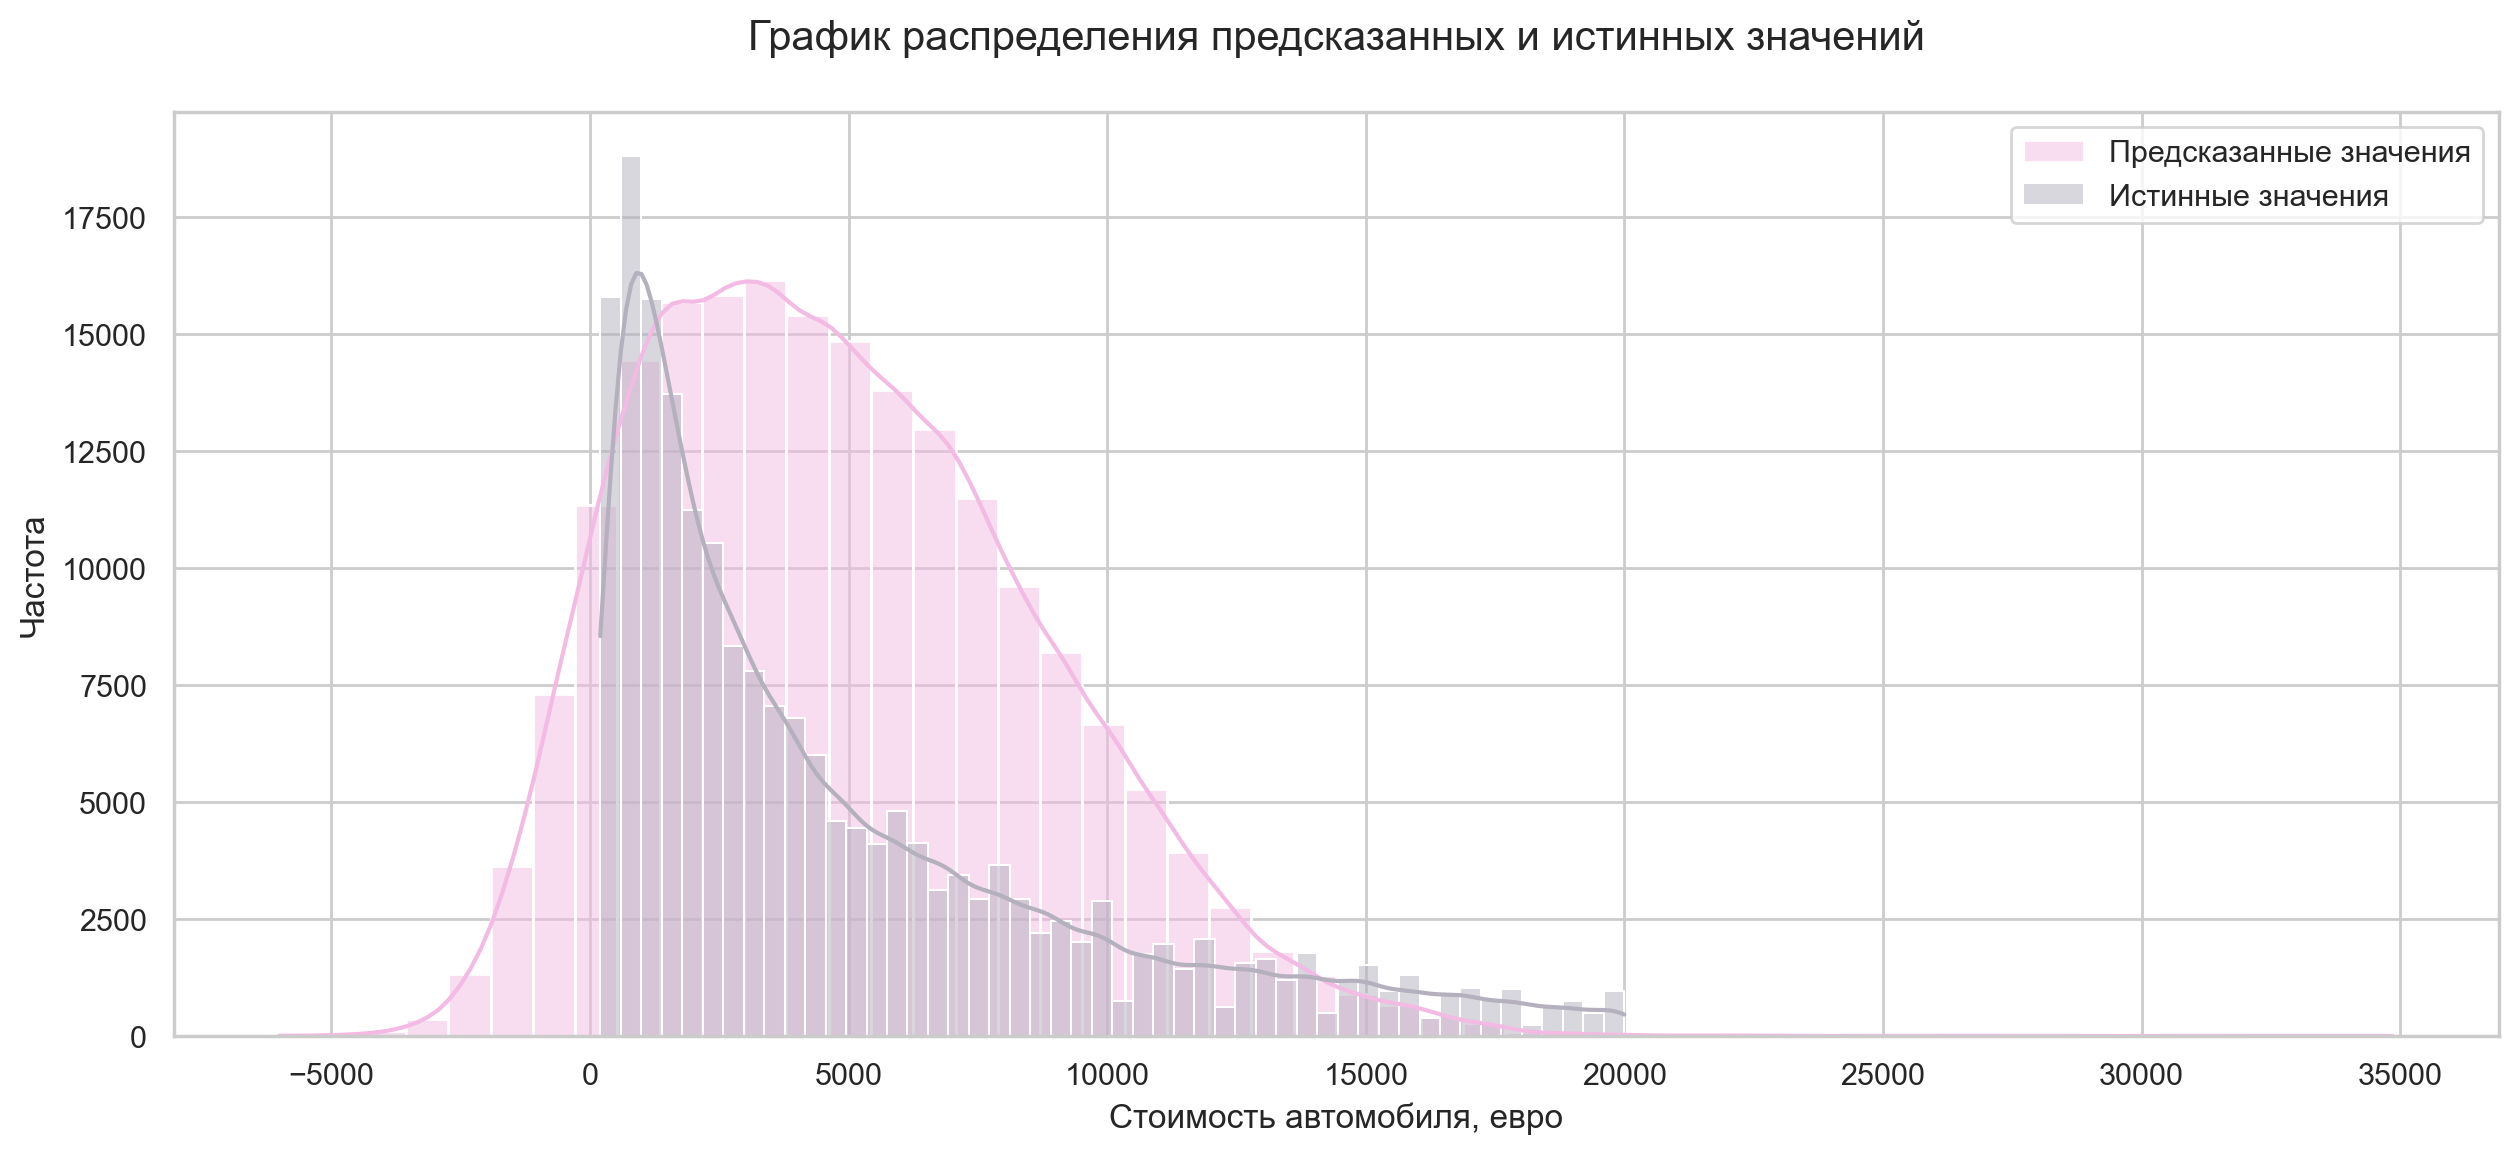

In [81]:
# построим график
plot_true_predict(target_train, best_model_lr.predict(features_train), '#F3BAE3', '#B4B0BE')

**Вывод:**

- Лучший показатель RMSE линейной регрессии = 2595. У модели высокая скорость обучения и предсказаний. Однако, по графикам распределения предсказанных значений и истинных видим, что распределения сильно различаются.

### Случайный лес / Random Forest Regressor

- Для перебора различных гиперпараметров Random Forest Regressor будем использовать Grid Search CV
- Обучим модель с наилучшими параметрами и оценим ее качество с помощью кроссвалидации, используя метрику RMSE
- Измерим время обучения и предсказания модели
- Построим график распределения предсказанных и истинных значений

In [82]:
# переберем различные гиперпараметры  Random Forest Regressor с помощью GridSearch CV. Найдем лучшие
model_forest = RandomForestRegressor(random_state=RANDOM_STATE)
pipeline_forest = make_pipeline(col_transformer_linreg, model_forest)

forest_params = {
    'randomforestregressor__max_depth': range(2, 10, 2),  
    'randomforestregressor__n_estimators': range(10, 300, 50),
}


gs_forest_pl = GridSearchCV (
    pipeline_forest, 
    forest_params, 
    scoring='neg_root_mean_squared_error', 
    cv=5,
    n_jobs=-1
)

gs_forest_pl.fit(features_train, target_train)
rmse_rfr = gs_forest_pl.best_score_ * (-1)
best_model_rfr = gs_forest_pl.best_estimator_

print(f'Лучшее значение RMSE: {round(rmse_rfr, 1)}')
print(f'Лучшие параметры: {gs_forest_pl.best_params_}')

Лучшее значение RMSE: 2070.2
Лучшие параметры: {'randomforestregressor__max_depth': 8, 'randomforestregressor__n_estimators': 260}


In [83]:
# оценим время обучения модели
start_time = time.time()
model_forest = RandomForestRegressor(max_depth=8, n_estimators=260, min_samples_split=2 , 
                                     min_samples_leaf=3 , random_state=RANDOM_STATE)
model_forest.fit(features_train_forest, target_train)
training_time_rfr = time.time() - start_time
print(f'Время обучения модели: {round(training_time_rfr, 1)} секунд')

Время обучения модели: 198.4 секунд


In [84]:
# оценим время предсказания модели
start_time = time.time()
predictions_rfr = model_forest.predict(features_train_forest)
prediction_time_rfr = time.time() - start_time
print(f'Время предсказания модели: {round(prediction_time_rfr, 1)} секунд')
del model_forest

Время предсказания модели: 3.1 секунд


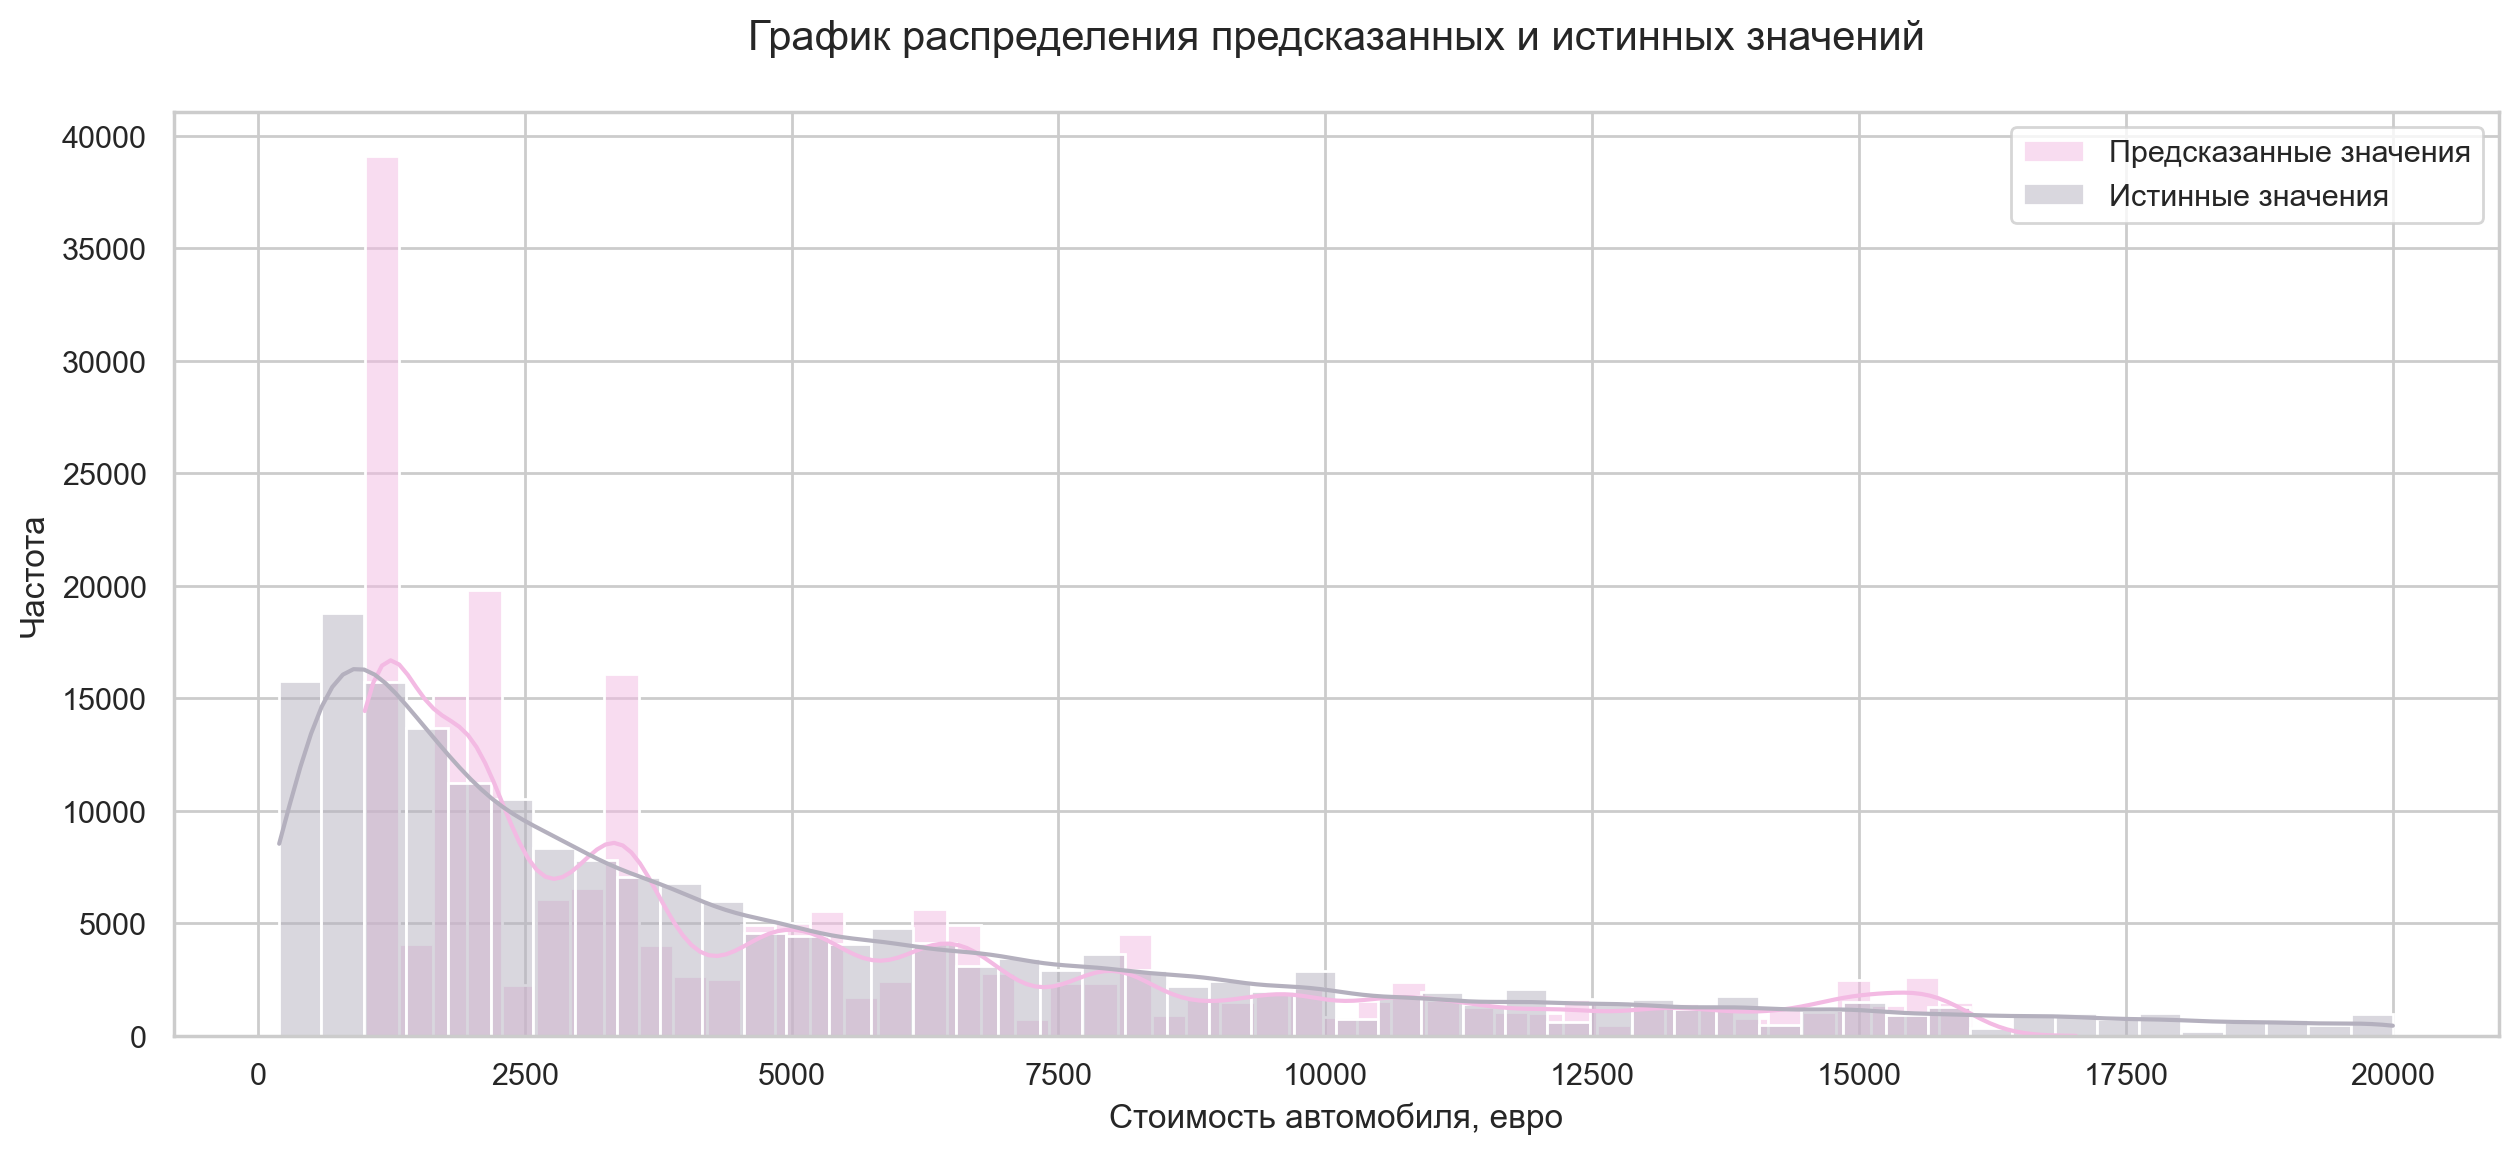

In [85]:
# построим график
plot_true_predict(target_train, best_model_rfr.predict(features_train), '#F3BAE3', '#B4B0BE')

**Вывод:**

- Лучший показатель RMSE модели случайного леса = 2070. Показатель лучше, чем в случае линейной регрессии, однако у модели низкая скорость обучения и предсказаний.

### Градиентный бустинг / Cat Boost Regressor

- Для перебора различных гиперпараметров CatBoostRegressor будем использовать Grid Search CV
- Обучим модель с наилучшими параметрами и оценим ее качество с помощью кроссвалидации, используя метрику RMSE
- Измерим время обучения и предсказания модели
- Построим график распределения предсказанных и истинных значений
- Для обучения модели CatBoostRegressor категориальные признаки не обязательно кодировать, так как CatBoost автоматически обрабатывает категориальные признаки.

In [86]:
# переберем различные гиперпараметры  Cat Boost Classifier с помощью GridSearch CV. Найдем лучшие
model_catboost = CatBoostRegressor(random_state=RANDOM_STATE, cat_features=cat_columns)

catboost_params = {
    'learning_rate': [.1, .01, .3], 
    'depth': [i for i in range(2, 7)],
    'iterations': [500, 1000, 1500, 2000],
    'verbose':[False],
}


gs_catboost_pl = GridSearchCV (
    model_catboost, 
    catboost_params, 
    scoring='neg_root_mean_squared_error', 
    cv=5,
    n_jobs=-1
)

gs_catboost_pl.fit(features_train, target_train)
rmse_cbr = gs_catboost_pl.best_score_ * (-1)
best_model_cbr = gs_catboost_pl.best_estimator_

print(f'Лучшее значение RMSE: {round(rmse_cbr, 1)}')
print(f'Лучшие параметры: {gs_catboost_pl.best_params_}')

Лучшее значение RMSE: 1655.7
Лучшие параметры: {'depth': 6, 'iterations': 2000, 'learning_rate': 0.3, 'verbose': False}


In [87]:
# оценим время обучения модели
start_time = time.time()
model_catboost = CatBoostRegressor(learning_rate=0.3, depth=6, iterations=2000 , 
                                    verbose=False, random_state=RANDOM_STATE, cat_features=cat_columns)
model_catboost.fit(features_train, target_train)
training_time_cbr = time.time() - start_time
print(f'Время обучения модели: {round(training_time_cbr, 1)} секунд')

Время обучения модели: 123.0 секунд


In [88]:
# оценим время предсказания модели
start_time = time.time()
predictions_cbr = model_catboost.predict(features_train)
prediction_time_cbr = time.time() - start_time
print(f'Время предсказания модели: {round(prediction_time_cbr, 1)} секунд')
del model_catboost

Время предсказания модели: 0.7 секунд


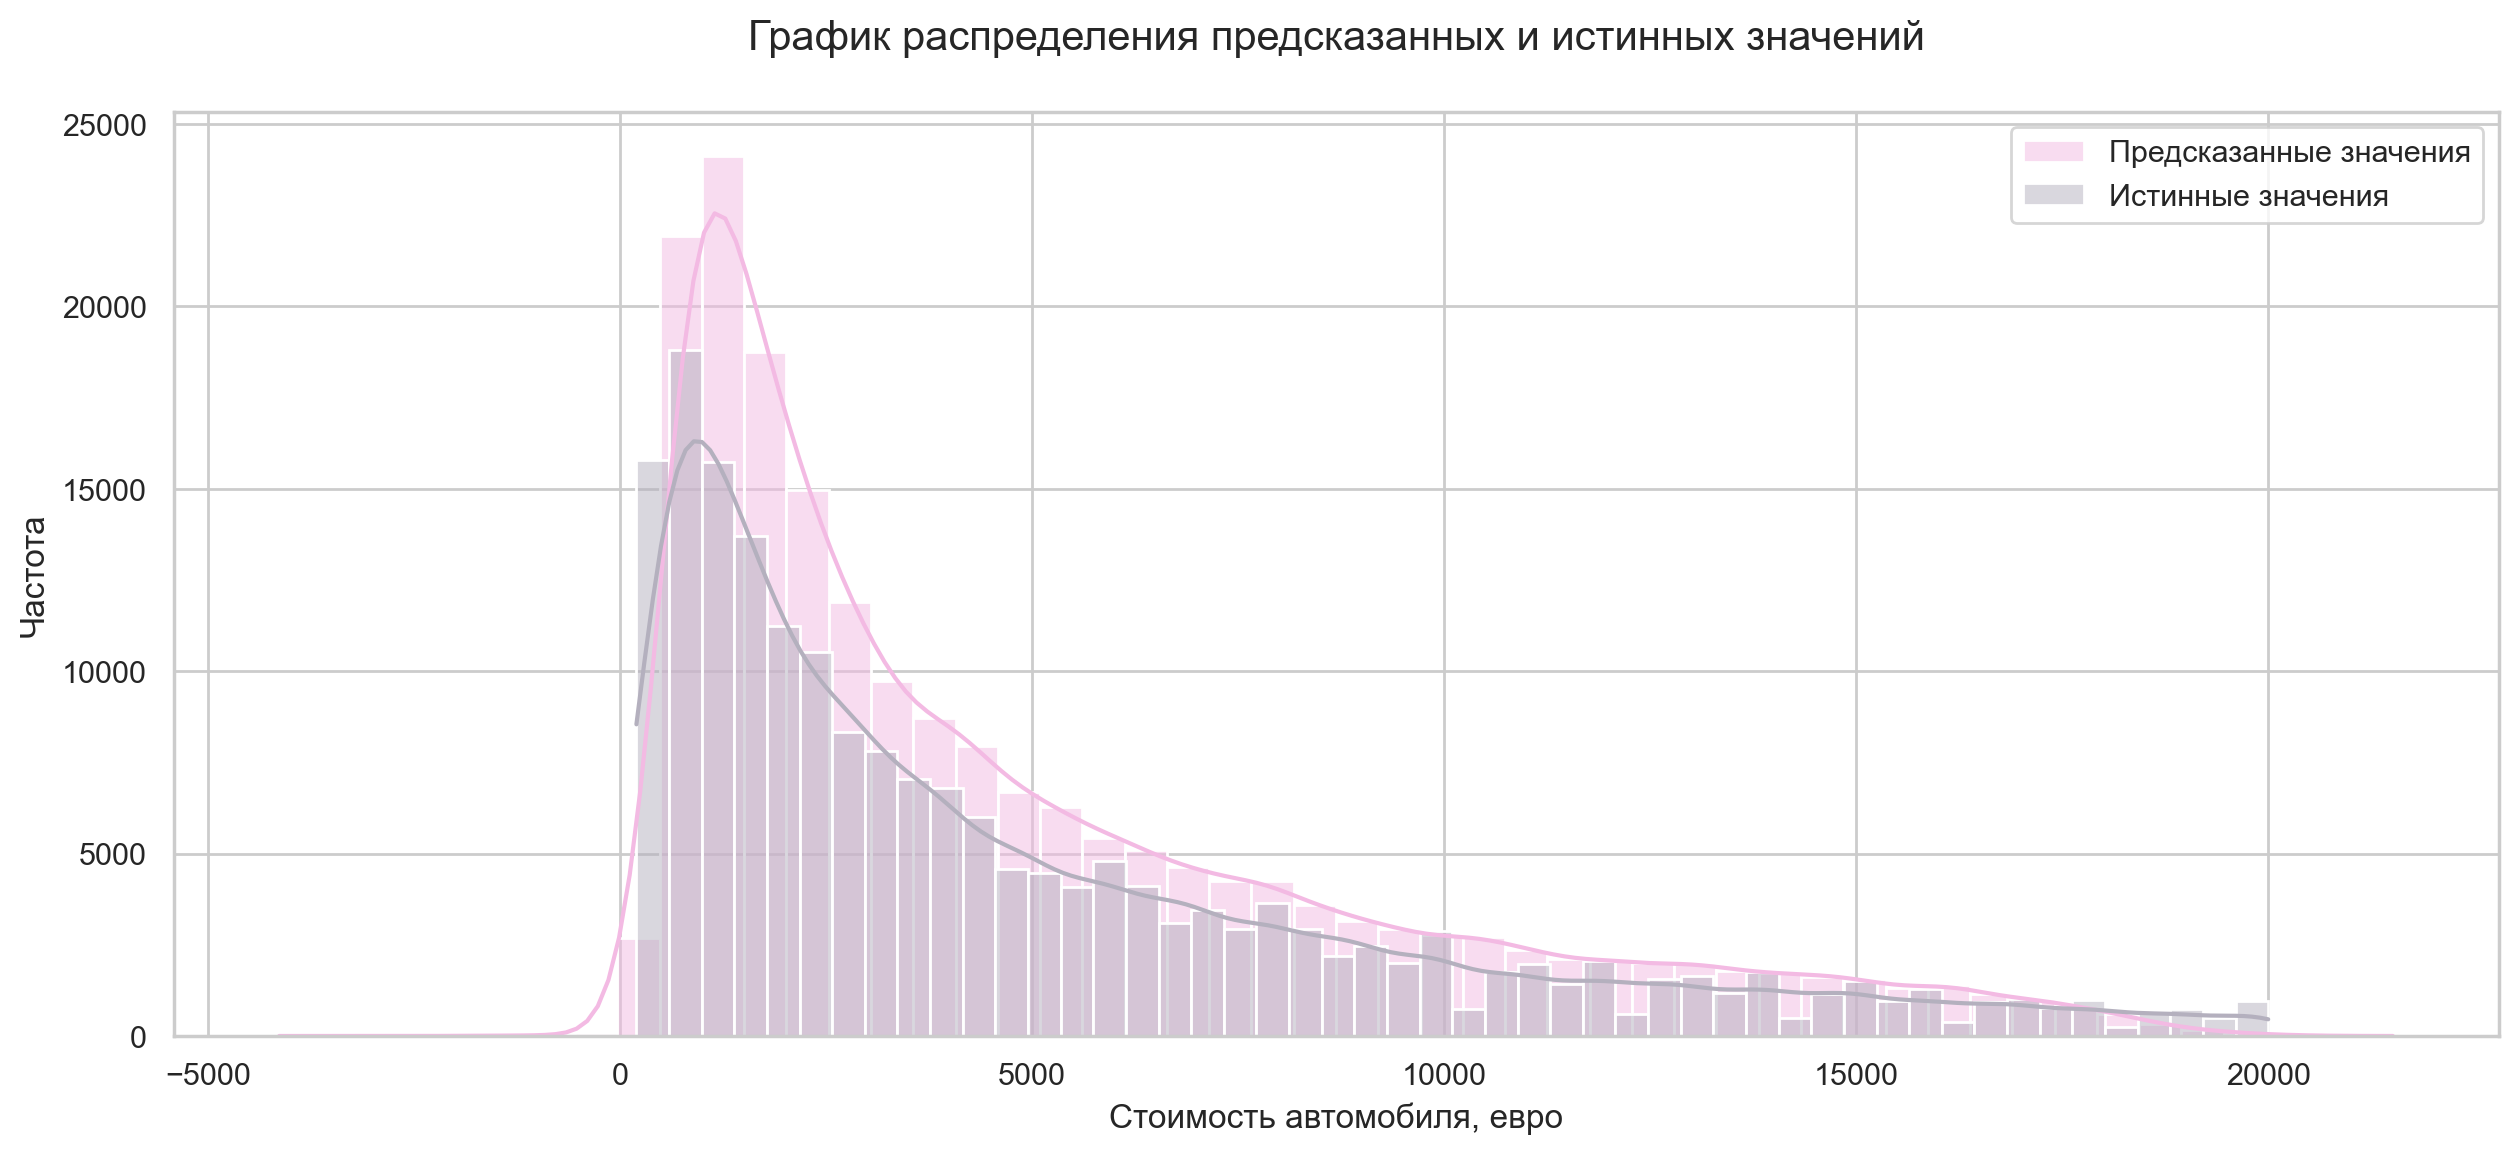

In [89]:
# построим график
plot_true_predict(target_train, best_model_cbr.predict(features_train), '#F3BAE3', '#B4B0BE')

**Вывод:**

- Наилучшее качество модели RMSE Cat Boost Regressor = 1656. Показатель лучше, чем в предыдущих моделях.

### Стохастический градиентный бустинг / Light GBM

- Для перебора различных гиперпараметров Light GBM будем использовать Grid Search CV
- Обучим модель с наилучшими параметрами и оценим ее качество с помощью кроссвалидации, используя метрику RMSE
- Измерим время обучения и предсказания модели
- Построим график распределения предсказанных и истинных значений

In [90]:
# приводим категориальные признаки к типу category
features_train_lgbm = features_train.copy()
features_train_lgbm[cat_columns] = features_train_lgbm[cat_columns].astype('category')

In [91]:
# переберем различные гиперпараметры  LGBM Classifier с помощью GridSearch CV. Найдем лучшие
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)

lgbm_params = {
    'learning_rate': [.1, .01, .3], 
    'max_depth': [None] + [i for i in range(2, 7)],
    'n_estimators': range(10, 500, 50),
}


gs_lgbm_pl = GridSearchCV (
    model_lgbm, 
    lgbm_params, 
    scoring='neg_root_mean_squared_error', 
    cv=5,
    n_jobs=-1
)

gs_lgbm_pl.fit(features_train_lgbm, target_train)
rmse_lgbm = gs_lgbm_pl.best_score_ * (-1)
best_model_lgbm = gs_lgbm_pl.best_estimator_

print(f'Лучшее значение RMSE: {round(rmse_lgbm, 1)}')
print(f'Лучшие параметры: {gs_lgbm_pl.best_params_}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 196815, number of used features: 7
[LightGBM] [Info] Start training from score 4852.061464
Лучшее значение RMSE: 1621.6
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 460}


In [92]:
# оценим время обучения модели
start_time = time.time()
model_lgbm = LGBMRegressor(learning_rate=0.1, max_depth=None, n_estimators=460 , 
                            random_state=RANDOM_STATE)
model_lgbm.fit(features_train_lgbm, target_train)
training_time_lgbm = time.time() - start_time
print(f'Время обучения модели: {round(training_time_lgbm, 1)} секунд')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 196815, number of used features: 7
[LightGBM] [Info] Start training from score 4852.061464
Время обучения модели: 1.4 секунд


In [93]:
# оценим время предсказания модели
start_time = time.time()
predictions_lgbm = model_lgbm.predict(features_train_lgbm)
prediction_time_lgbm = time.time() - start_time
print(f'Время предсказания модели: {round(prediction_time_lgbm, 1)} секунд')
del model_lgbm

Время предсказания модели: 0.6 секунд


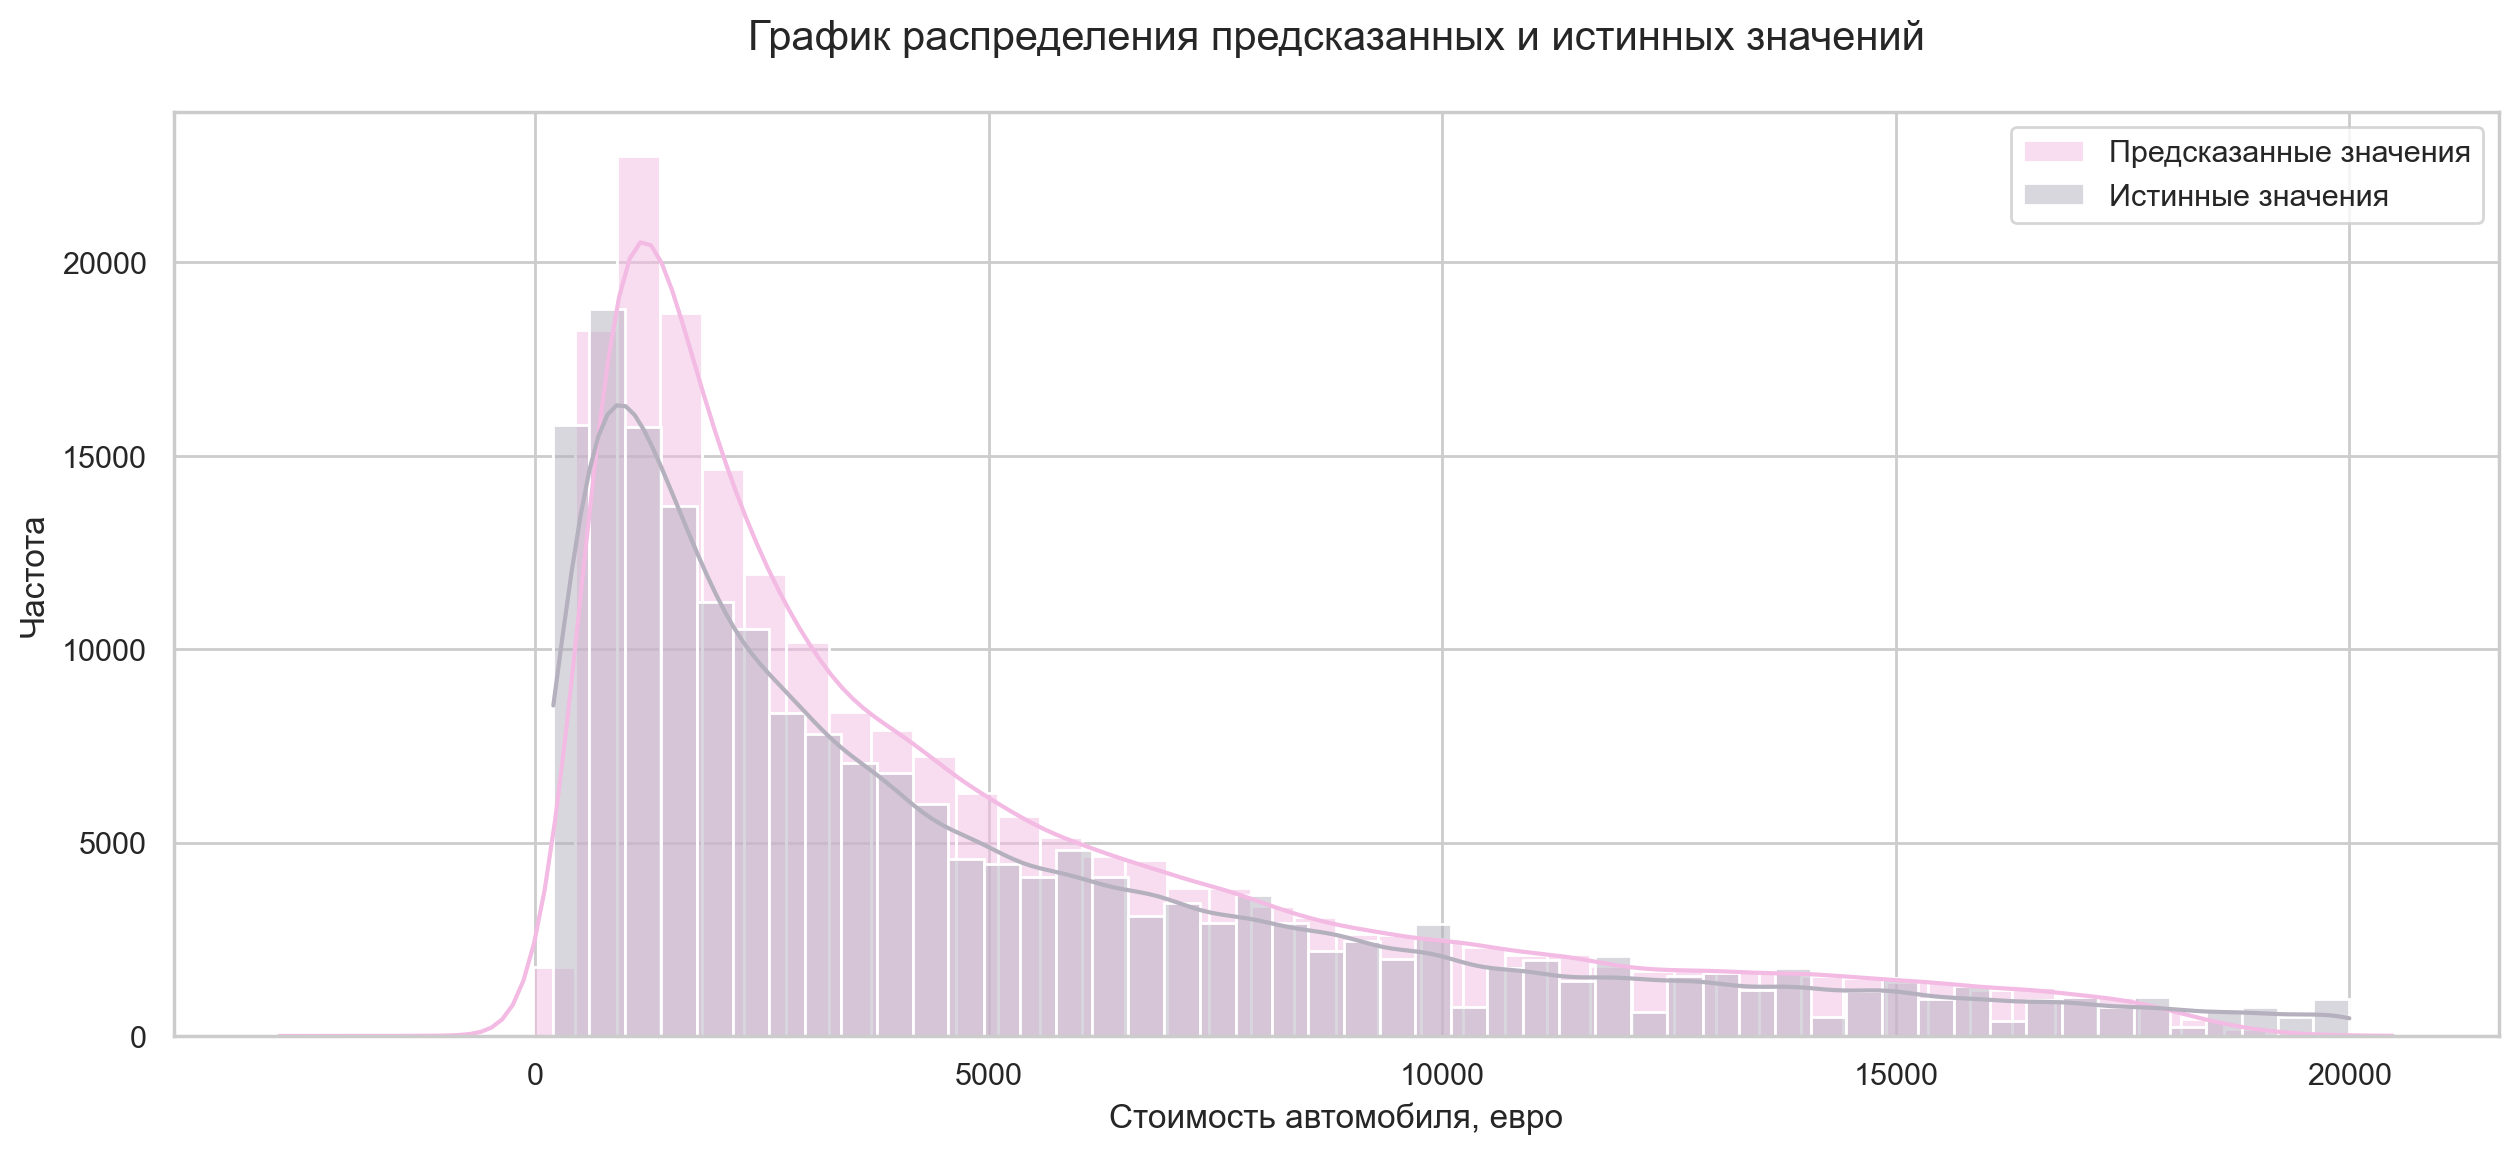

In [94]:
# построим график
plot_true_predict(target_train, best_model_lgbm.predict(features_train_lgbm), '#F3BAE3', '#B4B0BE')

**Вывод:**

- Наилучшее качество модели RMSE Light GBM = 1622. Этот показатель близок к RMSE Cat Boost Regressor, но превосходит по количеству затраченного на обучение времени.

### Вывод по шагу "Обучение моделей"

1. На этом шаге обучили четыре модели: Линейная регрессия (Linear Regression), Случайный лес (Random Forest Regressor), Градиентный бустинг (Cat Boost Regressor), Стохастический градиентный бустинг (Light GBM).


2. Модели градиентного бустинга показали лучшее качество по сравнению с базовыми моделями.

## Анализ моделей

- Проанализируем время обучения, время предсказания и качество моделей
- Опираясь на критерии заказчика, выберем лучшую модель, проверим её качество на тестовой выборке.

In [95]:
#создадим таблицу с показателями RMSE, временем обучения и временем предсказания моделей
index = ['Linear Regression',
         'Random Forest Regressor',
         'Cat Boost Regressor',
         'Light GBM',
        ]

metrics = {'RMSE':[round(rmse_lr, 1),
                round(rmse_rfr, 1),
                round(rmse_cbr, 1),
                round(rmse_lgbm, 1),],
        
        'Время обучения модели, с':[round(training_time_lr, 1),
                                 round(training_time_rfr, 1),
                                 round(training_time_cbr, 1),
                                 round(training_time_lgbm, 1),] ,
        
        'Время предсказания модели, с':[round(prediction_time_lr, 1),
                                 round(prediction_time_rfr, 1),
                                 round(prediction_time_cbr, 1),
                                 round(prediction_time_lgbm, 1), ]
       }

metrics_data = pd.DataFrame(data=metrics, index=index)
metrics_data.sort_values(by=['RMSE', 'Время обучения модели, с', 'Время предсказания модели, с'])

,RMSE,"Время обучения модели, с","Время предсказания модели, с"
Light GBM,"1,621.60",1.40,0.60
Cat Boost Regressor,"1,655.70",123.00,0.70
Random Forest Regressor,"2,070.20",198.40,3.10
Linear Regression,"2,594.90",1.40,0.00


### Тестирование лучшей модели

Опираясь на критерии: качество предсказания, время обучения модели и время предсказания модели для дальнейшего тестирования будем использовать модель стохастического градиентного бустинга Light GBM.

In [96]:
# обучим модель
start_time = time.time()

model = LGBMRegressor( 
    learning_rate=0.1, 
    random_state = RANDOM_STATE, 
    max_depth=None, 
    n_estimators=460, 
)
model.fit(features_train_lgbm, target_train)
training_time = time.time() - start_time
print(f'Время обучения модели: {round(training_time, 1)} секунд')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 196815, number of used features: 7
[LightGBM] [Info] Start training from score 4852.061464
Время обучения модели: 1.1 секунд


In [97]:
features_test_lgbm = features_test.copy()
features_test_lgbm[cat_columns] = features_test_lgbm[cat_columns].astype('category')

In [98]:
# получим прогнозы и оценим качество
start_time = time.time()
predictions = model.predict(features_test_lgbm)
rmse = mean_squared_error(target_test, predictions, squared=False)
prediction_time = time.time() - start_time
print(f'Время предсказания модели: {round(prediction_time, 1)} секунд')
print(f'RMSE Light GBM с OneHotEncoder: {round(rmse, 1)}')

Время предсказания модели: 0.2 секунд
RMSE Light GBM с OneHotEncoder: 1618.8


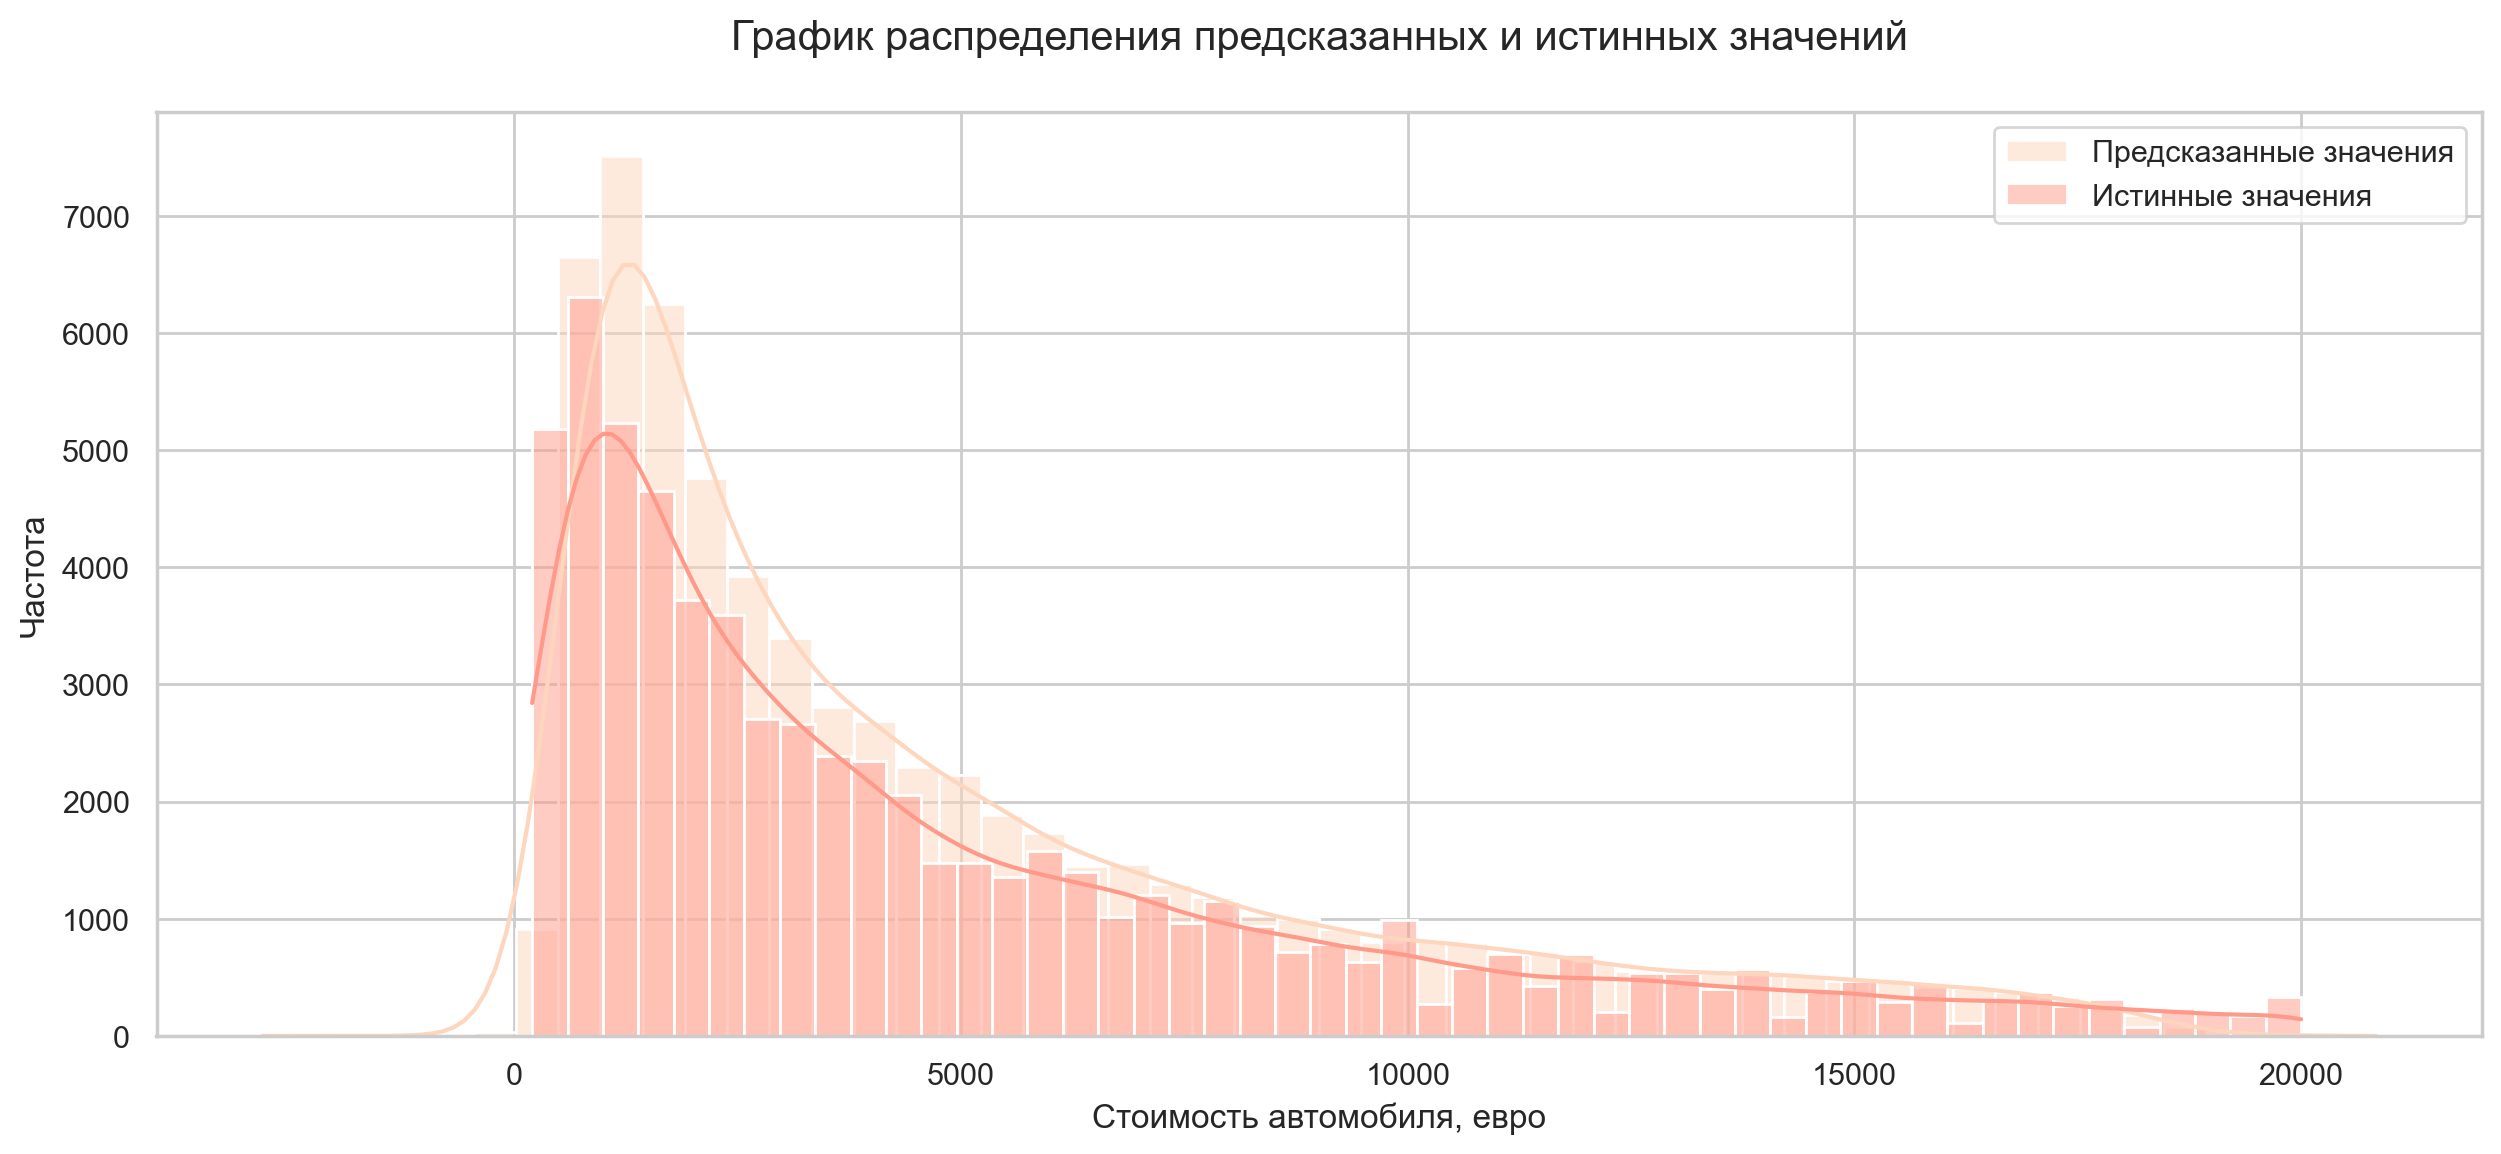

In [99]:
# построим график
plot_true_predict(target_test, predictions, '#FDD6BD', '#FF9A8B')

In [100]:
# функция для построения графика важности признаков
def feature_importance(data_impotance, fi_yerr, name=' '):
    plt.figure(figsize=(16, 6))
    data_impotance.plot.bar(yerr=fi_yerr, color='#FDD6BD')
    plt.title(f'Важность признаков для модели {name}', fontsize=14)
    plt.ylabel('Важность признака', fontsize=12)
    plt.show()

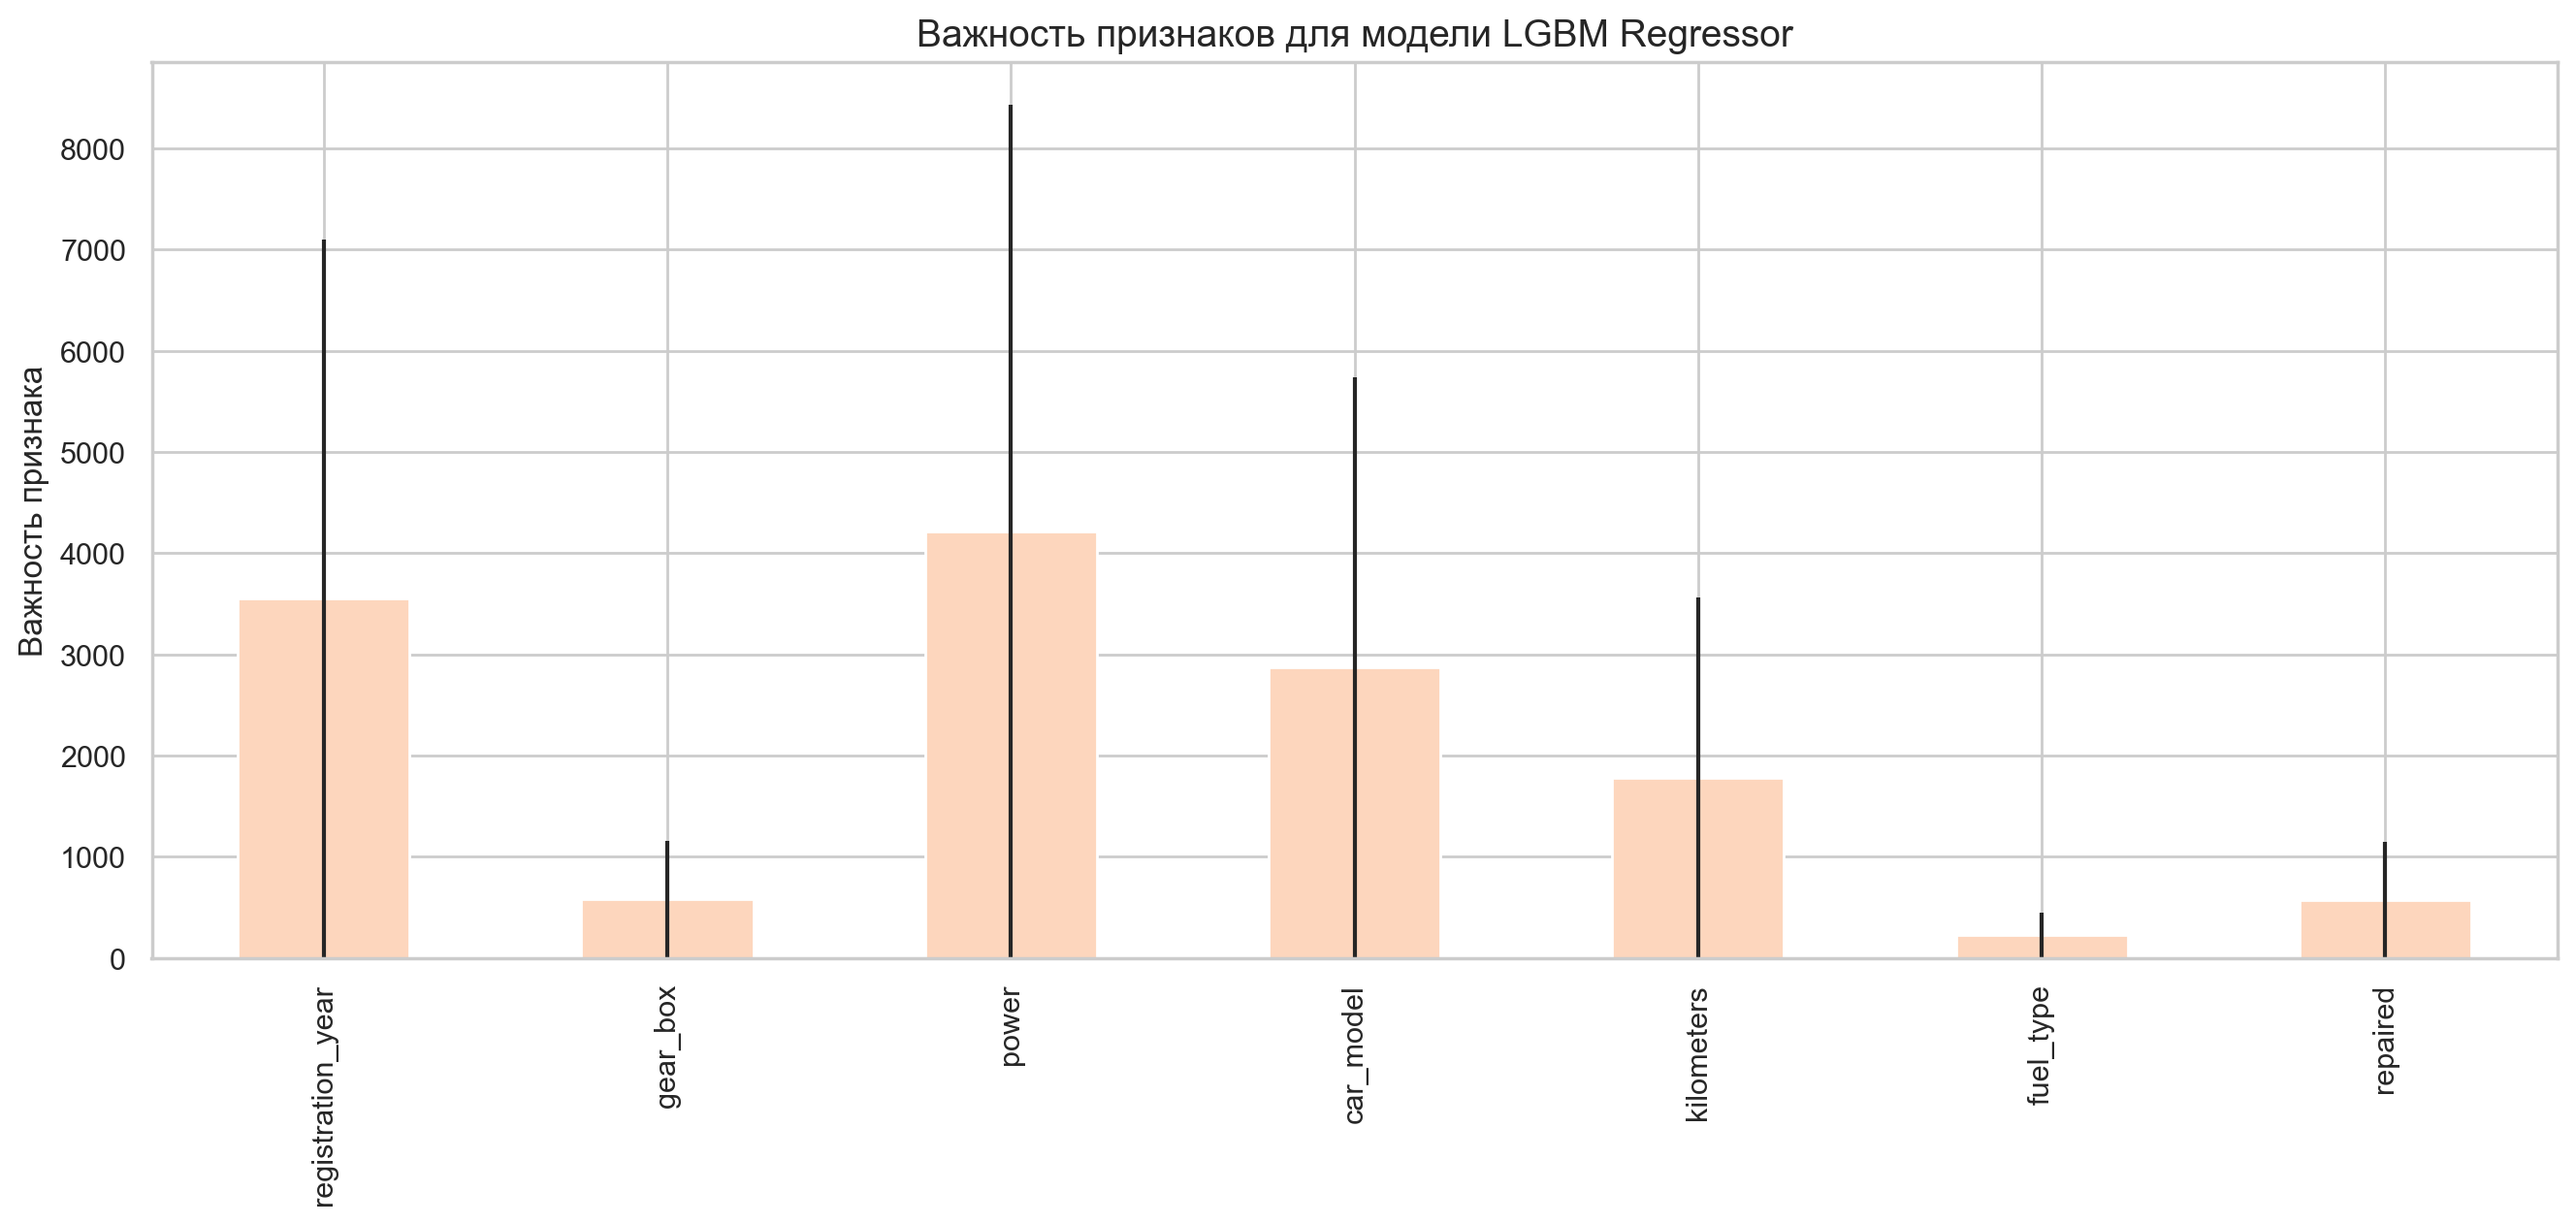

In [101]:
# построим график важности признаков
lgbm_importances = pd.Series(model.feature_importances_, index=features_test_lgbm.columns)
feature_importance(lgbm_importances, lgbm_importances, name='LGBM Regressor')

In [102]:
# проверим модель на адекватность
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
prediction = dummy_regr.predict(features_test)
mean_squared_error(target_test, prediction, squared = False)

4596.314445249175

### Вывод по шагу "Анализ моделей"

1. Опираясь на критерии заказчика: качество предсказания, время обучения модели и время предсказания модели итоговой моделью была выбрана модель стохастического градиентного бустинга Light GBM с использованием внутренних кодировщиков.


2. После тестирования модели финальный показатель RMSE = 1619, время обучения = 6.9с, время предсказания модели = 2.1с. 


## Общий вывод

Цель настоящего исследования - подготовить прототип модели машинного обучения. Модель должна определять рыночную стоимость автомобиля. В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей. Заказчик - сервис по продаже автомобилей с пробегом, который разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.

Для заказчика были важны следующие критерии: качество предсказания, время обучения модели и время предсказания модели.


1. В нашем распоряжении были данные по 354369 автомобилям, каждый из которых описывается 16-ю признаками (7 количественных, 6 категориальных и 3 временных).

<br>

2. Перед началом исследования данные были подготовлены. После предобработки было удалено 29% всех данных:
    - обработаны пропущенные и аномальные значения,
    - удалены дубликаты и неинформативные признаки,
    - было выявлено, что наибольшее влияние на целевой признак оказывают признаки: год регистрации автомобиля, мощность и модель автомобиля.

![cars_1](/Desktop/portfolio/pics/cars_1.png)

3. В исследовании участвовали четыре различные алгоритма классификации: Линейная регрессия (Linear Regression), Случайный лес (Random Forest Regressor), Градиентный бустинг (Cat Boost Regressor), Стохастический градиентный бустинг (LGBM Regressor). У каждой модели менялись гиперпараметры, чтобы добиться наиболее высокой оценки качества.


    Итоговый список признаков для обучения моделей:
    - `registration_year` - год регистрации автомобиля,
    - `gear_box` - тип коробки передач,
    - `power` - мощность (л. с.),
    - `car_model` - модель автомобиля,
    - `kilometers` - пробег (км),
    - `fuel_type` - тип топлива,
    - `repaired` - была машина в ремонте или нет.

    Целевой признак:
    - `car_price` - стоимость автомобиля (евро).


    Перед началом обучения:
    - исходный датафрейм был разделён на две выборки: обучающую (75%) и тестовую (25%),
    - для Linear Regression количественные признаки были масштабированы, а категориальные закодированы методом прямого кодирования (One-Hot Encoding) с использованием pipeline,
    - для Random Forest Regressor количественные признаки были масштабированы, а категориальные закодированы методом OrdinalEncoder с использованием pipeline,
    - для Cat Boost Regressor и LGBM Regressor категориальные признаки были закодированы с использованием внутренних кодировщиков.


    Сводная таблица исследованных моделей и их метрики на кросс-валидации:

![cars_2](/Desktop/portfolio/pics/cars_2.png)

4. Оценкой качества модели была выбрана метрика RSME - среднеквадратичная ошибка, которая сообщает нам среднее расстояние между прогнозируемыми значениями из модели и фактическими значениями в наборе данных. При анализе моделей также учитывались время обучения и время предсказания модели.

<br>

5. По итогам исследования был сделан вывод, что для определения рыночной стоимости автомобиля наиболее подходящей моделью является модель, построенная на **алгоритме стохастического градиентного бустинга (Light GBM) с количеством деревьев 460, глубиной дерева None и скоростью обучения 0.1**. 

Итоговое значение качества модели на тестовой выборке RSME = 1619. Модель характеризуется высоким временем предсказания и обучения.

![cars_3](/Desktop/portfolio/pics/cars_3.png)

Наибольший вклад в обучение модели вносят признаки: год регистрации автомобиля, мощность и модель.

In [ ]:
![cars_4](/Desktop/portfolio/pics/cars_4.png)